 # Stable Event Listing/Sorting using Mgs Bulk Hist Results, IMF Criteria, and Mitsuo's IMplementation of Peredo95 BowShock Model
 ## Optimized Script/Sequel to 'Event Searching pt2' 
 ### Hector Salinas
 #### 8-19-2022(when I moved functions to this new script)
 
 * Note:
     * this script serves as a super optimized version of 'Event Searching pt2...'. Where it deletes any old function, comments, and whatever else that's not needed. In addition to the typical 30min search procedure described in the old script. It shall also compute the Bow Shock Normal Angle, using Peredo's 1995 bow shock model, to further categorize stuff by quasi-parallel and perpendular events

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import optimize 
import numpy as np
import time
import pandas as pd
import copy

import pyspedas
import pytplot
from pyspedas import tinterpol    #to match MEC data to OMNI 5min time stamps
from pytplot import tplot, tlimit # plot said tplot variables and specify xrange
from pytplot import tplot_names   # list tplot variables loaded
from pytplot import get_data      # extract data values from tplot variables
from pyspedas import time_string  # convert unix time to string(returns it as 'list object' not numpy array)
from pytplot import store_data    # creating tplot variables
from pytplot import options       # extra tplot features for individial tplots
from pytplot import tplot_options # global tplot options for created tplots
from pyspedas import time_string  # convert unix time to string(returns it as 'list object' not numpy array)
from pyspedas import time_double  #convert string back to unix time

## Section 0: Loading up the Solar Wind OMNI parameters for 2015-21 Dayside or Nightside
* IN comparing teh OMNI 'F'(Bfield magnitude) with the manually computed magnitudes of the GSM and GSE field data. ALl three dataproducts are somewhat close in value, with GSE and GSM being nearly identical.
    * For the sake of consistency of what I did in `Event Searchin Pt2`, I'm gonna stick with using the OMNI 'F' Bfield magnitude data.

In [2]:
##### Below are all the defined FUNDAMENTAL functions#################################################

def getSWParam(achDate, n):
# Load/return Year X OMNI data arrays with inputted tuple index and string list date range
    pytplot.del_data()#deleting previously loaded tplot variables
    print('\nInput date was: %s (Year %d)' %(achDate, n+1) )
     #create two empty dataframes with column names
    #df_SWparam = pd.DataFrame(columns = ['Bmag(nT)', 'Bmag)gse(nT)', 'Bmag_gsm(nT)'])
    #'Utime', 'BXgse(nT)', 'BYgsm(nT)','BZgsm(nT)', 'Bmag(nT)', 
     #                                   'Bmag)gse(nT)', 'Bmag_gsm(nT)'
    omni_vars = pyspedas.omni.data(trange= achDate, datatype = '5min') #extracting data with 5min resolution
    #Extracting OMNI data as arrays
    xtime, x_val = get_data('x')#omni SC position already in Re units
    ytime, y_val = get_data('y')
    ztime, z_val = get_data('z')
    #--Get OMNI Bfield data in GSM(for Stable IMF Events) and GSE(for Shock Angle calculations)coord!!!!!!!
    bx_time, bx_value = get_data('BX_GSE')
    by_time, by_value = get_data('BY_GSM')
    bz_time, bz_value = get_data('BZ_GSM')
    #-
    bygse_time, bygse_value = get_data('BY_GSE')
    bzgse_time, bzgse_value = get_data('BZ_GSE')
    bmag_time, bmag_value = get_data('F') # 'F' is B-field magnitude
    pden_time, pden_val = get_data('proton_density') # technically ion density
    flowv_time, flowv_val = get_data('flow_speed') 
    press_time, press_val = get_data('Pressure') #flow pressure
    mach_time, alfmach_val = get_data('Mach_num')  #Alfven Mach number
    magmach_time, magmach_val = get_data('Mgs_mach_num') #Magnetosonic mach num
    #Defining string variables for OMNI start and end time
    achOmni_start = time_string(bx_time[0])
    achOmni_end = time_string(bx_time[-1])
    achTime = time_string(bx_time)
    print('\nConfirming loaded OMNI data range: %s to %s' %(achOmni_start[0:10], achOmni_end[0:20]));
    #--Defining 2 DFs with full SWparams and only Shockparams
    SW_dict = {'Utime': bx_time, 'BXgse(nT)': bx_value, 'BYgsm(nT)':by_value ,'BZgsm(nT)':bz_value, 
       'Bmag(nT)':bmag_value, 'Pden(1/cc)':pden_val, 'Flowv(km/s)':flowv_val, 'Flow_P(nPa)':press_val,
       'AlfMach': alfmach_val, 'MGSmach': magmach_val, 'Time_str': achTime}
    df_SWparam = pd.DataFrame(SW_dict)
    #--
    Shock_dict = {'Utime': bx_time, 'BXgse(nT)': bx_value, 'BYgse(nT)':bygse_value ,'BZgse(nT)':bzgse_value, 
       'Bmag(nT)':bmag_value, 'Xgse(Re)':x_val,'Ygse(Re)':y_val,'Zgse(Re)':z_val,'Flowv(km/s)':flowv_val,'MGSmach': magmach_val, 'Time_str': achTime}
    df_Shockparam = pd.DataFrame(Shock_dict)
    print('--->Confirmed: SW and Shock Param DFs created')
    display(df_SWparam[:5])
    display(df_Shockparam[:5])

    #-Store OMNI Params in DF and display them
    #print('Hi hi')
    #df_SWparam['Bmag(nT)'] = bmag_value
    #df_SWparam['Bmag)gse(nT)'] = np.sqrt(bx_value**2 + by_value**2 + bz_value**2)
    #df_SWparam['Bmag_gsm(nT)'] = np.sqrt(bx_value**2 + bygse_value**2 + bzgse_value**2)
    #display(df_SWparam[:5])
    return (df_SWparam, df_Shockparam);
    

def PlotHist(afData, title, xlabel,binwidth):
# Creates a histogram with the above inputs where the data array already excludes NAN values
    plt.figure(figsize = (8,8))
    #Defining: BinRange = DataArray_max - DataArray_min (exluding nan-values)
    DataRange = np.nanmax(afData) - np.nanmin(afData)
    #Plotting/displaying histogram and data average
    nCounts, bin_edges, patches = hist_data_binwidth(afData, binwidth)
    #plt.hist(afData, bins = 'auto',color = 'b', alpha = 0.70)
    avg_value = np.average(afData) #Computes average of inputted data array
    plt.axvline(avg_value,color = 'orange', linestyle = '--')
    plt.title('%s' %title, fontsize = 12)
    plt.xlabel('%s' %xlabel)
    plt.ylabel('Frequency');
    #Inputting label names where BinWidth = BinRange/(# of bins)
    plt.legend(labels = ['Average = %0.3f' %avg_value,'Bin Width = %0.3f' %(DataRange/len(nCounts))],
               loc = 'best', prop={'size': 10});
    
    
def hist_data_binwidth(afData,binwidth):
# Creates histogram of inputted data with user defined bin width
    if binwidth == 'auto': # Make histogram with default bin size
        nCounts, bin_edges, patches = plt.hist(afData, bins = 'auto')#, alpha = 0.70)
    else: #Make histogram with user's binwidth
        nCounts, bin_edges, patches = plt.hist(afData, bins = 
                   np.arange(np.nanmin(afData),np.nanmax(afData) + binwidth, binwidth))#, alpha = 0.70)
    return(nCounts, bin_edges, patches);

    
def HistMgsMach(afData, title, xlabel):
# Makes a histogram Mgs data with defined bin width to avoid displayed gaps(auto bin# too small)
    plt.figure(figsize = (8,8))
    binwidth = 0.099 # defining bin width as ~ 0.1 to avoid any histogram bar gaps
    #Defining: BinRange = DataArray_max - DataArray_min (exluding nan-values)
    DataRange = np.nanmax(afData) - np.nanmin(afData) 
    # Histing data by defining bin range
    nCounts, bin_edges, patches = plt.hist(afData, bins = np.arange(np.nanmin(afData),
                                            np.nanmax(afData) + binwidth, binwidth),color = 'b', alpha = 0.70)
    plt.title('%s' %title, fontsize = 12)
    plt.xlabel('%s' %xlabel)
    plt.ylabel('Frequency');
    avg_value = np.average(afData) #Computes average of inputted data array
    plt.axvline(avg_value,color = 'orange', linestyle = '--', label = 'Average = %0.3f' %avg_value)
    #Inputting labels names where BinWidth = BinRange/(# of bins)
    plt.legend(labels = ['Average = %0.3f' %avg_value,'Bin Width = %0.3f' %(DataRange/len(nCounts))],
               loc = 'best', prop={'size': 10});
    
def get_choice():
# Input validation for nChoice that is positive and between [1,5]
    achPrompt = ("\nChoose Year to Histogram SW Params:\n(1) Sept 2015-May 2016 \n(2) Sept 2016-May 2017"   
    "\n(3) Sept 2017-May 2018 \n(4) Sept 2018-May 2019 \n(5) Sept 2019-May 2020 \n(6) Exit \n")
    nChoice = int(input(achPrompt))
    while nChoice <= 0 or nChoice >= 7:
        print('Invalid input %s' %nChoice)
        nChoice = int(input(achPrompt))
    return nChoice


def namestr(obj, namespace):
## (as defined by the a stackoverflowuser) returns name of object as a string list
    return [name for name in namespace if namespace[name] is obj]

    
    
####### Above are all the defined FUNDAMENTAL functions#############################################

#Defined tuple for string date list to input into OMNI data load command
achInputDate_day = (['2015-09-1', '2016-05-31'], ['2016-09-1', '2017-05-31'], ['2017-09-1', '2018-05-31'],
               ['2018-09-1', '2019-05-31'], ['2019-09-1', '2020-05-31'], ['2020-09-1', '2021-05-31'])

achInputDate_night = (['2015-06-1', '2015-08-31'], ['2016-06-1', '2016-08-31'], ['2017-06-1', '2017-08-31'],
               ['2018-06-1', '2018-08-31'], ['2019-06-1', '2019-08-31'], ['2020-06-1', '2020-08-31'],
                     ['2021-06-1', '2021-08-31'])
print('My %d Dayside element string tuple is \n' %len(achInputDate_day), achInputDate_day)
print('\nMy %d Nightside element string tuple is \n' %len(achInputDate_night), achInputDate_night)



#tplot(['x', 'y', 'z']) #already measured in Re units

My 6 Dayside element string tuple is 
 (['2015-09-1', '2016-05-31'], ['2016-09-1', '2017-05-31'], ['2017-09-1', '2018-05-31'], ['2018-09-1', '2019-05-31'], ['2019-09-1', '2020-05-31'], ['2020-09-1', '2021-05-31'])

My 7 Nightside element string tuple is 
 (['2015-06-1', '2015-08-31'], ['2016-06-1', '2016-08-31'], ['2017-06-1', '2017-08-31'], ['2018-06-1', '2018-08-31'], ['2019-06-1', '2019-08-31'], ['2020-06-1', '2020-08-31'], ['2021-06-1', '2021-08-31'])


In [3]:
#####Loading Up Yr1 OMNI Data

## Extracting some Yr1 OMNI Data Arrays
[df_SWDay_yr1, df_ShockDay_yr1] = getSWParam(achInputDate_day[0], 0);

09-Mar-23 13:23:05: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2015/



Input date was: ['2015-09-1', '2016-05-31'] (Year 1)


09-Mar-23 13:23:06: Downloading https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2015/omni_hro2_5min_20150901_v01.cdf to omni_data/hro2_5min/2015/omni_hro2_5min_20150901_v01.cdf
09-Mar-23 13:23:06: Download complete: omni_data/hro2_5min/2015/omni_hro2_5min_20150901_v01.cdf
09-Mar-23 13:23:06: Downloading https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2015/omni_hro2_5min_20151001_v01.cdf to omni_data/hro2_5min/2015/omni_hro2_5min_20151001_v01.cdf
09-Mar-23 13:23:07: Download complete: omni_data/hro2_5min/2015/omni_hro2_5min_20151001_v01.cdf
09-Mar-23 13:23:07: Downloading https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2015/omni_hro2_5min_20151101_v01.cdf to omni_data/hro2_5min/2015/omni_hro2_5min_20151101_v01.cdf
09-Mar-23 13:23:07: Download complete: omni_data/hro2_5min/2015/omni_hro2_5min_20151101_v01.cdf
09-Mar-23 13:23:08: Downloading https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2015/omni_hro2_5min_20151201_v01.cdf to o

Time clip was applied to: IMF
Time clip was applied to: PLS
Time clip was applied to: IMF_PTS
Time clip was applied to: PLS_PTS
Time clip was applied to: percent_interp
Time clip was applied to: Timeshift
Time clip was applied to: RMS_Timeshift
Time clip was applied to: Time_btwn_obs
Time clip was applied to: F
Time clip was applied to: BX_GSE
Time clip was applied to: BY_GSE
Time clip was applied to: BZ_GSE
Time clip was applied to: BY_GSM
Time clip was applied to: BZ_GSM
Time clip was applied to: RMS_SD_B
Time clip was applied to: RMS_SD_fld_vec
Time clip was applied to: flow_speed
Time clip was applied to: Vx
Time clip was applied to: Vy
Time clip was applied to: Vz
Time clip was applied to: proton_density
Time clip was applied to: T
Time clip was applied to: NaNp_Ratio
Time clip was applied to: Pressure
Time clip was applied to: E
Time clip was applied to: Beta
Time clip was applied to: Mach_num
Time clip was applied to: Mgs_mach_num
Time clip was applied to: x
Time clip was applie

,Utime,BXgse(nT),BYgsm(nT),BZgsm(nT),Bmag(nT),Pden(1/cc),Flowv(km/s),Flow_P(nPa),AlfMach,MGSmach,Time_str
0,1.441066e+09,3.91,-0.50,-1.62,4.47,4.42,361.899994,1.16,8.5,5.3,2015-09-01 00:00:00.000000
1,1.441066e+09,4.20,-1.14,-0.90,4.50,4.09,357.299988,1.05,8.1,5.1,2015-09-01 00:05:00.000000
2,1.441066e+09,3.77,-2.28,-0.10,4.61,4.53,359.600006,1.17,8.3,5.2,2015-09-01 00:10:00.000000
3,1.441066e+09,3.45,-3.34,-0.00,4.83,4.61,362.700012,1.21,8.1,5.3,2015-09-01 00:15:00.000000
4,1.441067e+09,3.61,-3.38,0.00,4.99,4.42,362.899994,1.16,7.7,5.2,2015-09-01 00:20:00.000000


,Utime,BXgse(nT),BYgse(nT),BZgse(nT),Bmag(nT),Xgse(Re),Ygse(Re),Zgse(Re),Flowv(km/s),MGSmach,Time_str
0,1.441066e+09,3.91,-0.13,-1.69,4.47,224.869995,-24.160000,-19.540001,361.899994,5.3,2015-09-01 00:00:00.000000
1,1.441066e+09,4.20,-0.91,-1.13,4.50,224.869995,-24.150000,-19.540001,357.299988,5.1,2015-09-01 00:05:00.000000
2,1.441066e+09,3.77,-2.20,-0.60,4.61,224.869995,-24.150000,-19.540001,359.600006,5.2,2015-09-01 00:10:00.000000
3,1.441066e+09,3.45,-3.25,-0.75,4.83,224.869995,-24.139999,-19.540001,362.700012,5.3,2015-09-01 00:15:00.000000
4,1.441067e+09,3.61,-3.29,-0.76,4.99,224.860001,-24.139999,-19.540001,362.899994,5.2,2015-09-01 00:20:00.000000


In [4]:
#tplot('F')

#####Loading Up Yr2 OMNI Data

## Extracting some Yr2 OMNI Data Arrays
[df_SWDay_yr2, df_ShockDay_yr2] = getSWParam(achInputDate_day[1], 1);

09-Mar-23 13:23:43: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2016/



Input date was: ['2016-09-1', '2017-05-31'] (Year 2)


09-Mar-23 13:23:44: Downloading https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2016/omni_hro2_5min_20160901_v01.cdf to omni_data/hro2_5min/2016/omni_hro2_5min_20160901_v01.cdf
09-Mar-23 13:23:44: Download complete: omni_data/hro2_5min/2016/omni_hro2_5min_20160901_v01.cdf
09-Mar-23 13:23:44: Downloading https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2016/omni_hro2_5min_20161001_v01.cdf to omni_data/hro2_5min/2016/omni_hro2_5min_20161001_v01.cdf
09-Mar-23 13:23:45: Download complete: omni_data/hro2_5min/2016/omni_hro2_5min_20161001_v01.cdf
09-Mar-23 13:23:45: Downloading https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2016/omni_hro2_5min_20161101_v01.cdf to omni_data/hro2_5min/2016/omni_hro2_5min_20161101_v01.cdf
09-Mar-23 13:23:45: Download complete: omni_data/hro2_5min/2016/omni_hro2_5min_20161101_v01.cdf
09-Mar-23 13:23:46: Downloading https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2016/omni_hro2_5min_20161201_v01.cdf to o

Time clip was applied to: IMF
Time clip was applied to: PLS
Time clip was applied to: IMF_PTS
Time clip was applied to: PLS_PTS
Time clip was applied to: percent_interp
Time clip was applied to: Timeshift
Time clip was applied to: RMS_Timeshift
Time clip was applied to: Time_btwn_obs
Time clip was applied to: F
Time clip was applied to: BX_GSE
Time clip was applied to: BY_GSE
Time clip was applied to: BZ_GSE
Time clip was applied to: BY_GSM
Time clip was applied to: BZ_GSM
Time clip was applied to: RMS_SD_B
Time clip was applied to: RMS_SD_fld_vec
Time clip was applied to: flow_speed
Time clip was applied to: Vx
Time clip was applied to: Vy
Time clip was applied to: Vz
Time clip was applied to: proton_density
Time clip was applied to: T
Time clip was applied to: NaNp_Ratio
Time clip was applied to: Pressure
Time clip was applied to: E
Time clip was applied to: Beta
Time clip was applied to: Mach_num
Time clip was applied to: Mgs_mach_num
Time clip was applied to: x
Time clip was applie

,Utime,BXgse(nT),BYgsm(nT),BZgsm(nT),Bmag(nT),Pden(1/cc),Flowv(km/s),Flow_P(nPa),AlfMach,MGSmach,Time_str
0,1.472688e+09,-2.53,3.89,-3.63,5.96,6.86,419.899994,2.42,9.2,5.8,2016-09-01 00:00:00.000000
1,1.472688e+09,-1.78,4.36,-2.61,5.88,7.10,418.899994,2.50,9.5,5.8,2016-09-01 00:05:00.000000
2,1.472689e+09,-0.08,5.32,-1.95,5.86,7.43,429.799988,2.74,10.0,6.2,2016-09-01 00:10:00.000000
3,1.472689e+09,-1.00,4.56,-3.63,6.05,7.01,421.200012,2.49,9.2,5.8,2016-09-01 00:15:00.000000
4,1.472689e+09,-1.19,4.04,-4.17,6.00,6.79,420.700012,2.40,9.1,5.9,2016-09-01 00:20:00.000000


,Utime,BXgse(nT),BYgse(nT),BZgse(nT),Bmag(nT),Xgse(Re),Ygse(Re),Zgse(Re),Flowv(km/s),MGSmach,Time_str
0,1.472688e+09,-2.53,4.60,-2.67,5.96,224.179993,-3.19,-21.48,419.899994,5.8,2016-09-01 00:00:00.000000
1,1.472688e+09,-1.78,4.84,-1.57,5.88,224.179993,-3.19,-21.48,418.899994,5.8,2016-09-01 00:05:00.000000
2,1.472689e+09,-0.08,5.62,-0.71,5.86,224.179993,-3.18,-21.48,429.799988,6.2,2016-09-01 00:10:00.000000
3,1.472689e+09,-1.00,5.26,-2.50,6.05,224.179993,-3.17,-21.48,421.200012,5.8,2016-09-01 00:15:00.000000
4,1.472689e+09,-1.19,4.88,-3.14,6.00,224.179993,-3.16,-21.48,420.700012,5.9,2016-09-01 00:20:00.000000


In [5]:
#####Loading Up Yr3 OMNI Data

## Extracting some Yr3 OMNI Data Arrays
[df_SWDay_yr3, df_ShockDay_yr3] = getSWParam(achInputDate_day[2], 2);

09-Mar-23 13:24:19: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2017/



Input date was: ['2017-09-1', '2018-05-31'] (Year 3)


09-Mar-23 13:24:19: Downloading https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2017/omni_hro2_5min_20170901_v01.cdf to omni_data/hro2_5min/2017/omni_hro2_5min_20170901_v01.cdf
09-Mar-23 13:24:20: Download complete: omni_data/hro2_5min/2017/omni_hro2_5min_20170901_v01.cdf
09-Mar-23 13:24:20: Downloading https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2017/omni_hro2_5min_20171001_v01.cdf to omni_data/hro2_5min/2017/omni_hro2_5min_20171001_v01.cdf
09-Mar-23 13:24:20: Download complete: omni_data/hro2_5min/2017/omni_hro2_5min_20171001_v01.cdf
09-Mar-23 13:24:20: Downloading https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2017/omni_hro2_5min_20171101_v01.cdf to omni_data/hro2_5min/2017/omni_hro2_5min_20171101_v01.cdf
09-Mar-23 13:24:21: Download complete: omni_data/hro2_5min/2017/omni_hro2_5min_20171101_v01.cdf
09-Mar-23 13:24:21: Downloading https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2017/omni_hro2_5min_20171201_v01.cdf to o

Time clip was applied to: IMF
Time clip was applied to: PLS
Time clip was applied to: IMF_PTS
Time clip was applied to: PLS_PTS
Time clip was applied to: percent_interp
Time clip was applied to: Timeshift
Time clip was applied to: RMS_Timeshift
Time clip was applied to: Time_btwn_obs
Time clip was applied to: F
Time clip was applied to: BX_GSE
Time clip was applied to: BY_GSE
Time clip was applied to: BZ_GSE
Time clip was applied to: BY_GSM
Time clip was applied to: BZ_GSM
Time clip was applied to: RMS_SD_B
Time clip was applied to: RMS_SD_fld_vec
Time clip was applied to: flow_speed
Time clip was applied to: Vx
Time clip was applied to: Vy
Time clip was applied to: Vz
Time clip was applied to: proton_density
Time clip was applied to: T
Time clip was applied to: NaNp_Ratio
Time clip was applied to: Pressure
Time clip was applied to: E
Time clip was applied to: Beta
Time clip was applied to: Mach_num
Time clip was applied to: Mgs_mach_num
Time clip was applied to: x
Time clip was applie

,Utime,BXgse(nT),BYgsm(nT),BZgsm(nT),Bmag(nT),Pden(1/cc),Flowv(km/s),Flow_P(nPa),AlfMach,MGSmach,Time_str
0,1.504224e+09,-0.09,-2.40,-2.75,3.99,3.96,575.799988,2.63,14.4,7.9,2017-09-01 00:00:00.000000
1,1.504224e+09,0.47,-1.91,-2.96,3.75,4.02,577.000000,2.68,15.5,8.1,2017-09-01 00:05:00.000000
2,1.504225e+09,0.60,-1.76,-3.13,3.84,4.15,582.900024,2.82,15.4,8.1,2017-09-01 00:10:00.000000
3,1.504225e+09,-0.25,-2.71,-2.56,3.76,NaN,NaN,NaN,NaN,NaN,2017-09-01 00:15:00.000000
4,1.504225e+09,-0.88,-2.65,-2.84,4.03,3.62,570.299988,2.35,13.3,7.6,2017-09-01 00:20:00.000000


,Utime,BXgse(nT),BYgse(nT),BZgse(nT),Bmag(nT),Xgse(Re),Ygse(Re),Zgse(Re),Flowv(km/s),MGSmach,Time_str
0,1.504224e+09,-0.09,-1.73,-3.21,3.99,223.850006,17.920000,-22.110001,575.799988,7.9,2017-09-01 00:00:00.000000
1,1.504224e+09,0.47,-1.20,-3.31,3.75,223.850006,17.930000,-22.110001,577.000000,8.1,2017-09-01 00:05:00.000000
2,1.504225e+09,0.60,-1.01,-3.45,3.84,223.850006,17.940001,-22.110001,582.900024,8.1,2017-09-01 00:10:00.000000
3,1.504225e+09,-0.25,-2.06,-3.11,3.76,NaN,NaN,NaN,NaN,NaN,2017-09-01 00:15:00.000000
4,1.504225e+09,-0.88,-1.93,-3.37,4.03,223.850006,17.940001,-22.110001,570.299988,7.6,2017-09-01 00:20:00.000000


In [6]:
#####Loading Up Yr4 OMNI Data

## Extracting some Yr4 OMNI Data Arrays
[df_SWDay_yr4, df_ShockDay_yr4] = getSWParam(achInputDate_day[3], 3);

09-Mar-23 13:24:54: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2018/



Input date was: ['2018-09-1', '2019-05-31'] (Year 4)


09-Mar-23 13:24:54: Downloading https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2018/omni_hro2_5min_20180901_v01.cdf to omni_data/hro2_5min/2018/omni_hro2_5min_20180901_v01.cdf
09-Mar-23 13:24:55: Download complete: omni_data/hro2_5min/2018/omni_hro2_5min_20180901_v01.cdf
09-Mar-23 13:24:55: Downloading https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2018/omni_hro2_5min_20181001_v01.cdf to omni_data/hro2_5min/2018/omni_hro2_5min_20181001_v01.cdf
09-Mar-23 13:24:55: Download complete: omni_data/hro2_5min/2018/omni_hro2_5min_20181001_v01.cdf
09-Mar-23 13:24:56: Downloading https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2018/omni_hro2_5min_20181101_v01.cdf to omni_data/hro2_5min/2018/omni_hro2_5min_20181101_v01.cdf
09-Mar-23 13:24:56: Download complete: omni_data/hro2_5min/2018/omni_hro2_5min_20181101_v01.cdf
09-Mar-23 13:24:56: Downloading https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2018/omni_hro2_5min_20181201_v01.cdf to o

Time clip was applied to: IMF
Time clip was applied to: PLS
Time clip was applied to: IMF_PTS
Time clip was applied to: PLS_PTS
Time clip was applied to: percent_interp
Time clip was applied to: Timeshift
Time clip was applied to: RMS_Timeshift
Time clip was applied to: Time_btwn_obs
Time clip was applied to: F
Time clip was applied to: BX_GSE
Time clip was applied to: BY_GSE
Time clip was applied to: BZ_GSE
Time clip was applied to: BY_GSM
Time clip was applied to: BZ_GSM
Time clip was applied to: RMS_SD_B
Time clip was applied to: RMS_SD_fld_vec
Time clip was applied to: flow_speed
Time clip was applied to: Vx
Time clip was applied to: Vy
Time clip was applied to: Vz
Time clip was applied to: proton_density
Time clip was applied to: T
Time clip was applied to: NaNp_Ratio
Time clip was applied to: Pressure
Time clip was applied to: E
Time clip was applied to: Beta
Time clip was applied to: Mach_num
Time clip was applied to: Mgs_mach_num
Time clip was applied to: x
Time clip was applie

,Utime,BXgse(nT),BYgsm(nT),BZgsm(nT),Bmag(nT),Pden(1/cc),Flowv(km/s),Flow_P(nPa),AlfMach,MGSmach,Time_str
0,1.535760e+09,-4.51,-2.20,1.70,5.33,4.25,393.399994,1.31,7.6,5.5,2018-09-01 00:00:00.000000
1,1.535760e+09,-4.54,-2.32,1.61,5.36,4.17,392.600006,1.28,7.5,5.4,2018-09-01 00:05:00.000000
2,1.535761e+09,-4.62,-2.29,1.40,5.35,4.32,390.799988,1.32,7.6,5.4,2018-09-01 00:10:00.000000
3,1.535761e+09,-4.43,-2.48,1.25,5.24,4.45,390.700012,1.36,7.9,5.5,2018-09-01 00:15:00.000000
4,1.535761e+09,-4.51,-1.41,0.51,4.79,4.73,387.399994,1.42,8.8,5.7,2018-09-01 00:20:00.000000


,Utime,BXgse(nT),BYgse(nT),BZgse(nT),Bmag(nT),Xgse(Re),Ygse(Re),Zgse(Re),Flowv(km/s),MGSmach,Time_str
0,1.535760e+09,-4.51,-2.53,1.17,5.33,263.320007,-0.33,8.54,393.399994,5.5,2018-09-01 00:00:00.000000
1,1.535760e+09,-4.54,-2.62,1.05,5.36,263.320007,-0.34,8.54,392.600006,5.4,2018-09-01 00:05:00.000000
2,1.535761e+09,-4.62,-2.55,0.84,5.35,263.329987,-0.36,8.54,390.799988,5.4,2018-09-01 00:10:00.000000
3,1.535761e+09,-4.43,-2.70,0.65,5.24,263.329987,-0.37,8.54,390.700012,5.5,2018-09-01 00:15:00.000000
4,1.535761e+09,-4.51,-1.49,0.17,4.79,263.329987,-0.39,8.54,387.399994,5.7,2018-09-01 00:20:00.000000


In [7]:
#####Loading Up Yr5 OMNI Data

## Extracting some Yr5 OMNI Data Arrays
[df_SWDay_yr5, df_ShockDay_yr5] = getSWParam(achInputDate_day[4], 4);

09-Mar-23 13:25:29: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2019/



Input date was: ['2019-09-1', '2020-05-31'] (Year 5)


09-Mar-23 13:25:30: Downloading https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2019/omni_hro2_5min_20190901_v01.cdf to omni_data/hro2_5min/2019/omni_hro2_5min_20190901_v01.cdf
09-Mar-23 13:25:30: Download complete: omni_data/hro2_5min/2019/omni_hro2_5min_20190901_v01.cdf
09-Mar-23 13:25:30: Downloading https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2019/omni_hro2_5min_20191001_v01.cdf to omni_data/hro2_5min/2019/omni_hro2_5min_20191001_v01.cdf
09-Mar-23 13:25:31: Download complete: omni_data/hro2_5min/2019/omni_hro2_5min_20191001_v01.cdf
09-Mar-23 13:25:31: Downloading https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2019/omni_hro2_5min_20191101_v01.cdf to omni_data/hro2_5min/2019/omni_hro2_5min_20191101_v01.cdf
09-Mar-23 13:25:31: Download complete: omni_data/hro2_5min/2019/omni_hro2_5min_20191101_v01.cdf
09-Mar-23 13:25:32: Downloading https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2019/omni_hro2_5min_20191201_v01.cdf to o

Time clip was applied to: IMF
Time clip was applied to: PLS
Time clip was applied to: IMF_PTS
Time clip was applied to: PLS_PTS
Time clip was applied to: percent_interp
Time clip was applied to: Timeshift
Time clip was applied to: RMS_Timeshift
Time clip was applied to: Time_btwn_obs
Time clip was applied to: F
Time clip was applied to: BX_GSE
Time clip was applied to: BY_GSE
Time clip was applied to: BZ_GSE
Time clip was applied to: BY_GSM
Time clip was applied to: BZ_GSM
Time clip was applied to: RMS_SD_B
Time clip was applied to: RMS_SD_fld_vec
Time clip was applied to: flow_speed
Time clip was applied to: Vx
Time clip was applied to: Vy
Time clip was applied to: Vz
Time clip was applied to: proton_density
Time clip was applied to: T
Time clip was applied to: NaNp_Ratio
Time clip was applied to: Pressure
Time clip was applied to: E
Time clip was applied to: Beta
Time clip was applied to: Mach_num
Time clip was applied to: Mgs_mach_num
Time clip was applied to: x
Time clip was applie

,Utime,BXgse(nT),BYgsm(nT),BZgsm(nT),Bmag(nT),Pden(1/cc),Flowv(km/s),Flow_P(nPa),AlfMach,MGSmach,Time_str
0,1.567296e+09,-5.20,2.08,-2.77,6.48,2.62,671.700012,2.37,8.4,6.2,2019-09-01 00:00:00.000000
1,1.567296e+09,-6.02,1.08,-1.56,6.55,2.45,662.799988,2.15,7.9,5.9,2019-09-01 00:05:00.000000
2,1.567297e+09,-5.54,2.00,-2.88,6.66,2.76,678.000000,2.54,8.4,6.4,2019-09-01 00:10:00.000000
3,1.567297e+09,-4.78,3.95,-1.93,6.54,3.10,691.400024,2.96,9.3,6.7,2019-09-01 00:15:00.000000
4,1.567297e+09,-4.72,4.13,-1.08,6.57,2.92,678.799988,2.70,8.8,6.6,2019-09-01 00:20:00.000000


,Utime,BXgse(nT),BYgse(nT),BZgse(nT),Bmag(nT),Xgse(Re),Ygse(Re),Zgse(Re),Flowv(km/s),MGSmach,Time_str
0,1.567296e+09,-5.20,2.65,-2.23,6.48,262.040009,-32.110001,7.48,671.700012,6.2,2019-09-01 00:00:00.000000
1,1.567296e+09,-6.02,1.40,-1.28,6.55,262.040009,-32.119999,7.48,662.799988,5.9,2019-09-01 00:05:00.000000
2,1.567297e+09,-5.54,2.60,-2.36,6.66,262.029999,-32.130001,7.49,678.000000,6.4,2019-09-01 00:10:00.000000
3,1.567297e+09,-4.78,4.28,-0.99,6.54,262.029999,-32.139999,7.49,691.400024,6.7,2019-09-01 00:15:00.000000
4,1.567297e+09,-4.72,4.27,-0.10,6.57,262.029999,-32.150002,7.49,678.799988,6.6,2019-09-01 00:20:00.000000


In [8]:
#####Loading Up Yr6 OMNI Data

## Extracting some Yr6 OMNI Data Arrays
[df_SWDay_yr6, df_ShockDay_yr6] = getSWParam(achInputDate_day[5], 5);

09-Mar-23 13:26:07: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2020/



Input date was: ['2020-09-1', '2021-05-31'] (Year 6)


09-Mar-23 13:26:08: Downloading https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2020/omni_hro2_5min_20200901_v01.cdf to omni_data/hro2_5min/2020/omni_hro2_5min_20200901_v01.cdf
09-Mar-23 13:26:08: Download complete: omni_data/hro2_5min/2020/omni_hro2_5min_20200901_v01.cdf
09-Mar-23 13:26:08: Downloading https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2020/omni_hro2_5min_20201001_v01.cdf to omni_data/hro2_5min/2020/omni_hro2_5min_20201001_v01.cdf
09-Mar-23 13:26:09: Download complete: omni_data/hro2_5min/2020/omni_hro2_5min_20201001_v01.cdf
09-Mar-23 13:26:09: Downloading https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2020/omni_hro2_5min_20201101_v01.cdf to omni_data/hro2_5min/2020/omni_hro2_5min_20201101_v01.cdf
09-Mar-23 13:26:09: Download complete: omni_data/hro2_5min/2020/omni_hro2_5min_20201101_v01.cdf
09-Mar-23 13:26:09: Downloading https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_5min/2020/omni_hro2_5min_20201201_v01.cdf to o

Time clip was applied to: IMF
Time clip was applied to: PLS
Time clip was applied to: IMF_PTS
Time clip was applied to: PLS_PTS
Time clip was applied to: percent_interp
Time clip was applied to: Timeshift
Time clip was applied to: RMS_Timeshift
Time clip was applied to: Time_btwn_obs
Time clip was applied to: F
Time clip was applied to: BX_GSE
Time clip was applied to: BY_GSE
Time clip was applied to: BZ_GSE
Time clip was applied to: BY_GSM
Time clip was applied to: BZ_GSM
Time clip was applied to: RMS_SD_B
Time clip was applied to: RMS_SD_fld_vec
Time clip was applied to: flow_speed
Time clip was applied to: Vx
Time clip was applied to: Vy
Time clip was applied to: Vz
Time clip was applied to: proton_density
Time clip was applied to: T
Time clip was applied to: NaNp_Ratio
Time clip was applied to: Pressure
Time clip was applied to: E
Time clip was applied to: Beta
Time clip was applied to: Mach_num
Time clip was applied to: Mgs_mach_num
Time clip was applied to: x
Time clip was applie

,Utime,BXgse(nT),BYgsm(nT),BZgsm(nT),Bmag(nT),Pden(1/cc),Flowv(km/s),Flow_P(nPa),AlfMach,MGSmach,Time_str
0,1.598918e+09,-4.22,1.58,2.48,5.56,3.93,561.900024,2.48,10.0,6.3,2020-09-01 00:00:00.000000
1,1.598919e+09,-4.70,1.36,2.21,5.62,3.79,556.599976,2.35,9.6,6.3,2020-09-01 00:05:00.000000
2,1.598919e+09,-4.37,2.41,0.37,5.65,3.91,559.000000,2.44,9.8,6.2,2020-09-01 00:10:00.000000
3,1.598919e+09,-4.73,1.76,1.90,5.72,3.77,553.200012,2.31,9.4,6.2,2020-09-01 00:15:00.000000
4,1.598920e+09,-5.08,2.14,0.97,5.75,3.69,556.099976,2.28,9.4,6.1,2020-09-01 00:20:00.000000


,Utime,BXgse(nT),BYgse(nT),BZgse(nT),Bmag(nT),Xgse(Re),Ygse(Re),Zgse(Re),Flowv(km/s),MGSmach,Time_str
0,1.598918e+09,-4.22,0.97,2.77,5.56,253.050003,-64.089996,10.96,561.900024,6.3,2020-09-01 00:00:00.000000
1,1.598919e+09,-4.70,0.82,2.47,5.62,253.039993,-64.089996,10.96,556.599976,6.3,2020-09-01 00:05:00.000000
2,1.598919e+09,-4.37,2.26,0.91,5.65,253.029999,-64.120003,10.96,559.000000,6.2,2020-09-01 00:10:00.000000
3,1.598919e+09,-4.73,1.28,2.26,5.72,253.039993,-64.120003,10.96,553.200012,6.2,2020-09-01 00:15:00.000000
4,1.598920e+09,-5.08,1.85,1.44,5.75,253.029999,-64.139999,10.96,556.099976,6.1,2020-09-01 00:20:00.000000


In [9]:
display(df_SWDay_yr5['Time_str'][:5])

0    2019-09-01 00:00:00.000000
1    2019-09-01 00:05:00.000000
2    2019-09-01 00:10:00.000000
3    2019-09-01 00:15:00.000000
4    2019-09-01 00:20:00.000000
Name: Time_str, dtype: object

#### Combining Dyaside Yrs 1-6(2015-21) OMNI SW Variables into a single DF

In [10]:
def df_day_combine1to6(df_yr1,df_yr2, df_yr3, df_yr4, df_yr5, df_yr6):
    """Take Yrs1-6 Day Last10m_ListnMEC DFs and combine them into a single dataframe"""
    print('\tDF inputs:\n', namestr(df_yr1,globals()), namestr(df_yr2,globals()), namestr(df_yr3,globals()),
         '\n',namestr(df_yr4,globals()), namestr(df_yr5,globals()), namestr(df_yr6,globals()) )
    frames1to6 = [df_yr1,df_yr2, df_yr3, df_yr4, df_yr5, df_yr6] #arranging yearly DFs into a list
    #print(type(frames1to5))
    df_yr1to6 = pd.concat(frames1to6, ignore_index = True) #concatenate Yrs1-6 Dataframe
    print('\tYrs1-6 Concatenation: Complete')
    display(df_yr1to6)
    return(df_yr1to6);

print('--Creating Dayside 2015-21 OMNI SW Params DF')
#--concatenating 2015-21 Dayside SWParam DFs 
df_SWDay_2015to21 = df_day_combine1to6(df_SWDay_yr1, df_SWDay_yr2, df_SWDay_yr3, df_SWDay_yr4,
                                      df_SWDay_yr5, df_SWDay_yr6) 

--Creating Dayside 2015-21 OMNI SW Params DF
	DF inputs:
 ['df_SWDay_yr1'] ['df_SWDay_yr2'] ['df_SWDay_yr3'] 
 ['df_SWDay_yr4'] ['df_SWDay_yr5'] ['df_SWDay_yr6']
	Yrs1-6 Concatenation: Complete


,Utime,BXgse(nT),BYgsm(nT),BZgsm(nT),Bmag(nT),Pden(1/cc),Flowv(km/s),Flow_P(nPa),AlfMach,MGSmach,Time_str
0,1.441066e+09,3.91,-0.50,-1.62,4.47,4.42,361.899994,1.16,8.5,5.3,2015-09-01 00:00:00.000000
1,1.441066e+09,4.20,-1.14,-0.90,4.50,4.09,357.299988,1.05,8.1,5.1,2015-09-01 00:05:00.000000
2,1.441066e+09,3.77,-2.28,-0.10,4.61,4.53,359.600006,1.17,8.3,5.2,2015-09-01 00:10:00.000000
3,1.441066e+09,3.45,-3.34,-0.00,4.83,4.61,362.700012,1.21,8.1,5.3,2015-09-01 00:15:00.000000
4,1.441067e+09,3.61,-3.38,0.00,4.99,4.42,362.899994,1.16,7.7,5.2,2015-09-01 00:20:00.000000
...,...,...,...,...,...,...,...,...,...,...,...
470593,1.622418e+09,-2.98,-1.96,0.06,3.58,4.16,415.100006,1.43,11.8,7.1,2021-05-30 23:40:00.000000
470594,1.622418e+09,-2.66,-1.75,0.20,3.19,4.37,414.899994,1.50,13.6,7.3,2021-05-30 23:45:00.000000
470595,1.622419e+09,-2.63,-1.80,0.30,3.20,4.30,413.799988,1.47,13.4,7.2,2021-05-30 23:50:00.000000
470596,1.622419e+09,-2.56,-1.72,0.34,3.10,4.38,413.700012,1.50,13.9,7.3,2021-05-30 23:55:00.000000


**Creating Bulk (2015-21) OMNI MGS Mach Number Hist and any other necessary plots for the paper:**

09-Mar-23 13:32:47: <>:42: DeprecationWarning: invalid escape sequence \s

09-Mar-23 13:32:47: <>:42: DeprecationWarning: invalid escape sequence \s

09-Mar-23 13:32:47: /var/folders/yl/ld8jwz2d7dvcslpjc43t11p1tfdn27/T/ipykernel_3886/1312340505.py:42: DeprecationWarning: invalid escape sequence \s
  plt.legend(labels = ['Average = %0.3f\n$\sigma_{std}$ = %0.2f' %(avg_value,std_value),



Creating Bulk SWParam Hist from:
 ['df_SWDay_2015to21']
Length of combined trimmed data arrays is 421025


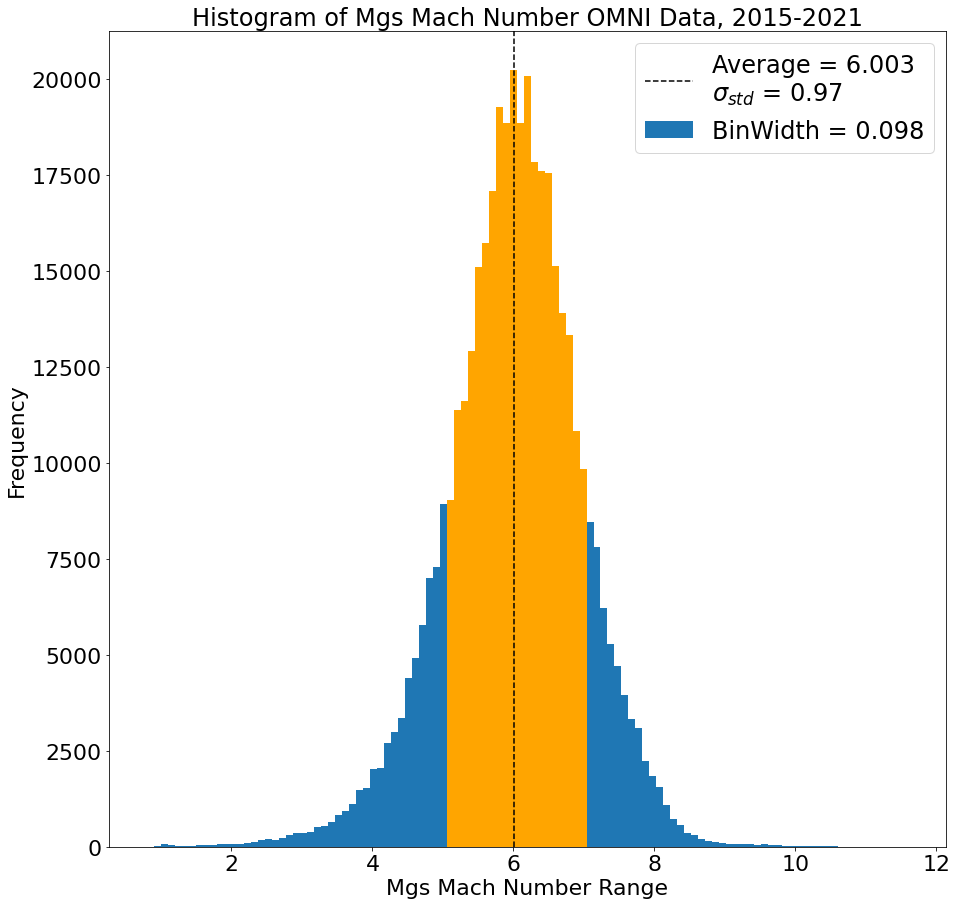

In [29]:
def hist_data_binwidth(afData,binwidth):
# Creates histogram of inputted data with user defined bin width
    if binwidth == 'auto': # Make histogram with default bin size
        nCounts, bin_edges, patches = plt.hist(afData, bins = 'auto')#, alpha = 0.70)
    else: #Make histogram with user's binwidth
        nCounts, bin_edges, patches = plt.hist(afData, bins = 
                   np.arange(np.nanmin(afData),np.nanmax(afData) + binwidth, binwidth))#, alpha = 0.70)
    return(nCounts, bin_edges, patches);


def main_Histing_bulk(afData,achOpt, achName):
    """With above inputs, histogram bulk SW data"""
    Data_combine = afData[~np.isnan(afData)] #re-define data array without nan-values
    print('Length of combined trimmed data arrays is %d' %len(Data_combine))
    plt.figure(figsize = (15,15))
    DataRange = np.nanmax(Data_combine) - np.nanmin(Data_combine)
    Binwidth = 0.099
    if achOpt == 'MGS': #bulk hists MGSmach with 0.099 binwidth
        nCounts, bin_edges, patches = hist_data_binwidth(Data_combine,0.099)
        #plt.axvline(5,color = 'pink', linestyle = '-')
        #plt.axvline(7,color = 'pink', linestyle = '-')
        #print(bin_edges[:20])
        mgs_color_bars(nCounts, bin_edges, patches)

    elif data_name[0][:5] == 'Alf': #bulk hists AlfMach with 0.5 binwidth
        #Setting bin width to 0.5 helps rid plot of gaps even when the xrange is limited to 0 to 100
        nCounts, bin_edges, patches = hist_data_binwidth(Data_combine, 0.5)
        plt.xlim([-1, 50]) #bin_edges[-1]+10])
        ##Default xscale looks funky cause max(Alf_combined) is ~350
    else:
        nCounts, bin_edges, patches = plt.hist(Data_combine,bins='auto') #ec = 'grey'
    fsize = 22
    legsize = 24
    avg_value = np.average(Data_combine) #Computes average of inputted data array
    std_value = np.std(Data_combine) #Computes standard of inputted data array
    plt.axvline(avg_value,color = 'k', linestyle = '--')
    plt.title('Histogram of %s OMNI Data, 2015-2021' %achName, fontsize = 24)
    plt.xticks(fontsize = fsize)
    plt.yticks(fontsize = fsize)
    plt.xlabel('%s Range' %achName, fontsize = fsize)
    plt.ylabel('Frequency', fontsize = fsize)
    plt.legend(labels = ['Average = %0.3f\n$\sigma_{std}$ = %0.2f' %(avg_value,std_value),
                     'BinWidth = %0.3f' %(DataRange/len(nCounts))],loc = 'best', prop={'size': legsize})
    #print('Histing with lines of code takes %0.4f s \nwhereas using my predefined function takes %0.4f s'%( (e1-s1), (e2-s2) ) )
    return

def mgs_color_bars(hcounts, hbin, hpatch):
#Colors histogram patches of specific count number interval
    for i in range(len(hbin)-1): #remember counts and patches have same length, but bins has len(counts)+1
        if hbin[i] >= 5 and hbin[i] <= 7:
        #if  hcounts[i] >= 0.20:
            hpatch[i].set_fc('orange')
    return;

"""For AGU poster: I set plot line and axes labels to a 18pt fontsize, title with a 20pt fontsize,
and (15,15) figsize
ver3: 20pt axes labels and 24pt font title, and 16pt axes ticks

(recent)ver4: axis label tick share same 20 fontsize; title and legend being 24 fontsize

"""

#---------------Main Calling Below---------------------
#########################Main Function################3
def major_bulk_hist(df_SWbulk):
    """Create (2015-21) Bulk Histogram for a specific or all OMNI Solar Wind Parameters"""
    print('Creating Bulk SWParam Hist from:\n', namestr(df_SWbulk,globals()) )
    #Extract copies of 2015-21 SW Param data arrays
    afBx_bulk = df_SWbulk['BXgse(nT)'].to_numpy(copy=True)
    afBy_bulk = df_SWbulk['BYgsm(nT)'].to_numpy(copy=True)
    afBz_bulk = df_SWbulk['BZgsm(nT)'].to_numpy(copy=True)
    afBmag_bulk = df_SWbulk['Bmag(nT)'].to_numpy(copy=True)
    #-
    afFlow_bulk = df_SWbulk['Flowv(km/s)'].to_numpy(copy=True)
    afDen_bulk = df_SWbulk['Pden(1/cc)'].to_numpy(copy=True)
    #-
    afPress_bulk = df_SWbulk['Flow_P(nPa)'].to_numpy(copy=True)
    afAlfmach_bulk = df_SWbulk['AlfMach'].to_numpy(copy=True)
    afMGSmach_bulk = df_SWbulk['MGSmach'].to_numpy(copy=True)
    #--Creating Bulk Histograms
    #main_Histing_fullYr(afBx_yr1,afBx_yr2, afBx_yr3, afBx_yr4, afBx_yr5, '$B_x$')
    #plt.savefig('bulkhist_Bx.png',facecolor = 'w', bbox_inches='tight') #Saving as a png
    #main_Histing_fullYr(afBy_yr1,afBy_yr2, afBy_yr3, afBy_yr4, afBy_yr5, '$B_y$ GSM')
    #plt.savefig('bulkhist_By.png',facecolor = 'w', bbox_inches='tight') #Saving as a png
    #main_Histing_fullYr(afBz_yr1,afBz_yr2, afBz_yr3, afBz_yr4, afBz_yr5, '$B_z$ GSM')
    #plt.savefig('bulkhist_Bz.png',facecolor = 'w', bbox_inches='tight') #Saving as a png
    #main_Histing_fullYr(afBmag_yr1, afBmag_yr2, afBmag_yr3, afBmag_yr4, afBmag_yr5, '$B_{mag}$')
    #plt.savefig('bulkhist_Bmag.png',facecolor = 'w', bbox_inches='tight') #Saving as a png

    #main_Histing_fullYr(afFlow_yr1,afFlow_yr2, afFlow_yr3, afFlow_yr4, afFlow_yr5, 'Flow Speed')
    #plt.savefig('bulkhist_flowv.png',facecolor = 'w', bbox_inches='tight') #Saving as a png
    #main_Histing_fullYr(afDens_yr1,afDens_yr2, afDens_yr3, afDens_yr4, afDens_yr5, 'Ion Density')
    #plt.savefig('bulkhist_pdensity.png',facecolor = 'w', bbox_inches='tight') #Saving as a png

    #main_Histing_fullYr(afPressure_yr1,afPressure_yr2, afPressure_yr3, afPressure_yr4, afPressure_yr5, 'Flow Pressure')
    #plt.savefig('bulkhist_flowpress.png', facecolor = 'w',bbox_inches='tight') #Saving as a png
    #main_Histing_fullYr(afAlf_mach_yr1,afAlf_mach_yr2, afAlf_mach_yr3, afAlf_mach_yr4, afAlf_mach_yr5, 'Alfven Mach Number')
    #plt.savefig('bulkhist_alfmach_setaxis.png', facecolor = 'w',bbox_inches='tight') #Saving as a png
    
    main_Histing_bulk(afMGSmach_bulk,'MGS', 'Mgs Mach Number')
    #plt.savefig('Sheathpaper_bulkhist_mgs_2015to21_v1.png', facecolor = 'w',bbox_inches='tight') #Saving as a png
    
# Plotting Bulk hists of SW parameters
major_bulk_hist(df_SWDay_2015to21)  

Creating Bulk SWParam Hists from:
 ['df_SWDay_2015to21']
		Confirmed: Created DFs MgsMach# falls betwen 5.00 and 7.00
			With AlfMach# between 2.20 and 351.70

Plotting stuff with:  [] []
Length of FlowSpeed array:  316588
408.46674
7.0025144


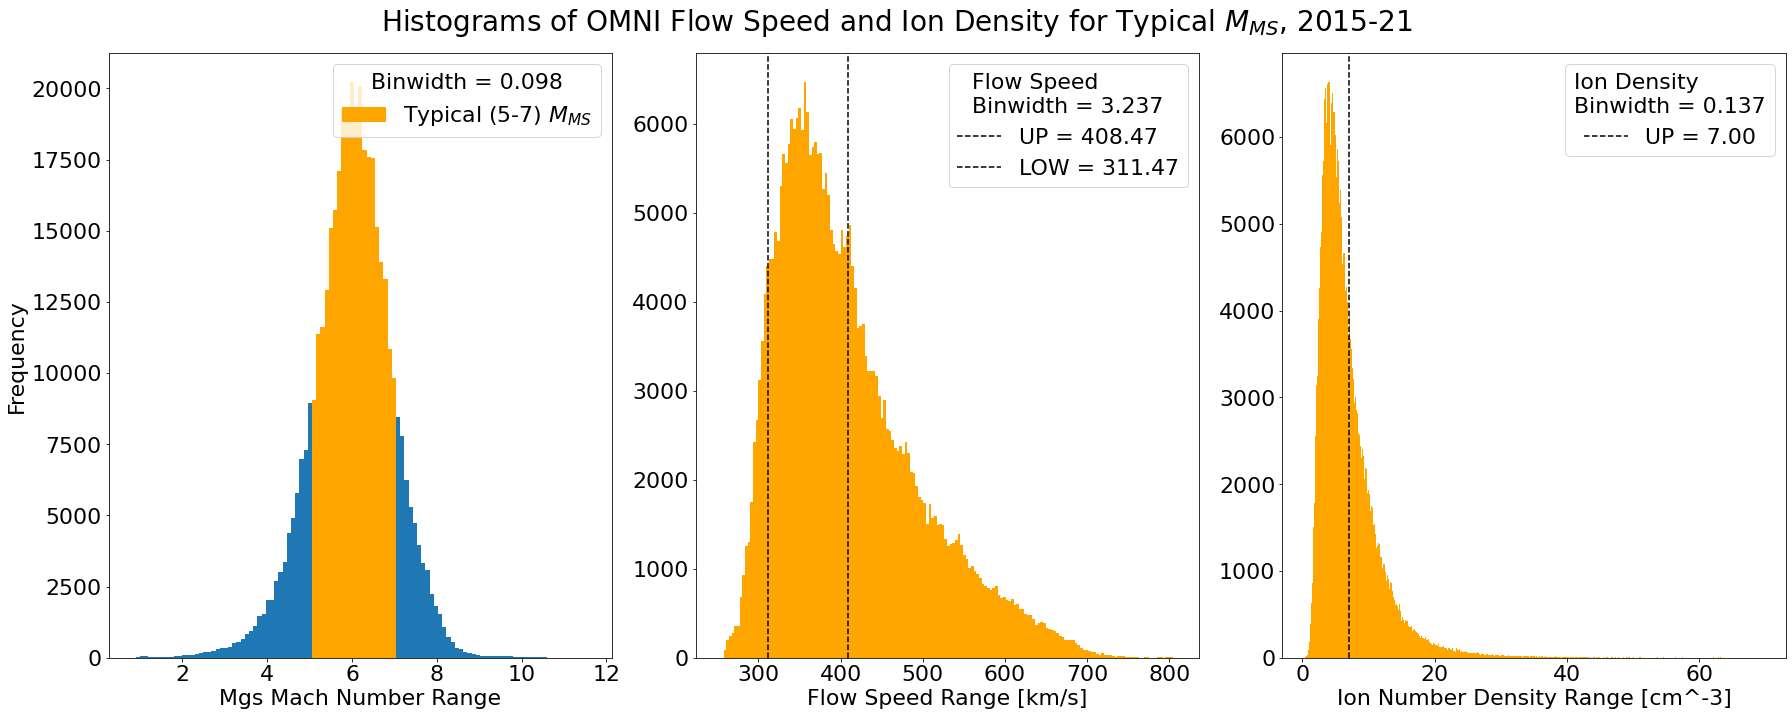

In [34]:
#####Histing Bulk 5 Yr Mgs Mach Number and Corresponding SW Flow Speed (4-5-2022)----------
def AX_hist_data_binwidth(ax, afData,binwidth):
    """Created histogram of inputted data with user defined binwidth and 'ax' plot object"""
    if binwidth == 'auto': # Make histogram with default bin size
        nCounts, bin_edges, patches = ax.hist(afData, bins = 'auto')#, alpha = 0.70)
    else: #Make histogram with user's binwidth
        nCounts, bin_edges, patches = ax.hist(afData, bins = 
                   np.arange(np.nanmin(afData),np.nanmax(afData) + binwidth, binwidth))#, ec = 'grey')#, alpha = 0.70)
    return(nCounts, bin_edges, patches);

def AX_colorhist_data_binwidth(ax, afData,binwidth, histcolor):
    """Created histogram of inputted data with user defined binwidth and 'ax' plot object"""
    if binwidth == 'auto': # Make histogram with default bin size
        nCounts, bin_edges, patches = ax.hist(afData, bins = 'auto', fc = histcolor)#, alpha = 0.70)
    else: #Make histogram with user's binwidth
        nCounts, bin_edges, patches = ax.hist(afData, bins = 
                   np.arange(np.nanmin(afData),np.nanmax(afData) + binwidth, binwidth), fc = histcolor)#, ec = 'grey')#, alpha = 0.70)
    return(nCounts, bin_edges, patches);

def mgs_color_barsV2(hcounts, hbin, hpatch):
#Colors histogram patches of specific count number interval
    for i in range(len(hbin)-1): #remember counts and patches have same length, but bins has len(counts)+1
        if hbin[i] >= 5 and hbin[i] <= 7:
            nMgs = i
            hpatch[i].set_fc('orange')
    #set label name for all colored hist patches
    hpatch[nMgs].set_label('Typical (5-7) $M_{MS}$') 
    return;


def combine_5yr_data(afData1, afData2, afData3, afData4, afData5):
    """Concatenates(combines) inputted 5 years of whatever OMNI nantrimmed data into a single array"""
    print('\nArrays to be combined:\n', namestr(afData1, globals()),namestr(afData2, globals()),
         namestr(afData3, globals()),namestr(afData4, globals()),namestr(afData5, globals()) )
    # Redefine data arrays without the nan-values and define a combined data array
    Data1Trim = afData1[~np.isnan(afData1)]
    Data2Trim = afData2[~np.isnan(afData2)]
    Data3Trim = afData3[~np.isnan(afData3)]
    Data4Trim = afData4[~np.isnan(afData4)]
    Data5Trim = afData5[~np.isnan(afData5)]
    Data_combine = np.concatenate((Data1Trim,Data2Trim,Data3Trim,Data4Trim,Data5Trim))
    #Displaying details about the data arrays(excluding nan-values) that are to be combined
    print('(Excluding nan)The respective array lengths of myData1 to myData5 are: %d, %d, %d, %d, %d' 
          %(len(Data1Trim), len(Data2Trim), len(Data3Trim), len(Data4Trim), len(Data5Trim) ) )
    print('Length of combined trimmed data arrays is %d' %len(Data_combine))
    return(Data_combine);

def combine_5yr_nan(afData1, afData2, afData3, afData4, afData5):
    """Concatenates(combines) inputted 5 years of whatever OMNI non-nantrimmed data into a single array"""
    print('\nArrays to be combined:\n', namestr(afData1, globals()),namestr(afData2, globals()),
         namestr(afData3, globals()),namestr(afData4, globals()),namestr(afData5, globals()) )
    Data_combine = np.concatenate((afData1, afData2, afData3, afData4, afData5))
    #Displaying details about the data arrays(excluding nan-values) that are to be combined
    print('The respective array lengths of myData1 to myData5 are: %d, %d, %d, %d, %d' 
          %(len(afData1), len(afData2), len(afData3), len(afData4), len(afData5) ) )
    print('Length of combined trimmed data arrays is %d' %len(Data_combine))
    return(Data_combine);

def get_mgs_flowDF(afFlow_og, afMgs_og, afTime_og, afDen_og, afAlf_og):
    """Create DataFrame from Flow Speed, Mgs Mach, Ion Density, and original Time data arrays; trim out rows 
    that don't belong to Stable Regime(Mgs = 5to7);and return FlowSpeed/Density arrays that corresponds 
    to MgsMach# = 5 to 7"""
    Time_str = time_string(afTime_og) #convert unix time to string format
    #print(len(afFlow_og), len(afMgs_og), len(afTime_og), len(Time_str))
    #--Defining DF with original Flow Speed, Mgs Mach Num, Alfmach,  and Time data array
    test_dict = {'Time(unix)': afTime_og, 'Flow Speed(km/s)': afFlow_og,'MgsMach': afMgs_og, 
             'Ion Density(1/cc)': afDen_og,'AlfMach': afAlf_og, 'Time(str)':Time_str}
    df_flowmgs = pd.DataFrame(test_dict)
    #display(df_flowmgs)
    nDrop_idx = np.array([]) #initialize empty drop index arrays
    for i in range(len(afMgs_og)):
        if afMgs_og[i] < 5 or afMgs_og[i] > 7: #finds indices where MgsMach# doesn't fall between 5 to 7
            nDrop_idx = np.append(nDrop_idx, i)
    # Redefine new dataframes by dropping rows whose MgsMach# doesn't fall between 5 to 7
    df_cop = df_flowmgs.copy(deep = True) #creating copy of CurrMECcosine datframe
    df_cop = df_cop.drop(nDrop_idx) #dropping DF rows that dont have Mgsmach# = 5to7
    df_cop = df_cop.reset_index(drop=True) # reset index# column for new DF
    #display(df_cop)
    #Checks if respective MgsMach-column array falls between 5 and 7
    afmgsNum = df_cop['MgsMach'].to_numpy(copy=True)
    afFlowDF = df_cop['Flow Speed(km/s)'].to_numpy(copy=True)
    afDenDF = df_cop['Ion Density(1/cc)'].to_numpy(copy=True)
    afAlfnum = df_cop['AlfMach'].to_numpy(copy=True)
    FlowTrim = afFlowDF[~np.isnan(afFlowDF)] #***Confirmed that this matches FlowNAN Trimmed DF length down below
    DenTrim = afDenDF[~np.isnan(afDenDF)] #***Confirmed that FlowNAN and DenNAN locations are the same 
    AlfTrim = afAlfnum[~np.isnan(afAlfnum)] #***Confirmed that FlowNAN and DenNAN locations are the same 
    #display(df_cop)
    print('\t\tConfirmed: Created DFs MgsMach# falls betwen %0.2f and %0.2f'%(np.nanmin(afmgsNum), np.nanmax(afmgsNum)))
    print('\t\t\tWith AlfMach# between %0.2f and %0.2f'%(np.nanmin(afAlfnum), np.nanmax(afAlfnum)))
    '''
    anFlowNAN = np.argwhere(np.isnan(afFlowDF))
    nDropFlownan_idx = np.array([]) #initialize empty drop index arrays
    for i in range(len(anFlowNAN)):
        nDropFlownan_idx = np.append(nDropFlownan_idx,(anFlowNAN[i,0]))
    #print(anMgsNAN[:10])
    #print(type(int(nDropmgsnan_idx[0])))
    #print(type(anMgsNAN[1][0]))
    #Drop new FlowSpeed nan locations from MgsMach5to7 DF
    """Confirmed:defining two different named DFS that dropped different indices doesn not affect the OG CopyDF"""
    df_cop2 = df_cop.copy(deep = True) #creating copy of CurrMECcosine datframe
    df_Flowcop = df_cop2.drop(nDropFlownan_idx) #dropping DF rows that have Mgs nanvals
    df_Flowcop = df_Flowcop.reset_index(drop=True) # reset index# column for new DF
    print('Len of FLowSpeed_5to7mgsmach is %d'%len(FlowTrim))
    display(df_Flowcop)
    ''';
    return(FlowTrim, DenTrim,AlfTrim);

def hist_mgs_and_flow(afFlow, afMgs, afDen, achTitle):
    """Histing Yrs1-6(2015-21) Mgs Mach Number, Flow Speed, and Ion Density"""
    print('\nPlotting stuff with: ',namestr(afFlow, globals()), namestr(afMgs, globals()))
    print('Length of FlowSpeed array: ', len(afFlow))#, len(afFlow2))
    ##Create histogram--------------------------
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (25, 10)) #setting size of subplots
    fig.suptitle(achTitle, y =0.99,fontsize = 28) #single title over multiple subplots
    """For 1x2 Subplots: figsize = (15,10), title size =24, axis label/tick size = 20, legend font = 18
    For 1x3 Subplots: figsize = (25,12), title size =24, axis label/tick size = 20, legend font = 14
    For 1x24 Subplots: figsize = (35,12), title size =24, axis label/tick size = 24, legend font = 14
    For 2x2 Subplots: figsize = (20,22), title size =28, axis label/tick size = 24, legend font = 22"""
    fsize = 22 #fontsize of axis labels/ticks
    legsize = 22 #legend fontsize
    #--MgsMach Hist--
    nMgs_ct, Mgsbins, Mgspatch = AX_hist_data_binwidth(ax1, afMgs,0.099) #Mgs Mach has binwidth of 0.099
    ax1.tick_params(axis='x', labelsize=fsize) #setting axes tick labelsize
    ax1.tick_params(axis='y', labelsize=fsize)
    ax1.set_ylabel('Frequency', fontsize = fsize)
    ax1.set_xlabel('Mgs Mach Number Range', fontsize = fsize)#, loc = 'right')
    Mgs_range = np.nanmax(afMgs) - np.nanmin(afMgs)
    Mgs_BW = Mgs_range/len(nMgs_ct) #confirming inputting bin width for histed Mgs data
    mgs_color_barsV2(nMgs_ct, Mgsbins, Mgspatch) #coloring histbars between 5-7 Mgs Mach Num
    ax1.legend(title = 'Binwidth = %0.3f'%Mgs_BW, title_fontsize = legsize, loc = 'best', prop={'size': legsize})
    #--FlowSpeed Hist--
    nFlow_ct, Flowbins, Flowpatch = ax2.hist(afFlow, bins = 'auto',fc = 'orange')
    #nFlow_ct, Flowbins, Flowpatch = AX_hist_data_binwidth(ax2, afFlow,'auto')
    ax2.tick_params(axis='x', labelsize=fsize) #setting axes tick labelsize
    ax2.tick_params(axis='y', labelsize=fsize)
    #ax2.set_ylabel('Frequency', fontsize = fsize)
    ax2.set_xlabel('Flow Speed Range [km/s]', fontsize = fsize)#, loc = 'right')
    ax2.axvline(np.mean(afFlow),color = 'k', linestyle = '--', label = 'UP = %0.2f'%(np.mean(afFlow)))
    print(np.mean(afFlow))
    ax2.axvline(np.mean(afFlow)-100+3,color = 'k', linestyle = '--', label = 'LOW = %0.2f'%(np.mean(afFlow)-100+3))
    Flow_range = np.nanmax(afFlow) - np.nanmin(afFlow)
    Flow_BW = Flow_range/len(nFlow_ct) #confirming inputting bin width for histed Flow data
    achFlow = 'Flow Speed\nBinwidth = %0.3f'%Flow_BW
    ax2.legend(title = '%s'%achFlow, title_fontsize = legsize, loc = 'best', prop={'size': legsize})
    #--IonDensity Hist--
    nDen_ct, Denbins, Denpatch = ax3.hist(afDen, bins = 'auto',fc = 'orange')
    ax3.tick_params(axis='x', labelsize=fsize) #setting axes tick labelsize
    ax3.tick_params(axis='y', labelsize=fsize)
    #ax3.set_ylabel('Frequency', fontsize = fsize)
    ax3.set_xlabel('Ion Number Density Range [cm^-3]', fontsize = fsize)#, loc = 'right')
    ax3.axvline(np.mean(afDen),color = 'k', linestyle = '--', label = 'UP = %0.2f'%(np.mean(afDen)))
    print(np.mean(afDen))
    #ax2.axvline(np.mean(afFlow)-100,color = 'k', linestyle = '--', label = 'LOW = %0.2f'%(np.mean(afFlow)-100))
    Den_range = np.nanmax(afDen) - np.nanmin(afDen)
    Den_BW = Den_range/len(nDen_ct) #confirming inputting bin width for histed Flow data
    achDen = 'Ion Density\nBinwidth = %0.3f'%Den_BW
    ax3.legend(title = '%s'%achDen, title_fontsize = legsize, loc = 'best', prop={'size': legsize})
    '''
    #--Alfmach Hist--
        #Setting bin width to 0.5 helps rid plot of gaps even when the xrange is limited to 0 to 100
    nAlf_ct, Alfbins, Alfpatch = AX_colorhist_data_binwidth(ax4, afAlf,0.5, 'orange') #AlfMach has binwidth of 0.5
    ax4.set_xlim([-1, 50]) #bin_edges[-1]+10]),Default xscale looks funky cause max(Alf_combined) is ~350
    ax4.tick_params(axis='both', labelsize=fsize) #setting labelsize for both axis ticks
    ax4.set_xlabel('Alfven Mach Number Value Range', fontsize = fsize)#, loc = 'right')
    alf_std = np.nanstd(afAlf)
    Alf_range = np.nanmax(afAlf) - np.nanmin(afAlf)
    Alf_BW = Alf_range/len(nAlf_ct) #confirming inputting bin width for histed Alf data
    achAlf = 'AlfMach\nBinwidth = %0.3f'%Alf_BW
    ax4.legend(title = '%s\nstd = %0.3f'%(achAlf,alf_std), title_fontsize = legsize, loc = 'best', prop={'size': legsize})
    ''';
    plt.tight_layout()
    return;

def nan_trim(afData):
    """Re-define and return inputted data array without nan-values"""
    DataTrim = afData[~np.isnan(afData)] #re-define data array without nan-values
    return(DataTrim);


#--------------Main Below--------------

def main_flowspeed_mgs_hist(df_SWbulk):
    """Create Bulk Hist of Mgs Mach Number and Flow Speed. Where Flow Speed and Ion Density correspond to
    the 5-7 Mgs Mach range"""
    print('Creating Bulk SWParam Hists from:\n', namestr(df_SWbulk,globals()) )
    #Extract copies of Yrs1-6(2015-21) OMNI SW data
    afTime_OG16 = df_SWbulk['Utime'].to_numpy(copy=True)
    afFlow_OG16 = df_SWbulk['Flowv(km/s)'].to_numpy(copy=True)
    afDen_OG16 = df_SWbulk['Pden(1/cc)'].to_numpy(copy=True)
    afAlfmach_OG16 = df_SWbulk['AlfMach'].to_numpy(copy=True)
    afMGSmach_OG16 = df_SWbulk['MGSmach'].to_numpy(copy=True)
    #Returns Yrs1-6 FlowSpeed array that corresponds to MgsMach# = 5to7 and trims out it's nan values
    [afFlow16_mgs5to7, afDen16_mgs5to7, afAlf16_mgs5to7] = get_mgs_flowDF(afFlow_OG16, afMGSmach_OG16, afTime_OG16, afDen_OG16, afAlfmach_OG16)

    #-Trimming nanvalues and creating hists which correspond to MgsMach# 5to7
    afMgs_16 = nan_trim(afMGSmach_OG16)
    
    #print(len(afUTime_yr1), len(afMag_mach_yr1), len(afFlow_yr1))
    #hist_mgs_and_flow(afFlow_15, afMgs_15, afDen_15,'Hist of Mgs Mach & Flow Speed OMNI Data for 2015-20') 
    #plt.savefig('forRick_Hist_Mgs_BothFlowSpeed', facecolor = 'w',bbox_inches='tight') #Saving as a png
    
    hist_mgs_and_flow(afFlow16_mgs5to7, afMgs_16, afDen16_mgs5to7,'Histograms of OMNI Flow Speed and Ion Density for Typical $M_{MS}$, 2015-21')
    #plt.savefig('Sheathpaper_bulkhist_2015to21_Mgs5to7_mgsFlowSpeednDensity_v1', facecolor = 'w',bbox_inches='tight') #Saving as a png

    return;

main_flowspeed_mgs_hist(df_SWDay_2015to21)

### Reminder about Observations with OMNI DATA
* **(confirmed)B-field components and magnitude share same nan-value locations[which includes the IMF clock angle]** 
    * Sadly Mgs mach number doesn't share same nan-value array indices
* Flow speed and proton density arrays share nan-value locations


In [13]:
def get_trim_time(afUtime, afBmag):
#Reconstruct/return time array by omitting indices that correspond to Bmag's nanvalue elements
    anBnan = np.argwhere(np.isnan(afBmag)) #define array of indices for Bmag's nan-values
    #print('\nBmag with nan-values(original):\n', afBmag[:20])
    #print('\nTime array(original):\n', afUtime[:20])
    #print("\nBmag's array of nan-value indices[length = %d]:\n"%(len(anBnan)), anBnan)
    #print((anBnan[:5,0]))
    #print(anNan[:5])
    #print(type(afUtime[0]))
    '''
    For some reason, redefining the elements of the afUtime permanently affects it inside and outside the function
    As such, we'll define an array copy to take it's place for modifications
    '''
    # Defining copy of the time array with Bmag's nanvalue locations(errors occur with modifying orginal)
    time_nan = copy.deepcopy(afUtime) #create copy of array(can modify copy without affecting the original array)
    #time_nan = time_nan/1e9
    # Map Bmag's nan value locations by redefining corresponding time_nan elements as nan-values
    for i in range(len(anBnan)):
        time_nan[anBnan[i,0]] = np.nan #Matches Bmag's nanvalue location to the time array
    #Displaying OG time and nan-time arrays
    #print("\nEnsuring OG Time array wasn't modified:\n", afUtime[:20])
    #print("\nDUmmy time array with Bmag's nanvalues:\n", time_nan[:20])
    #Utime_str = time_string(afUtime)
    #time_nan_trim = time_nan[~np.isnan(time_nan)]
    #TimenanTrim_str = time_string(time_nan_trim)
    #print("\nOG Time array as a string:\n", Utime_str[0:20])
    #print("\nTime-nan array(trimmed) as a string:\n", (TimenanTrim_str[:20]))
    #Checking if Nan-time and Bmag arrays share same nanvalue locations(they should and do)
    #checkin_nanvals(afBmag, time_nan)
    return time_nan; #returns time array with Bmag's nanvalues at their corresponding index
    
def get_clock_angle(afBy, afBz):
#Computes/returns IMF clock angle in degrees: arctan(By/Bz)
    #Given np.arctan2() returns angle in range (-pi to pi), add 2pi to neg. angle values to have [0, 2pi] range
    clock = np.arctan2(afBy, afBz) #np.arctan(x1,x2) computes as arctan(x1/x2)
    #print('\nClock angle in [-pi,pi] range:\n', clock[:20])
    #print(np.tan(clock[:50]))
    #Converts angle interval to [0, 2pi]
    for i in range(len(clock)):
        if clock[i] < 0: # adding 2pi to negative angle values
            clock[i] = clock[i] + 2*np.pi
    #print('\nClock angle in [0,2pi] range:\n', clock[:20])
    #print(np.tan(clock[:50]))
    '''
    Note: atan(angle) in either [0,2pi] or [-pi,pi] has a very minor discrepancy up to the 5th decimal place
    However, since it's nearly identical it's nothing to worry about
    Also when comparing np or mat.tan() of either angle interval, tan(-pi/2) and tan(3pi/2) yield 
    different values with different signs, so abs( tan(-pi/2)-tan(3pi/2)) becomes LARGE :(
    '''
    #Checking if clock angle shares same nanvalue locations as By or Bz(Bmag and Bcomp share same nanvalues)
    #checkin_nanvals(clock, afBz)
    return np.rad2deg(clock); # will contain nan-values since inputs are not trimmed

def checkin_nanvals(Data1, Data2):
#Checks if input data arrays share the same nan-value locations
#Both Nan-arrays should have same legnth and elements(index locations)
    print('\nData arrays whose nanvalue indices are being compared:\n', 
          namestr(Data1, globals()),namestr(Data2, globals()))
    # Define array of nan-value indices and display their properties
    anNan1 = np.argwhere(np.isnan(Data1)) #define array of indices of nan-values
    anNan2 = np.argwhere(np.isnan(Data2))
    print('Length of anNan1 and anNan2 are respectively %d and %d' %(len(anNan1), len(anNan2)))
    #print('\nanNan1 is\n', anNan1, '\nanNan2 is\n', anNan2)
    # Checks if nan-index arrays are equal(same length and elements) using a built in function and for loop
    print('\nUsing np.array_equal(), the nan-index arrays are equal: %s' %np.array_equal(anNan1, anNan2))
    nCount = 0 #initializing counting variable
    if len(anNan1) == len(anNan2): #check if nan-arrays have same length
        for i in range(len(anNan1)):
            #print('Element %d of both arrays(%d and %d) are equal: %s' %(i, anNan1[i][0], anNan2[i][0], 
            if anNan1[i][0]==anNan2[i][0]: #check if nan-arrays share the same elements
                nCount = nCount + 1
        print('\nUsing a for loop')
        if nCount == len(anNan2):
            print('Both nan-index arrays(same length) share the same elements, and thus same nan-value locations')
        else:
            print('They do not share the same nan-value locations')
    else: #Display for if the lengths are not equal
        print('\nNan arrays are not the same length, and thus do not have the same nanvalue locations')
    return

def stable_mgs_time(afBmag, afUtime, afMgs, clockang):
#Improved and optimized version of check_stable_IMF. In addition to finding intervals of stable IMF events it also
#Looks at where Bmag Time(trimmed) corresponds to Mgs Time array
    #Defining and suaplying entire time interval that's being analyzed
    achStart = time_string(afUtime[0])
    achEnd = time_string(afUtime[-1])
    print('\nAnalyzing IMF Stability and Mgs Mach#(GSM Coord)\nFrom %s to %s'%(achStart[:20], achEnd[:20]))
    n = nCt =nTru =  0 #initialize number of stable events and index variable
    #Defining data arrays that exclude nan values
    nantime = get_trim_time(afUtime, afBmag) #modify time array with Bmag's nan values
    nantime_trim = nantime[~np.isnan(nantime)]
    TimeTrim = np.array(time_string(nantime_trim)) #convert trimmed nantime to from unix to string dates as np arrays
    OGTime = np.array(time_string(afUtime)) #note, only np.arrays work with np.argwhere()
    BmagTrim = afBmag[~np.isnan(afBmag)]
    ClockTrim = clockang[~np.isnan(clockang)]
    fDev = 0.1   # limit of deviation from mean(decimal form)
    fDtheta = 30 #limit of orientation deviation
    while (n+6) <= len(BmagTrim):
        BRange = np.nanmax(BmagTrim[n: n+6]) - np.nanmin(BmagTrim[n: n+6])
        ClockRange = np.nanmax(ClockTrim[n: n+6]) - np.nanmin(ClockTrim[n: n+6])
        BAvg = np.average(BmagTrim[n: n+6])
        Bdeviat = BRange/BAvg # computes percent dataset deviation from the mean
        if Bdeviat <= fDev and ClockRange <= fDtheta: 
            #find index of current Bmag time(trim) element that corresponds to OG time array
            mgs_in =  np.argwhere(OGTime == TimeTrim[n])
            Mgs_avg = np.average(afMgs[mgs_in[0,0]:mgs_in[0,0]+6])
            if Mgs_avg >= 5 and Mgs_avg <= 7: #checks if Mach# avg falls between 5 to 7
                nCt = nCt+1 #increment counter if we have Stable IMF and desired Mach#
                print('\nStable IMF: %0.20s to %0.20s'%(TimeTrim[n], TimeTrim[n+5]))
                print('\twhere Bmag[%d] to Bmag[%d] ='%(n, n+5),BmagTrim[n:n+6],'\n\tMgs Mach# =',
                      afMgs[mgs_in[0,0]:mgs_in[0,0]+6], '\n\tand ClockAng =', ClockTrim[n:n+6])
                print("Good IMF deviation(mag = %0.2f and orientation = %0.2f) and Mach#(%0.2f) by my standards"%(Bdeviat, ClockRange,Mgs_avg))
                print('Corresponding Mgs time: %0.20s to %0.20s\n'%(OGTime[mgs_in[0,0]], OGTime[mgs_in[0,0]+5]))
                #Checks if index correspondence, and thus time intervals between Bmag time(trim) and OG time array match
                # 2 equivalent if-statements
                #if (TimeTrim[n:n+6] == (OGTime[(mgs_in[0,0]) : (mgs_in[0,0]) + 6])).all(): 
                #if np.array_equal( TimeTrim[n:n+6], OGTime[mgs_in[0,0] : mgs_in[0,0] + 6] ):
                #need to use .all() cause np.argwhere() returns an array and causes an error witht the above if statement
                 #   nTru= nTru+1            ##Confirmed that time arrays do match##
        n = n + 1
    print('\nTotal Count of Intervals with Stable IMF and desired Mgs Mach#:', nCt) 
          #'\nDid stable Bmag time ranges match to correct Mgs times:', nTru)
    ###Using list.index() methods, the OGTime[mgs_in] matches with TimeTrim[n]
    ###Using np.argwhere methods, the OGTime[mgs[0,0]] matches with TimeTrim[n]
    return;


### Loading Up Day and Nightside MEC Data from 2015-21

['rmag', 't', 'x', 'y', 'z']

Data arrays whose elements are being compared:
 [] ['yr1_MECtime']
	Lengths of inputted data arrays are respectively 78625 and 78625
	Length of anNan1 and anNan2 are respectively 0 and 0
Both inputted arrays are the same
['2015-09-01 00:00:00.000000', '2015-09-01 00:05:00.000000', '2015-09-01 00:10:00.000000'] 
 ['2016-05-30 23:50:00.000000', '2016-05-30 23:55:00.000000', '2016-05-31 00:00:00.000000'] 
 [57397.53222668 56900.32938682 56394.8117849  55880.85436858
 55358.33059257]

Data arrays whose elements are being compared:
 [] ['yr2_MECtime']
	Lengths of inputted data arrays are respectively 78337 and 78337
	Length of anNan1 and anNan2 are respectively 0 and 0
Both inputted arrays are the same
['2016-09-01 00:00:00.000000', '2016-09-01 00:05:00.000000', '2016-09-01 00:10:00.000000'] 
 ['2017-05-30 23:50:00.000000', '2017-05-30 23:55:00.000000', '2017-05-31 00:00:00.000000'] 
 [75987.17034348 75926.45412658 75860.68585879 75789.85780342
 75713.96164781]

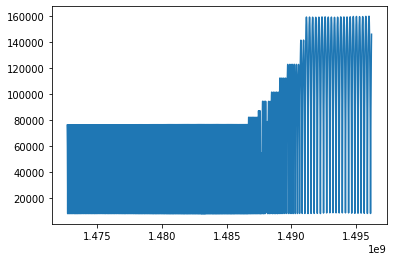

In [14]:
#7-10-21
def compare_arrays(data1, data2):
#Compares arrays that contain nan-values by first comparing nan-value locations and then arrays without nan-vals
## turns out by default (Nan == Nan) returns false by definition, hence this here function
    print('\nData arrays whose elements are being compared:\n', 
          namestr(data1, globals()),namestr(data2, globals()))
    print('\tLengths of inputted data arrays are respectively %d and %d'%(len(data1), len(data2)))
    anNan1 = np.argwhere(np.isnan(data1)) #define array of indices of nan-values
    anNan2 = np.argwhere(np.isnan(data2))
    print('\tLength of anNan1 and anNan2 are respectively %d and %d' %(len(anNan1), len(anNan2)))
    bJustnans = np.array_equal(anNan1, anNan2) #check if nan-value indices are the same
    bNonans = np.array_equal(data1[~np.isnan(data1)], data2[~np.isnan(data2)])#check if arrays w/out nan-values are the same
    if bJustnans == True and bNonans == True: #arrays match for same nan-value locations and matching elements
        print('Both inputted arrays are the same')
    else:
        print('Original and exported arrays are not the same :(')
    return;

def compare_times(df_data, mec_time, mec_rmag):
    """Compare/confirm Dayside OMNI and MEC time arrays; and displaying 1st and last 5-elements of time array"""
    #Extract OMNI time array and compare to mec-time
    afUtime = df_data['Utime'].to_numpy(copy=True)
    compare_arrays(afUtime, mec_time)
    print(time_string(mec_time[:3]),'\n', time_string(mec_time[-3:]), '\n', mec_rmag[:5])
    return;

#---------Fundamental Functions Above--------------
#Load Dayside MEC Data
day_yr1_MECdata = np.load(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/MEC exported Dayside posdata/yr1_MECgsm_posdata.npz')
day_yr2_MECdata = np.load(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/MEC exported Dayside posdata/yr2_MECgsm_posdata.npz')
day_yr3_MECdata = np.load(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/MEC exported Dayside posdata/yr3_MECgsm_posdata.npz')
day_yr4_MECdata = np.load(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/MEC exported Dayside posdata/yr4_MECgsm_posdata.npz')
day_yr5_MECdata = np.load(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/MEC exported Dayside posdata/yr5_MECgsm_posdata.npz')
day_yr6_MECdata = np.load(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/MEC exported Dayside posdata/Dayside_yr6_MECgsm_posdata.npz')

#Extracting Day MEC radial position(km) and time(unix time) arrays
yr6_MECtime = day_yr6_MECdata['t']
yr6_MEC_rmag = day_yr6_MECdata['rmag']
yr5_MECtime = day_yr5_MECdata['t']
yr5_MEC_rmag = day_yr5_MECdata['rmag']
yr4_MECtime = day_yr4_MECdata['t']
yr4_MEC_rmag = day_yr4_MECdata['rmag']
yr3_MECtime = day_yr3_MECdata['t']
yr3_MEC_rmag = day_yr3_MECdata['rmag']
yr2_MECtime = day_yr2_MECdata['t']
yr2_MEC_rmag = day_yr2_MECdata['rmag']
yr1_MECtime = day_yr1_MECdata['t']
yr1_MEC_rmag = day_yr1_MECdata['rmag']


#Load Nightside MEC Data:   Extracting MEC radial position(km) and time(unix time) arrays
#night_yr1_MECdata = np.load(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/MEC exported Nightside posdata/Nightside_yr1_MECgsm_posdata.npz')
#night_yr2_MECdata = np.load(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/MEC exported Nightside posdata/Nightside_yr2_MECgsm_posdata.npz')
#night_yr3_MECdata = np.load(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/MEC exported Nightside posdata/Nightside_yr3_MECgsm_posdata.npz')
#night_yr4_MECdata = np.load(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/MEC exported Nightside posdata/Nightside_yr4_MECgsm_posdata.npz')
#night_yr5_MECdata = np.load(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/MEC exported Nightside posdata/Nightside_yr5_MECgsm_posdata.npz')
#night_yr6_MECdata = np.load(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/MEC exported Nightside posdata/Nightside_yr6_MECgsm_posdata.npz')
#night_yr7_MECdata = np.load(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/MEC exported Nightside posdata/Nightside_yr7_MECgsm_posdata.npz')

print(sorted(day_yr5_MECdata))

compare_times(df_SWDay_yr1, yr1_MECtime, yr1_MEC_rmag)
compare_times(df_SWDay_yr2, yr2_MECtime, yr2_MEC_rmag)
compare_times(df_SWDay_yr3, yr3_MECtime, yr3_MEC_rmag)
compare_times(df_SWDay_yr4, yr4_MECtime, yr4_MEC_rmag)
compare_times(df_SWDay_yr5, yr5_MECtime, yr5_MEC_rmag)
compare_times(df_SWDay_yr6, yr6_MECtime, yr6_MEC_rmag)

#PLotting Radial position v time
plt.plot(yr2_MECtime, yr2_MEC_rmag);

#### (7-12-2021) Omitting Data Gap from Yr5 MEC Data

Omitting Yr5 MECgap from:
 ['df_SWDay_yr5'] ['yr5_MEC_rmag']
Getting GSM comps
78625 78625 78625 78625 78625 78625 78625 78625
Showing Yr5 OGtime array MECgap:
 ['2019-11-25 00:00:00.000000', '2019-11-25 00:05:00.000000'] 
 ['2019-12-06 23:50:00.000000', '2019-12-06 23:55:00.000000', '2019-12-07 00:00:00.000000']
Yr5 MEC data gap occurs at indices 24480 and 27936, or 
string form:	 2019-11-25 00:00:00.000000 ,  2019-12-07 00:00:00.000000 
unix form:	 1574640000.0 ,  1575676800.0


,Utime,BXgse(nT),BYgsm(nT),BZgsm(nT),Bmag(nT),Pden(1/cc),Flowv(km/s),Flow_P(nPa),AlfMach,MGSmach,Time_str
24480,1.574640e+09,-0.20,3.67,-0.07,3.73,4.47,436.299988,1.70,12.4,7.0,2019-11-25 00:00:00.000000
24481,1.574640e+09,1.18,3.76,0.79,4.04,4.12,435.399994,1.56,10.9,6.9,2019-11-25 00:05:00.000000


,Utime,BXgse(nT),BYgsm(nT),BZgsm(nT),Bmag(nT),Pden(1/cc),Flowv(km/s),Flow_P(nPa),AlfMach,MGSmach,Time_str
27934,1.575676e+09,1.86,-3.47,-0.91,4.15,4.33,370.700012,1.19,9.3,5.7,2019-12-06 23:50:00.000000
27935,1.575676e+09,2.39,-2.22,-2.13,4.04,4.62,363.299988,1.22,9.6,5.7,2019-12-06 23:55:00.000000
27936,1.575677e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-07 00:00:00.000000



 Omitting Yr5 MECgap rows
New date range that covers old MEC data gap occurs at indices 24479 and 24480, or
Yr5 Time array no MECgap:
 ['2019-11-24 23:55:00.000000', '2019-12-07 00:05:00.000000', '2019-12-07 00:10:00.000000']


,Utime,BXgse(nT),BYgsm(nT),BZgsm(nT),Bmag(nT),Pden(1/cc),Flowv(km/s),Flow_P(nPa),AlfMach,MGSmach,Time_str
24479,1.574640e+09,0.54,3.49,0.1,3.6,4.54,442.200012,1.78,13.1,7.3,2019-11-24 23:55:00.000000
24480,1.575677e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-07 00:05:00.000000
24481,1.575677e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-07 00:10:00.000000


75168 75168 75168 75168 75168 75168 75168 75168
Omitting Yr5 MECgap from:
 ['df_ShockDay_yr5'] ['yr5_MEC_rmag']
Getting GSE comps
78625 78625 78625 78625 78625 78625 78625 78625
Showing Yr5 OGtime array MECgap:
 ['2019-11-25 00:00:00.000000', '2019-11-25 00:05:00.000000'] 
 ['2019-12-06 23:50:00.000000', '2019-12-06 23:55:00.000000', '2019-12-07 00:00:00.000000']
Yr5 MEC data gap occurs at indices 24480 and 27936, or 
string form:	 2019-11-25 00:00:00.000000 ,  2019-12-07 00:00:00.000000 
unix form:	 1574640000.0 ,  1575676800.0


,Utime,BXgse(nT),BYgse(nT),BZgse(nT),Bmag(nT),Xgse(Re),Ygse(Re),Zgse(Re),Flowv(km/s),MGSmach,Time_str
24480,1.574640e+09,-0.20,3.67,0.05,3.73,233.100006,-39.459999,20.68,436.299988,7.0,2019-11-25 00:00:00.000000
24481,1.574640e+09,1.18,3.73,0.91,4.04,233.089996,-39.459999,20.68,435.399994,6.9,2019-11-25 00:05:00.000000


,Utime,BXgse(nT),BYgse(nT),BZgse(nT),Bmag(nT),Xgse(Re),Ygse(Re),Zgse(Re),Flowv(km/s),MGSmach,Time_str
27934,1.575676e+09,1.86,-3.52,-0.71,4.15,197.149994,63.139999,-6.79,370.700012,5.7,2019-12-06 23:50:00.000000
27935,1.575676e+09,2.39,-2.34,-2.00,4.04,197.149994,63.150002,-6.79,363.299988,5.7,2019-12-06 23:55:00.000000
27936,1.575677e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-07 00:00:00.000000



 Omitting Yr5 MECgap rows
New date range that covers old MEC data gap occurs at indices 24479 and 24480, or
Yr5 Time array no MECgap:
 ['2019-11-24 23:55:00.000000', '2019-12-07 00:05:00.000000', '2019-12-07 00:10:00.000000']


,Utime,BXgse(nT),BYgse(nT),BZgse(nT),Bmag(nT),Xgse(Re),Ygse(Re),Zgse(Re),Flowv(km/s),MGSmach,Time_str
24479,1.574640e+09,0.54,3.48,0.2,3.6,233.100006,-39.459999,20.68,442.200012,7.3,2019-11-24 23:55:00.000000
24480,1.575677e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-07 00:05:00.000000
24481,1.575677e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-07 00:10:00.000000


75168 75168 75168 75168 75168 75168 75168 75168


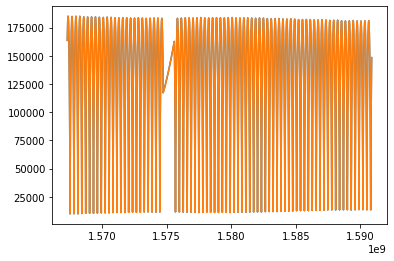

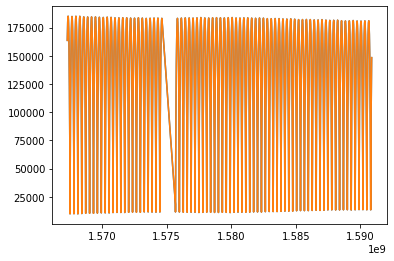

In [15]:
####(7-12-2021)Defining New arrays that take into account the Yr5 MEC data gap by omitting said data range
#### in all corresponding arrays that will use the MEC data
##Said MEC data gap occurs from 11-25-19 to 12-7-19 as confimred in 'Test MMS Survey Data' notebook

def pd_omit_yr5MEC_datagap(df_data, yr5_rmag, yr5_clang, achOpt):
    #(Bmag_yr5, afTime_yr5, afMgs_yr5, yr5_clang, yr5_MECrmag, Bx_yr5, By_yr5 ,Bz_yr5)
    """Omitting time range in all yr5 data arrays that correspond to a discrepancy found in the yr5 MEC data
##Yr5 MEC gapdiscrepancy occurs from 11-25-19 to 12-7-19 as confirmed in test cell"""
    print('Omitting Yr5 MECgap from:\n', namestr(df_data, globals()), namestr(yr5_rmag, globals()))
    #Creating copies of below arrays so I can modify without affecting the original
    yr5_rmag_copy = copy.deepcopy(yr5_rmag)
    yr5_clang_copy = copy.deepcopy(yr5_clang)
    yr5_time_copy = df_data['Utime'].to_numpy(copy=True) #copy.deepcopy(afTime_yr5) 
    yr5_Bmag_copy = df_data['Bmag(nT)'].to_numpy(copy=True) #copy.deepcopy(Bmag_yr5)
    yr5_mgs_copy = df_data['MGSmach'].to_numpy(copy=True) #copy.deepcopy(afMgs_yr5)
    yr5_Bx_copy = df_data['BXgse(nT)'].to_numpy(copy=True) #copy.deepcopy(Bx_yr5)
    if achOpt == 'gse': #extract GSE bcomps
        print('Getting GSE comps')
        yr5_By_copy = df_data['BYgse(nT)'].to_numpy(copy=True) #copy.deepcopy(By_yr5)
        yr5_Bz_copy = df_data['BZgse(nT)'].to_numpy(copy=True) #copy.deepcopy(Bz_yr5)
    else: #extract GSM bcomps
        print('Getting GSM comps')
        yr5_By_copy = df_data['BYgsm(nT)'].to_numpy(copy=True) #copy.deepcopy(By_yr5)
        yr5_Bz_copy = df_data['BZgsm(nT)'].to_numpy(copy=True) #copy.deepcopy(Bz_yr5)
    print(len(yr5_time_copy), len(yr5_rmag_copy), len(yr5_clang_copy), len(yr5_Bmag_copy), len(yr5_mgs_copy), 
          len(yr5_Bx_copy), len(yr5_By_copy), len(yr5_Bz_copy))
    plt.figure(1)
    plt.plot(yr5_time_copy, yr5_rmag_copy)
    love_alter = time_string(yr5_time_copy) #string form of yr5_time_copy
    #Acquiring indices of MEC data gap time range
    ind1 = list(love_alter).index('2019-11-25 00:00:00.000000')
    ind2 = list(love_alter).index('2019-12-07 00:00:00.000000')
    #Displaying Yr5 MECgap data range
    print('Showing Yr5 OGtime array MECgap:\n',love_alter[ind1:ind1+2], '\n', love_alter[ind2-2:ind2+1])
    print('Yr5 MEC data gap occurs at indices %d and %d, or'%(ind1, ind2),
          '\nstring form:\t', time_string(yr5_time_copy[ind1]),', ', time_string(yr5_time_copy[ind2]),
          '\nunix form:\t', yr5_time_copy[ind1],', ', yr5_time_copy[ind2])
    display(df_data[ind1:ind1+2])
    display(df_data[ind2-2:ind2+1])
    #--Omitting MECgap data ranges from arrays
    idx_MECgap = np.arange(ind1, ind2+1) #np.delete needs array of indices to delete desired subarray
    #print(idx_MECgap[-5:])
    #yr5_time_red = np.delete(yr5_time_copy, idx_MECgap)
    yr5_rmag_red = np.delete(yr5_rmag_copy, idx_MECgap)
    yr5_clang_red = np.delete(yr5_clang_copy, idx_MECgap)
    yr5_Bmag_red = np.delete(yr5_Bmag_copy, idx_MECgap)
    yr5_mgs_red = np.delete(yr5_mgs_copy, idx_MECgap)
    yr5_Bx_red = np.delete(yr5_Bx_copy, idx_MECgap)
    yr5_By_red = np.delete(yr5_By_copy, idx_MECgap)
    yr5_Bz_red = np.delete(yr5_Bz_copy, idx_MECgap)
    #--Omitting Yr5 MECgap from inputted DF
    df_cop = df_data.copy(deep = True) #create copy of inputted data DF
    print('\n Omitting Yr5 MECgap rows')
    df_cop = df_cop.drop(idx_MECgap) #dropping Yr5 MECgap rows
    df_cop = df_cop.reset_index(drop=True) #Reset index# column for new DF
    #--
    yr5_time_red = df_cop['Utime'].to_numpy(copy=True) #copy.deepcopy(afTime_yr5) 
    love_alter_red = time_string(yr5_time_red) #string form of yr5_time_red
    plt.figure(2)
    plt.plot(yr5_time_red, yr5_rmag_red)
    #FInding new corresponding date range of omitted MECgap
    ind3 = list(love_alter_red).index('2019-11-24 23:55:00.000000')
    ind4 = list(love_alter_red).index('2019-12-07 00:05:00.000000')
    #Displaying new date range of omitted MECgap
    print('New date range that covers old MEC data gap occurs at indices %d and %d, or'%(ind3, ind4))
    print('Yr5 Time array no MECgap:\n',love_alter_red[ind3:ind4+2])
    display(df_cop[ind3:ind4+2])
        ##Confirmed new omitted date range goes from 11-24-19 directly to 12-7-19 00:05:00
    print(len(yr5_time_red), len(yr5_rmag_red), len(yr5_clang_red), len(yr5_Bmag_red), len(yr5_mgs_red), 
          len(yr5_Bx_red), len(yr5_By_red), len(yr5_By_red))

    return(df_cop, yr5_clang_red, yr5_rmag_red);



####-----------------------------MainBelow--------------------------------

#--Defining Dayside Yr5 IMF Clock Angle
afByDay_yr5 = df_SWDay_yr5['BYgsm(nT)'].to_numpy(copy=True)
afBzDay_yr5 = df_SWDay_yr5['BZgsm(nT)'].to_numpy(copy=True)
clockang_Dayyr5 = get_clock_angle(afByDay_yr5, afBzDay_yr5)
#---
[df_SWDay_noGap_yr5, yr5_SWclang_noGAP, yr5_SWMECrmag_noGAP] = pd_omit_yr5MEC_datagap(df_SWDay_yr5, yr5_MEC_rmag, clockang_Dayyr5, 'gsm')



[df_ShockDay_noGap_yr5, yr5_SHclang_noGAP, yr5_SHMECrmag_noGAP] = pd_omit_yr5MEC_datagap(df_ShockDay_yr5, yr5_MEC_rmag, clockang_Dayyr5, 'gse')



### Pandas Optimized Sorting:
* Creating Yearly Lists that use 30min Filter Feature
* Then use Pandas functions to sort yearly list by clockang orientations. Or described succinlty as 
    * Implemented a yearly categorized search for 30 minute **time intervals** based on stable IMF criteria and desired Mgs Mach# of 5to7. 
        * Stability criteria: IMF orientation $\Delta\theta < 30^o$ and IMF mag doesn't vary more than 10% from the mean
    * Sorted categories based on avg IMF orientation and radial position restricted to 7to24Re
    * IMF Orientations:
        * Southward $B_z$: $\theta_{avg,IMF} \geq 135^o$ and $< 225^o$
        * Positive $B_y$-led: $\theta_{avg,IMF} \geq 45^o$ and $< 135^o$
        * Negative $B_y$-led: $\theta_{avg,IMF} \geq 225^o$ and $< 315^o$
        * Northward $B_z$: $\theta_{avg,IMF} \geq 315^o$ and $< 45^o$
            * reference to IMF ClockAng Diagram: https://www.sws.bom.gov.au/Category/Solar/Solar%20Conditions/Solar%20Wind%20Clock%20Angle/Solar%20Wind%20Clock%20Angle.php

---
#### A Mention on the Implemented Shock Normal Angle Formula
* After being referred to a version of the model in the cluster book[“Analysis Methods for Multi-Spacecraft Data”. Please see Table 10.1 at page 261] and his personal IDL code version. I will be adapting his code into Python to plot the bowshock and compute the shock normal angle
    * Shock Normal Angle: $cos\theta_{bn} = \hat{n_{BS}}\cdot\vec{B_{IMF}}$
        * quasi-perp shock: $\theta_{bn} \geq 45^o$
        * quasi-parallel shock: $\theta_{bn} < 45^o$
* **(8-3-2022):**
    * The cluster describes Peredo's 1995 Bowshock Model in a 'symmetric conic section' coord system
        * Where $L/r_{abd} = (1 +\epsilon cos\theta_{abd})$ with the transform $\vec{r}_{abd} = T\vec{r}_{gse}-\vec{r}_0$; which are [Eqns 10.22-23]
        * Sigma scaling factor quadratic eqn: $A\sigma^2 + B\sigma + C$ = 0
            * where A = $r_0^2 -(L+\epsilon x_0)^2$<br>B = 2[$\epsilon x_1(L+\epsilon x_0) - (r_0\cdot r_1)$]  <br>and C = $r_1^2 -(\epsilon x_1)^2$
        * **Bowshock Model scaled to Observed Crossing Location:** <br> $\vec{r}_{abd} = T\vec{r}_{cross}-\sigma\vec{r}_0$
            * Starting with GSE coord, an aberrated version(conic coord system)[Eqn 10.22-23] is used to display said model and compute the shock normal. The $\alpha$(in degrees) parameter is computed from $tan\alpha = (30km/s)/v_{sw}$
* **(8-19-22):**
    *  As discussed with Mitsuo(8-3-22), he chooses his scaling factor to be sig_neg. 'Since I think it should be okay because "AA" is usually negative (because the focus of the conic is closer to Earth) and "sigm" is usually positive whereas "sigp" is negative.'
        * As such, I'll choose the same root to be my scaling factor
    * As confirmed in my discussions with Mitsuo, **the normal vector outward to the bowshock surface** is what's used in the calculation of the shock normal angle
        * From the bowshock model's coding implementation and quiver-vector plots, it appears that the outward normal vector is defined by $\hat{n}_{BS} = -norm(\nabla{S})$
        * Additionally, the maximum possible value for the shock normal angle is $90^o$. So if the angle exceeds that max value, then we'd merely have to reverse the direction of the IMF vector or take the absolute difference with it and $180^o$
            * Say the coded shock normal angle is $150^o$. We could say that true the shock norm angle is |150-180| = $30^o$. Which would give the same result if we reversed the IMF vector.
            
* (~10-31-2022)
    * Rick asked that I pull up some stable SW events for time intervals with Mgs Mach Num < 3 to see if the Lopez picture is still resolved

In [16]:
def pd_list_shang_sorting(df_data, clockang, MECrmag, nChoice):
    #(afBmag, afUtime, afMgs, clockang, MECrmag, afBx, afBy, afBz,nChoice):
    """Finding stable IMF events with Shock Angle that are sorted by ClockAng based on user's choice"""
    #-Extracting copies of data arrays from inputted DF; Bcomps need to be in GSE for Shock Angle Formula
    afUtime = df_data['Utime'].to_numpy(copy=True)
    afBmag = df_data['Bmag(nT)'].to_numpy(copy=True)
    afMgs = df_data['MGSmach'].to_numpy(copy=True)
    afBx = df_data['BXgse(nT)'].to_numpy(copy=True)
    afBy = df_data['BYgse(nT)'].to_numpy(copy=True)
    afBz = df_data['BZgse(nT)'].to_numpy(copy=True)
    afX = df_data['Xgse(Re)'].to_numpy(copy=True)
    afY = df_data['Ygse(Re)'].to_numpy(copy=True)
    afZ = df_data['Zgse(Re)'].to_numpy(copy=True)
    afSpeed = df_data['Flowv(km/s)'].to_numpy(copy=True)
    #Defining and displaying entire time interval that's being analyzed
    achStart = time_string(afUtime[0])
    achEnd = time_string(afUtime[-1])
    print('\nAnalyzing IMF Stability(From 7 to 24Re in GSM Coord)'
          '\nFrom %s to %s'%(achStart[:20], achEnd[:20]))
    n = nCt =nTru =  0 #initialize number of stable events and index variable
    #Defining data arrays that exclude nan values
    nantime = get_trim_time(afUtime, afBmag) #modify time array with Bmag's nan values
    nantime_trim = nantime[~np.isnan(nantime)]
    TimeTrim = np.array(time_string(nantime_trim)) #convert trimmed nantime to from unix to string dates as np arrays
    OGTime = np.array(time_string(afUtime)) #note, only np.arrays work with np.argwhere()
    BmagTrim = afBmag[~np.isnan(afBmag)]
    BxTrim = afBx[~np.isnan(afBx)]
    ByTrim = afBy[~np.isnan(afBy)]
    BzTrim = afBz[~np.isnan(afBz)]
    ClockTrim = clockang[~np.isnan(clockang)]
    fDev = 0.1   #deviation limit from mean(decimal form)
    fDtheta = 30 #orientation deviation limit
    if nChoice == 9:
        print('PD List X: Stable IMF with [7,24]Re Bound and 30min Filter')
        pd_data = pd_shockBoundRe(BmagTrim, TimeTrim, OGTime, afMgs, ClockTrim, MECrmag,BxTrim,ByTrim,BzTrim, afX, afY, afZ, afSpeed)
    elif nChoice == 11:
        print('PD SubList 1: Just South Bz-dom, ClockAng = [135, 225)')
        df_YrX = pd_shockBoundRe(BmagTrim, TimeTrim, OGTime, afMgs, ClockTrim, MECrmag,BxTrim,ByTrim,BzTrim,  afX, afY, afZ, afSpeed)
        pd_data = pd_just_soBzdom(df_YrX)
    elif nChoice == 12:
        print('PD SubList 2: Just North Bz-dom, ClockAng = [315, 45)')
        df_YrX = pd_shockBoundRe(BmagTrim, TimeTrim, OGTime, afMgs, ClockTrim, MECrmag,BxTrim,ByTrim,BzTrim,  afX, afY, afZ, afSpeed)
        pd_data = pd_just_norBzdom(df_YrX)
    elif nChoice == 13:
        print('PD SubList 3: Just +By led, ClockAng = [45, 135)')
        df_YrX = pd_shockBoundRe(BmagTrim, TimeTrim, OGTime, afMgs, ClockTrim, MECrmag,BxTrim,ByTrim,BzTrim,  afX, afY, afZ, afSpeed)
        pd_data = pd_just_Byled(df_YrX)
    elif nChoice == 14:
        print('PD SubList 4: Just -By led, ClockAng = [225, 315)')
        df_YrX = pd_shockBoundRe(BmagTrim, TimeTrim, OGTime, afMgs, ClockTrim, MECrmag,BxTrim,ByTrim,BzTrim,  afX, afY, afZ, afSpeed)
        pd_data = pd_just_negByled(df_YrX)
    #-----
    elif nChoice == 15:
        print('PD SubList 5: soBz-Dom Mgs Mach < 5, ClockAng = [135, 225)')
        df_YrX = pd_mgsmach5(BmagTrim, TimeTrim, OGTime, afMgs, ClockTrim, MECrmag,BxTrim,ByTrim,BzTrim, afX, afY, afZ, afSpeed)
        pd_data = pd_just_soBzdom(df_YrX)
    elif nChoice == 16:
        print('PD SubList 6: norBz-Dom Mgs Mach < 5, ClockAng = [315, 45)')
        df_YrX = pd_mgsmach5(BmagTrim, TimeTrim, OGTime, afMgs, ClockTrim, MECrmag,BxTrim,ByTrim,BzTrim, afX, afY, afZ, afSpeed)
        pd_data = pd_just_norBzdom(df_YrX)
    elif nChoice == 17:
        print('PD SubList 7: posBy-Dom Mgs Mach < 5, ClockAng = [45, 135)')
        df_YrX = pd_mgsmach5(BmagTrim, TimeTrim, OGTime, afMgs, ClockTrim, MECrmag,BxTrim,ByTrim,BzTrim, afX, afY, afZ, afSpeed)
        pd_data = pd_just_Byled(df_YrX)
    elif nChoice == 18:
        print('PD SubList 8: negBy-Dom Mgs Mach < 5, ClockAng = [225, 315)')
        df_YrX = pd_mgsmach5(BmagTrim, TimeTrim, OGTime, afMgs, ClockTrim, MECrmag,BxTrim,ByTrim,BzTrim, afX, afY, afZ, afSpeed)
        pd_data = pd_just_negByled(df_YrX)
    else:
        print("Buh-bye")
        pd_data = pd.DataFrame()
    ##Display as in-cell text/return dataframe based on whatever nChoice input
    #print('\n',pd_data.to_string())
    display(pd_data) #display as regular pd_Dataframe
    return(pd_data);
    
    
    
def pd_just_norBzdom(df_Stable):
# Sort Stable IMF events by clockang orientation: Just North Bz-dom (315 to 45deg)
## If-statment breaks covering 315 to 45 degrees because of the 360deg crossing, so break into 2 loops
    #Extract Clang_avg array
    afClang_avg = df_Stable['Clang_avg'].to_numpy(copy=True) #converting parituclar DF column to numpy array
    nCt1 = nCt2 = 0 #initializing row drop counter
    nDrop = nDrop2 = np.array([])#initialize empty drop index array
    #Omit DF rows that aren't within the North Bz clockang range
    for i in range(len(afClang_avg)):
        if not (afClang_avg[i] >= 315 and afClang_avg[i]< 360): #North Bz-dom with neg By 
            nCt1 = nCt1+1            
            nDrop = np.append(nDrop, i)
            
    for i in range(len(afClang_avg)):
        if not (afClang_avg[i] >= 0 and afClang_avg[i]< 45): #North Bz-dom with By 
            nCt2 = nCt2+1            
            nDrop2 = np.append(nDrop2, i)

    print('Total Count of Intervals of Stable IMF(North Bz-dom):', (len(afClang_avg)- nCt1)+(len(afClang_avg)-nCt2))
    df_315to360 = df_Stable.drop(nDrop)
    df_0to45 = df_Stable.drop(nDrop2)
    df_315to45 = df_315to360.append(df_0to45) #combining North Bz-dom dataframes
    df_315to45 = df_315to45.reset_index(drop = True) #reset index# column for new DF
    return(df_315to45);

def pd_just_Byled(df_Stable):
# Sort Stable IMF events by clockang orientation: Just By led (45 to 135deg)
    #Extract Clang_avg array
    afClang_avg = df_Stable['Clang_avg'].to_numpy(copy=True) #converting parituclar DF column to numpy array
    nCt = 0 #initializing row drop counter
    nDrop = np.array([])#initialize empty drop index array
    #Omit DF rows that aren't within the +By clockang range
    for i in range(len(afClang_avg)):
        if not (afClang_avg[i] >= 45 and afClang_avg[i] < 135): #Just By led 
            nCt = nCt+1
            nDrop = np.append(nDrop, i)
    print('Total Count of Intervals of Stable IMF(+By led):', len(afClang_avg)-nCt)
    df_Stable = df_Stable.drop(nDrop)
    df_Stable = df_Stable.reset_index(drop = True) #reset index# column for new DF
    return(df_Stable);

def pd_just_soBzdom(df_Stable):
# Sort Stable IMF events by clockang orientation: Just South Bz-dom (135 to 225deg)
    #Extract Clang_avg array
    afClang_avg = df_Stable['Clang_avg'].to_numpy(copy=True) #converting parituclar DF column to numpy array
    nCt = 0 #initializing row drop counter
    nDrop = np.array([])#initialize empty drop index array
    #Omit DF rows that aren't within the South Bz clockang range
    for i in range(len(afClang_avg)):
        if not (afClang_avg[i] >= 135 and afClang_avg[i] < 225): #Just South Bz-dom 
            nCt = nCt+1
            nDrop = np.append(nDrop, i)
    print('Total Count of Intervals of Stable IMF(South Bz-dom):', len(afClang_avg)-nCt)
    df_Stable = df_Stable.drop(nDrop)
    df_Stable = df_Stable.reset_index(drop = True) #reset index# column for new DF
    return(df_Stable);


def pd_just_negByled(df_Stable):
# Sort Stable IMF events by clockang orientation: Just -By led (225 to 315deg)
    #Extract Clang_avg array
    afClang_avg = df_Stable['Clang_avg'].to_numpy(copy=True) #converting parituclar DF column to numpy array
    nCt = 0 ##initializing row drop counter
    nDrop = np.array([])#initialize empty drop index array
    #Omit DF rows that aren't within the -By clockang range
    for i in range(len(afClang_avg)):
        if not (afClang_avg[i] >= 225 and afClang_avg[i] < 315): #Just -By led
            nCt = nCt+1
            nDrop = np.append(nDrop, i)
    print('Total Count of Intervals of Stable IMF(-By led):', len(afClang_avg)-nCt)
    df_Stable = df_Stable.drop(nDrop)
    df_Stable = df_Stable.reset_index(drop = True) #reset index# column for new DF
    return(df_Stable);

def return_adotb_cosine(jx,jy,jz,x,y,z,jmag,rmag):
    """Compute/return cosine angles for inputted A.B on xy and xz plane and full xyz coord, 
    where A⋅B  = |A||B |𝑐𝑜𝑠𝜃. Inputted (A,B) vectors will play the parts of (J,r)"""
    #Defining 2D position-vec magnitude
    R_xy = np.sqrt(y**2 + x**2) #defining |R_xy|
    R_xz = np.sqrt(x**2 + z**2) #defining |R_xz|
    #Defining 2D current magnitude
    J_xy = np.sqrt(jy**2 + jx**2) #defining |J_xy|
    J_xz = np.sqrt(jx**2 + jz**2) #defining |J_xz|
    #Normalizing position vectors to 2D plane by doing (R_xy)^ = <x,y>/|R_xy| and (R_xz)^ = <x,z>/|R_xz|
    x1hat = x/R_xy 
    yhat = y/R_xy 
    zhat = z/R_xz
    x2hat = x/R_xz
        #^- confirmed that these position vectors were normalized to their respective 2D planes
        #rhat_xy = np.sqrt(x1hat**2+yhat**2)
        #rhat_xz = np.sqrt(x2hat**2+zhat**2)
        #for i in range(len(x)):
        #print('xhat = %0.3f, yhat = %0.3f, zhat = %0.3f, |rhat|_xy = %0.3f, and |rhat|_xz = %0.3f (Re units)'
        #    %(x1hat[i], yhat[i], zhat[i], rhat_xy[i], rhat_xz[i]))
    #Defining 2D cosine angles using 𝑐𝑜𝑠𝜃 = (𝐽⃗ ⋅𝑟̂ )/|𝐽|. Remember that |𝑟̂ | = 1
    cos_xy = (jx*x1hat + jy*yhat)/np.abs(J_xy)
    cos_xz = (jx*x2hat + jz*zhat)/np.abs(J_xz)
    #Define 3D cosine angle with full dot product 𝑐𝑜𝑠𝜃 = (𝐽⃗ ⋅r)/(|𝐽||r|)
    cos_xyz = (jx*x + jy*y + jz*z)/np.abs(jmag*rmag)
    return(cos_xy,cos_xz, cos_xyz);


def get_shocknorm_angle(Bx, By, Bz, x, y, z, Vsw):
    """Copmuting the Bow Shock Normal Angle as cos = n.B(in GSE coord). Where the shock normal vector is
    derived using Peredo's semi-empirical 1995 bowshock model as described in the cluster book. And the Bfield
    data is extracted from the OMNI data base"""
    alph_deg = np.rad2deg(np.arctan(30/Vsw)) #computing alpha-angle(in degrees) using given Vsw
    #print('Computing Shock Normal Angle with OMNI Bfield and SC position data in GSE coord')
    [shock_nx, shock_ny, shock_nz] = peredo95_shock_normal(x, y, z, alph_deg) #computing shock normal vector in GSE coord
    shock_nmag = np.sqrt(shock_nx**2 + shock_ny**2 + shock_nz**2)
    Bmag = np.sqrt(Bx**2 + By**2 + Bz**2)
    [cos_xy,cos_xz, cos_nB] = return_adotb_cosine(shock_nx, shock_ny, shock_nz,Bx,By,Bz,shock_nmag,Bmag)
    #print('Shock Normal Cosine:', cos_nB)
    #--Compute Shock Normal Angle by taking inverse cosine and converting to degrees
    shang_rad = np.arccos(cos_nB)
    afShang_deg =  np.rad2deg(shang_rad)
    Shang_avg = np.nanmean(afShang_deg)
    #--Ensure Shock Normal Angle is confined to [0, 90]deg range
    if Shang_avg > 90: #take absolute difference with 180deg if angle exceeds 90deg
        Shang_avg = np.abs(Shang_avg - 180)
    #    achShang = 'Corrected Avg ShAngle = %0.2f'%(Shang_avg)
    #else:
    #    achShang = 'Avg ShAngle = %0.2f'%(Shang_avg)
    '''
    #print('Shock Normal Angle(deg):', np.rad2deg(shang_rad))
    #return avg shock normal angle
    #----Plotting Shock Normal Vector ---
    fTheta = np.linspace(0, 2*np.pi, 100)
    fig, ax1 = plt.subplots(figsize = (10, 10)) #setting size of subplots
    #[xgse_bs, ygse_bs] = mitsuo_peredo95_bs_model(fTheta)
    #ax1.plot(xgse_bs, ygse_bs,'b--', lw = 2, label = 'Peredo95 Bowshock')
    ax1.quiver(x, y, shock_nx, shock_ny, label = 'Peredo95 Shock Normal Vector', color = 'r')
    ax1.quiver(x, y, Bx, By, label = 'OMNI IMF Bvector(x,y)', color = 'g')
    ax1.set_xlabel('$x$ $[R_{E}]$')
    ax1.set_ylabel('$y$ $[R_{E}]$')
    ax1.legend(title = 'With vsw = %0.2f km/s: alph_0 = %0.1f\n%s'%(Vsw, alph_deg, achShang), loc = 'best')
    ''';
    return(Shang_avg);

def mitsuo_peredo95_bs_model(theta, alph0):
    """Implementation of the bowshock model as descibed in the semi-empirical Peredo et al 1995 paper.
    However, since both this paper and a version of it in the cluster book use different coordinate systems. 
    Mitsuo has allowed me to use his IDL code which I have adapted here to Python in my own style.
    Note: Peredo's model only does GSE -> other coordinate system"""
    #---Cluster Book's parameters for Peredo's BS Model(z = 0)
    eps = 0.98 #epsilon is eccentricity of the conic
    #alph0 = 3.8 #degrees; assuming v_sw = 450 km/s
    L = 26.1 #in Re units; L is the semilatus rectum 
    x0 = 2.0
    y0 = 0.3
    alpha = alph0 - 0.6 #degrees
    a = np.deg2rad(alpha) #needs to be in radians for numpy trig function inputs
    Pdyn = 3.1 #dynamic pressure measured in nPa
    #theta = np.linspace(0, 2*np.pi, 100) #theta array from 0->pi
    r_model = L/(1 + eps*np.cos(theta)) #'symmetric conic section' used for the BS(BowShock) models
    #--Define position data in aberrated-GSE coord(cone system)
    phi = np.zeros(len(theta)) #will be array of zeros since we're looking at the BS on the xy-plane
    xabd = r_model*np.cos(theta)
    yabd = r_model*np.sin(theta)*np.cos(phi)
    zabd = r_model*np.sin(theta)*np.sin(phi)
    #xabd2 = xabd
    #yabd2 = -yabd #other side of axis
    """From googling conic sections in polar coord, it's still holds true that x = rcos and y = rsin. However, 
    I must ask Mitsuo for the justification of the trig(phi) muliplying factor onto (y and z) since all conic section formula 
    explanantions presume we're plotting in the xy-plane with z = 0. Confirmed with Mitsuo that it's just a 
    choice of coordinate systems. Still could've doone x = rcos(theta)cos(phi) except by choosing the phi = 90 deg plane.
    So we're good"""
    #-Transforming back to GSE coord using Cluster book's transformation
    xgse =  (xabd+x0)*np.cos(a)+(yabd+y0)*np.sin(a)
    ygse = -(xabd+x0)*np.sin(a)+(yabd+y0)*np.cos(a)
    zgse = zabd
    #ygse2= -(xabd2+x0)*np.sin(a)+(yabd2+y0)*np.cos(a)
    return(xgse, ygse);


def peredo95_shock_normal(x_sc, y_sc, z_sc, alph0):
    """IMplementation of Peredo's semi-emperical 1995 bowshock model as described in the cluster book. Mitsuo
    has allowed me to utilize his IDL code and convert it to Python for copmuting the shock-normal vector in 
    GSE coord"""    
    #---Cluster Book's parameters for Peredo's BS Model(z = 0 -> z0 = 0)
    eps = 0.98 #epsilon is eccentricity of the conic
    #alph0 = 3.8 #degrees; assuming v_sw = 450 km/s
    L = 26.1 #in Re units; L is the semilatus rectum 
    x0 = 2.0
    y0 = 0.3
    r0 = np.sqrt(x0**2 + y0**2)
    alpha = alph0 - 0.6 #degrees
    a = np.deg2rad(alpha) #needs to be in radians for numpy trig function inputs
    Pdyn = 3.1 #dynamic pressure measured in nPa
    #--Scale BS Model such that is passes through spacecraft position
    x1 = x_sc*np.cos(a) - y_sc*np.sin(a)
    y1 = x_sc*np.sin(a) + y_sc*np.cos(a)
    z1 = z_sc
    r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    A = r0**2 - (L +eps*x0)**2
    B = 2* ( eps*x1*(L + eps*x0) - (x0*x1 +y0*y1))
    C = r1**2 - (eps*x1)**2
    sig_pos = (-B + np.sqrt(B**2 - 4*A*C))/(2*A)
    sig_neg = (-B - np.sqrt(B**2 - 4*A*C))/(2*A)
    #print('Sigma roots:', sig_pos, sig_neg)
    sigma = sig_neg #defining scale factor
    L_new = sigma*L
    """As discussed with Mitsuo(8-3-22), he chooses his scaling factor to be sig_neg. Since I think it should be okay because "AA" is usually negative (because the focus of the conic is closer to Earth) 
    and "sigm" is usually positive whereas "sigp" is negative. as 'A' is typically"""
    #--Define position data in conic coord system using cluster books matrix transform (scaled version) 
    x_abd = x1 - sigma*x0
    y_abd = y1 - sigma*y0
    z_abd = z_sc #recall that z0 = 0
    r_abd = np.sqrt(x_abd**2 + y_abd**2 + z_abd**2)
    cos_abd = x_abd/r_abd #where x = rcos
    r_model = (L_new)/(1 + eps*cos_abd) #'symmetric conic section' used for the BS(BowShock) models
    ''' --OG Method that doesn't scale model to Spacecraft Position
    x_abd = x_sc*np.cos(a) - y_sc*np.sin(a) - x0
    y_abd = x_sc*np.sin(a) + y_sc*np.cos(a) - y0
    z_abd = z_sc
    r_abd = np.sqrt(x_abd**2 + y_abd**2 + z_abd**2)
    cos_abd = x_abd/r_abd #where x = rcos
    r_model = L/(1 + eps*cos_abd) #'symmetric conic section' used for the BS(BowShock) models
    '''
    #--Computing Gradient and Shock Normal in GSE coord as described by Cluster Book's [Eqn 10.25]
    gradX_gse = np.cos(a)*( x_abd*(1-eps**2) - eps*L_new) + y_abd*np.sin(a)
    gradY_gse = -np.sin(a)*( x_abd*(1-eps**2) - eps*L_new) + y_abd*np.cos(a)
    gradZ_gse = z_abd
    grad_mag = np.sqrt(gradX_gse**2 + gradY_gse**2 + gradZ_gse**2)
    #Computing shock normal as outward normalized gradient vector +(grad)/|grad|
    #--Ensuring normal vector is "outward" to bow shock surface
    shockNX_gse = -(gradX_gse)/grad_mag
    shockNY_gse = -(gradY_gse)/grad_mag
    shockNZ_gse = -(gradZ_gse)/grad_mag
    #print("Computing Peredo95's bow shock normal vector:", '\nNx:',shockNX_gse, '\nNy:',shockNY_gse, '\nNz:',shockNZ_gse)
    #print("Shock Norm vector magnitude(should be 1):", np.sqrt(shockNX_gse**2 + shockNY_gse**2 + shockNZ_gse**2))
    return(shockNX_gse, shockNY_gse, shockNZ_gse);


 
def pd_shockBoundRe(btrim, timetrim, ogtime, mgsmach, clocktrim, posmag,bxval, byval, bzval, xgse, ygse, zgse, speedSW):
## Search for Stable IMF events bounded between [7, 24] Re with 30min filter
        n = nCt = 0 #initializing while loop index
        #creating empty dataframe with column names
        df_Bound = pd.DataFrame(columns = ['Start_str', 
        'Mgs#_avg', 'Clang_avg','Rmag_avg','omniBxGSE_avg(nT)', 'omniByGSE_avg(nT)', 'omniBzGSE_avg(nT)',
        'Bdeviat','Dtheta','Shock_Ang(deg)', 'OMNIVsw_avg(km/s)', 'End_str']) 
        #print(df_Bound) #should display message if empty
        R_e = 6371 #km, Earth radius; as indicated by NRL Plasma Formularly
        fDev = 0.1   #deviation limit from mean(decimal form)
        fDtheta = 30 #orientation deviation limit in degrees
        while (n+6) <= len(btrim):
            BRange = np.nanmax(btrim[n: n+6]) - np.nanmin(btrim[n: n+6])
            ClockRange = np.nanmax(clocktrim[n: n+6]) - np.nanmin(clocktrim[n: n+6])
            BAvg = np.average(btrim[n: n+6])
            Bdeviat = BRange/BAvg # computes percent dataset deviation from the mean
            if Bdeviat <= fDev and ClockRange <= fDtheta: 
                #find index of current Bmag time(trim) element that corresponds to OG time array
                mgs_in =  np.argwhere(ogtime == timetrim[n]) #also give postrim index location
                Mgs_avg = np.average(mgsmach[mgs_in[0,0]:mgs_in[0,0]+6])
                if Mgs_avg >= 5 and Mgs_avg <= 7: #checks is Mach# avg falls between 5 to 7
                    pos_avg = np.average(posmag[mgs_in[0,0]: mgs_in[0,0] +6]/R_e)
                    if pos_avg >= 7 and pos_avg <= 24: #checks if beyond 7R_e
                        clang_avg = np.average(clocktrim[n: n+6])
                        bx_avg = np.average(bxval[n: n+6])
                        by_avg = np.average(byval[n: n+6])
                        bz_avg = np.average(bzval[n: n+6])
                        flow_avg = np.nanmean(speedSW[mgs_in[0,0]: mgs_in[0,0] +6])
                        shang_avg = get_shocknorm_angle(bxval[n: n+6], byval[n: n+6], bzval[n: n+6], 
                                 xgse[mgs_in[0,0]: mgs_in[0,0] +6], ygse[mgs_in[0,0]: mgs_in[0,0] +6], zgse[mgs_in[0,0]: mgs_in[0,0] +6], flow_avg)
                        nCt = nCt+1 #increment counter if we have Stable IMF and desired Mach#
                        '''
                        print('\nStable IMF: %0.19s to %0.20s'%(timetrim[n], timetrim[n+5]))
                        print('\twhere Bmag[%d] to Bmag[%d] ='%(n, n+5),btrim[n:n+6],'\n\tMgs Mach# =',
                              mgsmach[mgs_in[0,0]:mgs_in[0,0]+6], '\n\tClockAng =', clocktrim[n:n+6],
                             '\n\tand Rmag(in Re) =', posmag[mgs_in[0,0]:mgs_in[0,0] +6]/R_e)
                        print("Good IMF deviation(mag = %0.2f and orientation = %0.2f) and Mach#(%0.2f) by my standards"%(Bdeviat, ClockRange,Mgs_avg))
                        print('Corresponding Mgs time: %0.20s to %0.20s\n'%(ogtime[mgs_in[0,0]], ogtime[mgs_in[0,0]+5]))
                        ''';
                        ##appending desired elements into dataframe; displaying rounded results for nicer table view
                        df_Bound = df_Bound.append({'Start_str': '%0.19s'%(timetrim[n]),
                        'Mgs#_avg': round(Mgs_avg,2), 'Clang_avg': round(clang_avg,3), 
                        'Rmag_avg': round(pos_avg,3),'omniBxGSE_avg(nT)': round(bx_avg,3), 
                        'omniByGSE_avg(nT)': round(by_avg,3), 'omniBzGSE_avg(nT)': round(bz_avg,3),                              
                        'Bdeviat': '%0.2f'%(Bdeviat), 'Dtheta': '%0.2f'%(ClockRange), 'Shock_Ang(deg)': round(shang_avg, 3),
                        'OMNIVsw_avg(km/s)': round(flow_avg,3), 'End_str': '%0.19s'%(timetrim[n+5])}, ignore_index=True)
                        ##proceed to next stable 30min interval
                        n = n+6
                        continue #return to beginning of while loop; 'break' exits entire loop
                        
            n = n+1
        print('Total Count of Intervals of Stable IMF between [7,24]Re:', nCt) 
        #test = df_Bound['Rmag_avg'].to_numpy()
        #test2 = df_Bound['Clang_avg'].to_numpy()
        #print(df_Bound.dtypes)
        #print(type(test[0]), '\n',test[:10])
        #print(type(test2[0]), '\n',test2[:10])
        #df_Bound.to_csv('df_BoundTest.csv',sep = '\t', index = False)
        #pd.set_option("display.max_rows", None, "display.max_columns", None) #display full dataframe
        #display(df_Bound) 
        #print(df_Bound.to_string()) #display full dataframe in text format
        #print (df_Bound.__repr__())
        
        return(df_Bound);
    
    
def pd_mgsmach5(btrim, timetrim, ogtime, mgsmach, clocktrim, posmag,bxval, byval, bzval, xgse, ygse, zgse, speedSW):
    """Search for Stable IMF events bounded between [7,24]Re with 30min filter, Mgs Mach Num<5,
    and 20% deviation from IMF mag mean"""
    ## Search for Stable IMF events bounded between [7, 24] Re with 30min filter and Mgs Mach Num <= 3
    n = nCt = 0 #initializing while loop index
    #creating empty dataframe with column names
    df_Bound = pd.DataFrame(columns = ['Start_str', 
    'Mgs#_avg', 'Clang_avg','Rmag_avg','omniBxGSE_avg(nT)', 'omniByGSE_avg(nT)', 'omniBzGSE_avg(nT)',
    'Bdeviat','Dtheta','Shock_Ang(deg)', 'OMNIVsw_avg(km/s)', 'End_str']) 
    #print(df_Bound) #should display message if empty
    R_e = 6371 #km, Earth radius; as indicated by NRL Plasma Formularly
    fDev = 0.2   #deviation limit from mean(decimal form)
    fDtheta = 30 #orientation deviation limit in degrees
    print("\tDeviation Limit %s%%, and Clock Ang Dev Limit %sdeg"%(fDev*100, fDtheta))
    while (n+6) <= len(btrim):
        BRange = np.nanmax(btrim[n: n+6]) - np.nanmin(btrim[n: n+6])
        ClockRange = np.nanmax(clocktrim[n: n+6]) - np.nanmin(clocktrim[n: n+6])
        BAvg = np.average(btrim[n: n+6])
        Bdeviat = BRange/BAvg # computes percent dataset deviation from the mean
        if Bdeviat <= fDev and ClockRange <= fDtheta: 
            #find index of current Bmag time(trim) element that corresponds to OG time array
            mgs_in =  np.argwhere(ogtime == timetrim[n]) #also give postrim index location
            Mgs_avg = np.average(mgsmach[mgs_in[0,0]:mgs_in[0,0]+6])
            if Mgs_avg < 5: #checks if Mach# avg < 5
                pos_avg = np.average(posmag[mgs_in[0,0]: mgs_in[0,0] +6]/R_e)
                if pos_avg >= 7 and pos_avg <= 24: #checks if beyond 7R_e
                    clang_avg = np.average(clocktrim[n: n+6])
                    bx_avg = np.average(bxval[n: n+6])
                    by_avg = np.average(byval[n: n+6])
                    bz_avg = np.average(bzval[n: n+6])
                    flow_avg = np.nanmean(speedSW[mgs_in[0,0]: mgs_in[0,0] +6])
                    shang_avg = get_shocknorm_angle(bxval[n: n+6], byval[n: n+6], bzval[n: n+6], 
                             xgse[mgs_in[0,0]: mgs_in[0,0] +6], ygse[mgs_in[0,0]: mgs_in[0,0] +6], zgse[mgs_in[0,0]: mgs_in[0,0] +6], flow_avg)
                    nCt = nCt+1 #increment counter if we have Stable IMF and desired Mach#
                    '''
                    print('\nStable IMF: %0.19s to %0.20s'%(timetrim[n], timetrim[n+5]))
                    print('\twhere Bmag[%d] to Bmag[%d] ='%(n, n+5),btrim[n:n+6],'\n\tMgs Mach# =',
                          mgsmach[mgs_in[0,0]:mgs_in[0,0]+6], '\n\tClockAng =', clocktrim[n:n+6],
                         '\n\tand Rmag(in Re) =', posmag[mgs_in[0,0]:mgs_in[0,0] +6]/R_e)
                    print("Good IMF deviation(mag = %0.2f and orientation = %0.2f) and Mach#(%0.2f) by my standards"%(Bdeviat, ClockRange,Mgs_avg))
                    print('Corresponding Mgs time: %0.20s to %0.20s\n'%(ogtime[mgs_in[0,0]], ogtime[mgs_in[0,0]+5]))
                    ''';
                    ##appending desired elements into dataframe; displaying rounded results for nicer table view
                    df_Bound = df_Bound.append({'Start_str': '%0.19s'%(timetrim[n]),
                    'Mgs#_avg': round(Mgs_avg,2), 'Clang_avg': round(clang_avg,3), 
                    'Rmag_avg': round(pos_avg,3),'omniBxGSE_avg(nT)': round(bx_avg,3), 
                    'omniByGSE_avg(nT)': round(by_avg,3), 'omniBzGSE_avg(nT)': round(bz_avg,3),                              
                    'Bdeviat': '%0.2f'%(Bdeviat), 'Dtheta': '%0.2f'%(ClockRange), 'Shock_Ang(deg)': round(shang_avg, 3),
                    'OMNIVsw_avg(km/s)': round(flow_avg,3), 'End_str': '%0.19s'%(timetrim[n+5])}, ignore_index=True)
                    ##proceed to next stable 30min interval
                    n = n+6
                    continue #return to beginning of while loop; 'break' exits entire loop

        n = n+1
    print('Total Count of Intervals of Stable IMF between [7,24]Re:', nCt) 
    #test = df_Bound['Rmag_avg'].to_numpy()
    #test2 = df_Bound['Clang_avg'].to_numpy()
    #print(df_Bound.dtypes)
    #print(type(test[0]), '\n',test[:10])
    #print(type(test2[0]), '\n',test2[:10])
    #df_Bound.to_csv('df_BoundTest.csv',sep = '\t', index = False)
    #pd.set_option("display.max_rows", None, "display.max_columns", None) #display full dataframe
    #display(df_Bound) 
    #print(df_Bound.to_string()) #display full dataframe in text format
    #print (df_Bound.__repr__())

    return(df_Bound);



######################Main Function below###################

In [17]:
def compare_imp_df(df_og, df_imp):
    """Compares the original and reimported dataframes to ensure that they hold the same element values. Also 
    takes into account df.equals() error with the imported DF changing the column types from the original"""
    #Checks for column array equality. The first accounts for dtype while the 2nd ignores it
    print((df_og == df_imp).all()) 
    print('\nOG and imported DF are the same:', all(df_og == df_imp)) 
    df_imp2 = df_imp.copy(deep=True)
    print('Imported and copy of imported DF are the same:', df_imp2.equals(df_imp))
    print('Using df.equals,OG and reimported dataframes are the same:', df_og.equals(df_imp))
    #Displaying dataframes and columns dtype if needed
    #print(df_imp_30Filt_yr1.dtypes)
    display(df_og[:3])
    display(df_imp[:3])
    return;

def export_dfs_easily(df_data, achName):
    """Attempt at making Dataframe exports easier by just inputting the DF and filename in question"""
    print('DF exporting:\n', namestr(df_data,globals()), achName)
    df_data.to_csv('%s'%(achName), sep = '\t', index = False)
    imp_data = pd.read_csv('%s'%(achName), sep = '\t')
    compare_imp_df(df_data, imp_data)
    return;

def compare_imp_clang_df(df_og, df_imp):
# Compares the original and reimported dataframes to ensure that they hold the same element values
# Also takes into account df.equals() error with the imported DF changing the column types from the original
    #Checks for column array equalityl the first accounts for dtype while the 2nd ignores it
    print((df_og == df_imp).all()) 
    print('\nOG and imported DF are the same:', all(df_og == df_imp)) 
    df_imp2 = df_imp.copy(deep=True)
    #print((df_og == df_imp2.sort_index(inplace=True))) 
    og_clang = df_og['Clang_avg'].to_numpy(copy=True)
    imp_clang = df_imp['Clang_avg'].to_numpy(copy=True)
    print('Clock Angle range [%0.2f, %0.2f] deg'%(min(og_clang), max(og_clang)))
    print('Avg ratio and abs difference of OG and imp Clang_avg columns:', np.average(og_clang/imp_clang), 
         np.average(np.abs(og_clang - imp_clang)))
    print('Imported and copy of imported DF are the same:', df_imp2.equals(df_imp))
    print('Using df.equals,OG and reimported dataframes are the same:', df_og.equals(df_imp))
    #Displaying dataframes and columns dtype if needed
    #print(df_imp_30Filt_yr1.dtypes)
    display(df_og[:3])
    display(df_imp[:3])
    return;

############################### Main Calling Function ###########################
def pd_stable_events_nshang(df_SW, df_Shock, yrx_MECrmag, afClockAng, achYr):
#Optimized version of 'Event Searching Function' from above with the same IMF and Mgs Mach# criteria 
#30 minute intervals based on stable IMF, desired Mgs Mach# criteria, and avg IMF orientation
#Criteria: IMf orientation dtheta < 30deg and IMF mag doesn't vary more than 10% from the mean
#Also uses Mitsuo's coding implementation of Peredo95 Bowshock Model to compute Shock Normal Angle
    print('Making Stable IMF Lists n SHock Angle with:', namestr(df_SW, globals()), namestr(df_Shock, globals()),
        namestr(yrx_MECrmag, globals()), namestr(afClockAng, globals()), achYr )
    #Extracting clock angle with nanvalues. Whose index location correpsonds to Bmag's nanvals
    if achYr == 'yr5': #this is noMECgap option
        print('Using inputted noMECgap yr5 clang array')
        clockang_yrX = afClockAng
    else: #manually compute IMF clock angle
        afBy_yrX = df_SW['BYgsm(nT)'].to_numpy(copy=True)
        afBz_yrX = df_SW['BZgsm(nT)'].to_numpy(copy=True)
        clockang_yrX = get_clock_angle(afBy_yrX, afBz_yrX)
    #--Sorting YrX Data By Just ClockAng
    df_30mFilt_yrx = pd_list_shang_sorting(df_Shock, clockang_yrX, yrx_MECrmag, 18)
    #afShang = df_30mFilt_yrx['Shock_Ang(deg)'].to_numpy(copy=True)
    #afDev = df_30mFilt_yrx['Bdeviat'].to_numpy(copy=True)
    #print((np.nanmax(afDev)))
    #print('\tShock Angle range: [%0.2f, %0.2f] deg'%(np.nanmin(afShang), np.nanmax(afShang)))
    return(df_30mFilt_yrx);

#pd_optimized_event_search()


#df_30mFilt_yr1 = pd_stable_events_nshang(df_SWDay_yr1, df_ShockDay_yr1, yr1_MEC_rmag, yr5_SHclang_noGAP, 'yr1')
#export_dfs_easily(df_30mFilt_yr1, 'pdFile_StabDay_Yr1_5MGS20dev_7to24Re30mFilt_negBywithShang.txt')

#df_30mFilt_yr2 = pd_stable_events_nshang(df_SWDay_yr2, df_ShockDay_yr2, yr2_MEC_rmag, yr5_SHclang_noGAP, 'yr2')
#export_dfs_easily(df_30mFilt_yr2, 'pdFile_StabDay_Yr2_5MGS20dev_7to24Re30mFilt_negBywithShang.txt')

#df_30mFilt_yr3 = pd_stable_events_nshang(df_SWDay_yr3, df_ShockDay_yr3, yr3_MEC_rmag, yr5_SHclang_noGAP, 'yr3')
#export_dfs_easily(df_30mFilt_yr3, 'pdFile_StabDay_Yr3_5MGS20dev_7to24Re30mFilt_negBywithShang.txt')

#df_30mFilt_yr4 = pd_stable_events_nshang(df_SWDay_yr4, df_ShockDay_yr4, yr4_MEC_rmag, yr5_SHclang_noGAP, 'yr4')
#export_dfs_easily(df_30mFilt_yr4, 'pdFile_StabDay_Yr4_5MGS20dev_7to24Re30mFilt_negBywithShang.txt')

#df_30mFilt_yr5 = pd_stable_events_nshang(df_SWDay_noGap_yr5, df_ShockDay_noGap_yr5, yr5_SHMECrmag_noGAP, yr5_SHclang_noGAP, 'yr5')
#export_dfs_easily(df_30mFilt_yr5, 'pdFile_StabDay_Yr5_5MGS20dev_7to24Re30mFilt_negBywithShang.txt')

#df_30mFilt_yr6 = pd_stable_events_nshang(df_SWDay_yr6, df_ShockDay_yr6, yr6_MEC_rmag, yr5_SHclang_noGAP, 'yr6')
#export_dfs_easily(df_30mFilt_yr6, 'pdFile_StabDay_Yr6_5MGS20dev_7to24Re30mFilt_negBywithShang.txt')



* **(11-10-2022):**
    * Interesting to note with just modifying the low mgs mach num regime (<=3), that Yrs 1,2,4,6 for IMF soBz dom events are all in the quasi-perp shock range.
        * Yr 5 has no stable events which fit the criteria and Yrs 6 just has one event
    * Hmmmmmm the mgs mach num regime (<4) seems to give a good amount of events for all Years (at least 10 for each one) and where Bmag deviation < 20% and Clang Dev < 30deg
* (11-15-2022)
    * After talking with Rick, Look for events with MgsMach Num < 5 and 20% deviation

* **Import Stable Day IMF Lists with Shock Normal Angle**

In [18]:
def show1to6DF(df_1, df_2, df_3, df_4, df_5, df_6):
    """Displays Yrs 1to6 DFs"""
    display(df_1)
    display(df_2)
    display(df_3)
    display(df_4)
    display(df_5)
    display(df_6)
    return;

def df_day_combine1to6(df_yr1,df_yr2, df_yr3, df_yr4, df_yr5, df_yr6):
    """Take Yrs1-6 Day Last10m_ListnMEC DFs and combine them into a single dataframe"""
    print('\tDF inputs:\n', namestr(df_yr1,globals()), namestr(df_yr2,globals()), namestr(df_yr3,globals()),
         '\n',namestr(df_yr4,globals()), namestr(df_yr5,globals()), namestr(df_yr6,globals()) )
    frames1to6 = [df_yr1,df_yr2, df_yr3, df_yr4, df_yr5, df_yr6] #arranging yearly DFs into a list
    #print(type(frames1to5))
    df_yr1to6 = pd.concat(frames1to6, ignore_index = True) #concatenate Yrs1-6 Dataframe
    print('\tYrs1-6 Concatenation: Complete')
    #display(df_yr1to6)
    return(df_yr1to6);

#-----Importing 2015-21 Stable Day IMF(GSE Coord) Lists with Shock Normal Angle DFs------------------------
print('Importing Stable Dayside IMF soBz with ShockAngle DFs(2015-21):')
StabDay_soBzShang_yr1 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable Day List_with Bcomps/pdFile_StabDay_soBz_withShang/pdFile_StabDay_Yr1_7to24Re30mFilt_soBzwithShang_v1.txt', sep = '\t')
StabDay_soBzShang_yr2 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable Day List_with Bcomps/pdFile_StabDay_soBz_withShang/pdFile_StabDay_Yr2_7to24Re30mFilt_soBzwithShang_v1.txt', sep = '\t')
StabDay_soBzShang_yr3 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable Day List_with Bcomps/pdFile_StabDay_soBz_withShang/pdFile_StabDay_Yr3_7to24Re30mFilt_soBzwithShang_v1.txt', sep = '\t')
StabDay_soBzShang_yr4 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable Day List_with Bcomps/pdFile_StabDay_soBz_withShang/pdFile_StabDay_Yr4_7to24Re30mFilt_soBzwithShang_v1.txt', sep = '\t')
StabDay_soBzShang_yr5 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable Day List_with Bcomps/pdFile_StabDay_soBz_withShang/pdFile_StabDay_Yr5_7to24Re30mFilt_soBzwithShang_v1.txt', sep = '\t')
StabDay_soBzShang_yr6 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable Day List_with Bcomps/pdFile_StabDay_soBz_withShang/pdFile_StabDay_Yr6_7to24Re30mFilt_soBzwithShang_v1.txt', sep = '\t')

show1to6DF(StabDay_soBzShang_yr1, StabDay_soBzShang_yr2, StabDay_soBzShang_yr3, StabDay_soBzShang_yr4, StabDay_soBzShang_yr5, StabDay_soBzShang_yr6)

print('Importing Stable Dayside IMF norBz with ShockAngle DFs(2015-21):')
StabDay_norBzShang_yr1 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable Day List_with Bcomps/pdFile_StabDay_norBz_withShang/pdFile_StabDay_Yr1_7to24Re30mFilt_norBzwithShang_v1.txt', sep = '\t')
StabDay_norBzShang_yr2 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable Day List_with Bcomps/pdFile_StabDay_norBz_withShang/pdFile_StabDay_Yr2_7to24Re30mFilt_norBzwithShang_v1.txt', sep = '\t')
StabDay_norBzShang_yr3 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable Day List_with Bcomps/pdFile_StabDay_norBz_withShang/pdFile_StabDay_Yr3_7to24Re30mFilt_norBzwithShang_v1.txt', sep = '\t')
StabDay_norBzShang_yr4 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable Day List_with Bcomps/pdFile_StabDay_norBz_withShang/pdFile_StabDay_Yr4_7to24Re30mFilt_norBzwithShang_v1.txt', sep = '\t')
StabDay_norBzShang_yr5 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable Day List_with Bcomps/pdFile_StabDay_norBz_withShang/pdFile_StabDay_Yr5_7to24Re30mFilt_norBzwithShang_v1.txt', sep = '\t')
StabDay_norBzShang_yr6 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable Day List_with Bcomps/pdFile_StabDay_norBz_withShang/pdFile_StabDay_Yr6_7to24Re30mFilt_norBzwithShang_v1.txt', sep = '\t')

#show1to6DF(StabDay_norBzShang_yr1, StabDay_norBzShang_yr2, StabDay_norBzShang_yr3, StabDay_norBzShang_yr4, StabDay_norBzShang_yr5, StabDay_norBzShang_yr6)

print('Importing Stable Dayside IMF posBy with ShockAngle DFs(2015-21):')
StabDay_posByShang_yr1 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable Day List_with Bcomps/pdFile_StabDay_posBy_withShang/pdFile_StabDay_Yr1_7to24Re30mFilt_posBywithShang_v1.txt', sep = '\t')
StabDay_posByShang_yr2 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable Day List_with Bcomps/pdFile_StabDay_posBy_withShang/pdFile_StabDay_Yr2_7to24Re30mFilt_posBywithShang_v1.txt', sep = '\t')
StabDay_posByShang_yr3 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable Day List_with Bcomps/pdFile_StabDay_posBy_withShang/pdFile_StabDay_Yr3_7to24Re30mFilt_posBywithShang_v1.txt', sep = '\t')
StabDay_posByShang_yr4 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable Day List_with Bcomps/pdFile_StabDay_posBy_withShang/pdFile_StabDay_Yr4_7to24Re30mFilt_posBywithShang_v1.txt', sep = '\t')
StabDay_posByShang_yr5 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable Day List_with Bcomps/pdFile_StabDay_posBy_withShang/pdFile_StabDay_Yr5_7to24Re30mFilt_posBywithShang_v1.txt', sep = '\t')
StabDay_posByShang_yr6 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable Day List_with Bcomps/pdFile_StabDay_posBy_withShang/pdFile_StabDay_Yr6_7to24Re30mFilt_posBywithShang_v1.txt', sep = '\t')

#show1to6DF(StabDay_posByShang_yr1, StabDay_posByShang_yr2, StabDay_posByShang_yr3, StabDay_posByShang_yr4, StabDay_posByShang_yr5, StabDay_posByShang_yr6)

print('Importing Stable Dayside IMF negBy with ShockAngle DFs(2015-21):')
StabDay_negByShang_yr1 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable Day List_with Bcomps/pdFile_StabDay_negBy_withShang/pdFile_StabDay_Yr1_7to24Re30mFilt_negBywithShang_v1.txt', sep = '\t')
StabDay_negByShang_yr2 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable Day List_with Bcomps/pdFile_StabDay_negBy_withShang/pdFile_StabDay_Yr2_7to24Re30mFilt_negBywithShang_v1.txt', sep = '\t')
StabDay_negByShang_yr3 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable Day List_with Bcomps/pdFile_StabDay_negBy_withShang/pdFile_StabDay_Yr3_7to24Re30mFilt_negBywithShang_v1.txt', sep = '\t')
StabDay_negByShang_yr4 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable Day List_with Bcomps/pdFile_StabDay_negBy_withShang/pdFile_StabDay_Yr4_7to24Re30mFilt_negBywithShang_v1.txt', sep = '\t')
StabDay_negByShang_yr5 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable Day List_with Bcomps/pdFile_StabDay_negBy_withShang/pdFile_StabDay_Yr5_7to24Re30mFilt_negBywithShang_v1.txt', sep = '\t')
StabDay_negByShang_yr6 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable Day List_with Bcomps/pdFile_StabDay_negBy_withShang/pdFile_StabDay_Yr6_7to24Re30mFilt_negBywithShang_v1.txt', sep = '\t')

#show1to6DF(StabDay_negByShang_yr1, StabDay_negByShang_yr2, StabDay_negByShang_yr3, StabDay_negByShang_yr4, StabDay_negByShang_yr5, StabDay_negByShang_yr6)

print('Importing Stable Dayside General IMF with ShockAngle DFs(2015-21):')
StabDay_GenShang_yr1 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable Day List_with Bcomps/pdFile_StabDay_General_withShang/pdFile_StabDay_Yr1_7to24Re30mFilt_GeneralwithShang_v1.txt', sep = '\t')
StabDay_GenShang_yr2 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable Day List_with Bcomps/pdFile_StabDay_General_withShang/pdFile_StabDay_Yr2_7to24Re30mFilt_GeneralwithShang_v1.txt', sep = '\t')
StabDay_GenShang_yr3 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable Day List_with Bcomps/pdFile_StabDay_General_withShang/pdFile_StabDay_Yr3_7to24Re30mFilt_GeneralwithShang_v1.txt', sep = '\t')
StabDay_GenShang_yr4 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable Day List_with Bcomps/pdFile_StabDay_General_withShang/pdFile_StabDay_Yr4_7to24Re30mFilt_GeneralwithShang_v1.txt', sep = '\t')
StabDay_GenShang_yr5 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable Day List_with Bcomps/pdFile_StabDay_General_withShang/pdFile_StabDay_Yr5_7to24Re30mFilt_GeneralwithShang_v1.txt', sep = '\t')
StabDay_GenShang_yr6 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable Day List_with Bcomps/pdFile_StabDay_General_withShang/pdFile_StabDay_Yr6_7to24Re30mFilt_GeneralwithShang_v1.txt', sep = '\t')

#show1to6DF(StabDay_GenShang_yr1, StabDay_GenShang_yr2, StabDay_GenShang_yr3, StabDay_GenShang_yr4, StabDay_GenShang_yr5, StabDay_GenShang_yr6)


Importing Stable Dayside IMF soBz with ShockAngle DFs(2015-21):


,Start_str,Mgs#_avg,Clang_avg,Rmag_avg,omniBxGSE_avg(nT),omniByGSE_avg(nT),omniBzGSE_avg(nT),Bdeviat,Dtheta,Shock_Ang(deg),OMNIVsw_avg(km/s),End_str
0,2015-09-01 09:50:00,5.45,207.444,9.118,2.597,0.285,-4.150,0.06,24.69,61.588001,354.950,2015-09-01 10:15:00
1,2015-09-01 11:25:00,5.05,199.455,10.344,4.862,0.427,-1.862,0.04,21.59,25.138000,345.500,2015-09-01 11:50:00
2,2015-09-05 12:30:00,5.75,138.909,11.177,-4.443,3.462,-1.105,0.06,20.25,37.015000,450.517,2015-09-05 12:55:00
3,2015-09-07 17:45:00,5.38,160.846,11.821,2.332,5.813,-7.210,0.06,22.98,78.865997,599.350,2015-09-07 18:10:00
4,2015-09-07 21:20:00,6.18,138.076,10.329,0.625,7.093,-4.872,0.06,25.09,88.347000,581.550,2015-09-07 21:45:00
...,...,...,...,...,...,...,...,...,...,...,...,...
393,2016-05-22 03:30:00,5.38,146.015,9.013,-4.675,1.135,-3.102,0.02,27.42,36.703000,602.567,2016-05-22 03:55:00
394,2016-05-22 11:45:00,5.05,222.649,11.925,-4.278,-2.120,-2.102,0.03,27.70,28.849000,583.750,2016-05-22 12:10:00
395,2016-05-25 14:20:00,6.18,150.049,11.008,-0.560,1.293,-2.817,0.05,22.12,78.777000,385.683,2016-05-25 14:45:00
396,2016-05-27 02:25:00,5.27,210.310,8.490,3.722,-4.628,-4.668,0.04,29.30,53.410999,368.683,2016-05-27 02:50:00


,Start_str,Mgs#_avg,Clang_avg,Rmag_avg,omniBxGSE_avg(nT),omniByGSE_avg(nT),omniBzGSE_avg(nT),Bdeviat,Dtheta,Shock_Ang(deg),OMNIVsw_avg(km/s),End_str
0,2016-09-01 00:55:00,5.87,143.253,11.730,-1.872,4.310,-3.460,0.04,26.12,65.986000,420.217,2016-09-01 01:20:00
1,2016-09-01 04:35:00,5.32,144.672,10.006,-2.090,7.027,-4.493,0.02,21.55,70.699000,422.933,2016-09-01 05:00:00
2,2016-09-01 05:45:00,5.80,140.358,9.052,1.728,7.745,-3.735,0.02,27.12,83.905998,438.017,2016-09-01 06:10:00
3,2016-09-01 06:30:00,5.52,176.240,8.309,3.153,3.930,-6.663,0.07,26.29,73.105003,438.400,2016-09-01 06:55:00
4,2016-09-01 19:45:00,5.90,167.962,11.480,1.190,2.887,-5.830,0.04,22.01,84.176003,564.933,2016-09-01 20:10:00
...,...,...,...,...,...,...,...,...,...,...,...,...
387,2017-05-26 10:20:00,6.20,210.692,22.585,-1.847,-1.430,-2.398,0.06,8.24,54.471000,335.050,2017-05-26 10:45:00
388,2017-05-26 20:55:00,5.68,185.111,16.075,-1.917,-1.062,-2.305,0.06,7.60,51.535000,309.850,2017-05-26 21:20:00
389,2017-05-26 21:25:00,5.77,173.934,15.624,-1.312,-0.635,-2.522,0.04,18.21,62.161000,307.500,2017-05-26 21:50:00
390,2017-05-26 22:45:00,5.70,212.829,14.335,-1.312,-2.177,-1.620,0.05,16.15,62.385000,306.983,2017-05-26 23:10:00


,Start_str,Mgs#_avg,Clang_avg,Rmag_avg,omniBxGSE_avg(nT),omniByGSE_avg(nT),omniBzGSE_avg(nT),Bdeviat,Dtheta,Shock_Ang(deg),OMNIVsw_avg(km/s),End_str
0,2017-09-01 12:05:00,5.93,146.365,22.267,-0.523,6.418,-3.042,0.07,23.94,79.535000,671.683,2017-09-01 12:30:00
1,2017-09-04 11:05:00,6.92,138.333,20.385,-1.873,3.210,-0.998,0.08,23.44,52.907000,483.267,2017-09-04 11:30:00
2,2017-09-05 18:30:00,6.30,156.493,20.008,-3.087,1.808,-2.057,0.02,9.65,38.763000,476.833,2017-09-05 18:55:00
3,2017-09-08 19:25:00,6.97,156.322,22.798,2.597,2.822,-3.385,0.08,11.68,60.540001,688.067,2017-09-08 19:50:00
4,2017-09-08 19:55:00,5.98,168.996,22.983,4.003,1.603,-3.190,0.02,17.29,42.166000,679.567,2017-09-08 20:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...
391,2018-05-25 00:45:00,6.78,173.399,7.640,-2.692,-0.365,-1.643,0.09,23.41,31.377000,411.100,2018-05-25 01:10:00
392,2018-05-25 13:15:00,6.47,140.446,20.135,-0.595,1.918,-2.562,0.05,22.14,78.149000,368.400,2018-05-25 13:40:00
393,2018-05-27 09:15:00,6.12,143.495,16.977,1.058,2.060,-2.825,0.06,26.72,75.742996,347.083,2018-05-27 09:40:00
394,2018-05-27 10:25:00,5.82,148.171,16.510,0.560,2.252,-3.607,0.03,8.40,84.855003,345.483,2018-05-27 10:50:00


,Start_str,Mgs#_avg,Clang_avg,Rmag_avg,omniBxGSE_avg(nT),omniByGSE_avg(nT),omniBzGSE_avg(nT),Bdeviat,Dtheta,Shock_Ang(deg),OMNIVsw_avg(km/s),End_str
0,2018-09-02 16:40:00,6.58,173.028,19.782,-1.895,1.515,-2.697,0.08,23.69,57.263000,351.550,2018-09-02 17:05:00
1,2018-09-04 04:40:00,5.13,179.212,22.874,4.720,2.307,-5.282,0.04,17.95,51.598999,361.133,2018-09-04 05:05:00
2,2018-09-04 05:10:00,5.10,171.311,23.062,3.877,3.390,-5.345,0.07,14.14,60.146999,358.767,2018-09-04 05:35:00
3,2018-09-05 13:15:00,5.30,174.360,19.166,-1.238,2.798,-3.985,0.09,25.19,75.942000,482.383,2018-09-05 13:40:00
4,2018-09-05 15:45:00,6.17,154.097,17.332,-2.010,2.895,-2.395,0.09,25.64,61.447000,474.750,2018-09-05 16:10:00
...,...,...,...,...,...,...,...,...,...,...,...,...
237,2019-05-18 07:10:00,5.02,139.934,16.860,4.452,2.710,-4.235,0.07,23.94,50.236000,406.917,2019-05-18 07:35:00
238,2019-05-18 07:40:00,5.65,138.450,17.317,4.352,2.810,-3.958,0.01,10.65,49.773998,410.650,2019-05-18 08:05:00
239,2019-05-18 08:10:00,5.57,139.917,17.760,4.092,2.820,-4.068,0.02,24.37,52.382999,407.017,2019-05-18 08:35:00
240,2019-05-21 12:05:00,6.53,147.032,8.445,-1.293,1.502,-2.612,0.05,21.61,64.550000,418.867,2019-05-21 12:30:00


,Start_str,Mgs#_avg,Clang_avg,Rmag_avg,omniBxGSE_avg(nT),omniByGSE_avg(nT),omniBzGSE_avg(nT),Bdeviat,Dtheta,Shock_Ang(deg),OMNIVsw_avg(km/s),End_str
0,2019-09-07 08:30:00,6.32,151.915,15.537,-2.653,1.893,-1.230,0.06,19.66,42.140000,462.483,2019-09-07 08:55:00
1,2019-09-09 15:50:00,6.70,139.669,23.293,-0.970,3.560,-1.658,0.09,9.91,80.333000,504.667,2019-09-09 16:15:00
2,2019-09-09 16:20:00,6.58,148.004,23.015,-0.337,3.528,-2.433,0.09,6.29,89.374000,505.117,2019-09-09 16:45:00
3,2019-09-09 22:55:00,6.07,223.586,18.504,-4.108,-0.863,-1.462,0.06,23.37,22.074000,478.967,2019-09-09 23:20:00
4,2019-09-14 02:30:00,5.93,144.648,7.068,-2.940,1.183,-0.850,0.04,22.64,31.563000,470.550,2019-09-14 02:55:00
...,...,...,...,...,...,...,...,...,...,...,...,...
262,2020-05-24 01:30:00,6.52,216.957,23.978,-0.365,-1.812,-1.273,0.05,8.70,88.685997,335.617,2020-05-24 01:55:00
263,2020-05-26 18:15:00,5.65,221.929,7.115,0.665,-2.673,-1.765,0.02,7.16,65.975998,308.233,2020-05-26 18:40:00
264,2020-05-26 20:25:00,5.90,188.224,10.348,0.743,-1.483,-2.907,0.05,14.09,71.421997,309.767,2020-05-26 20:50:00
265,2020-05-26 20:55:00,5.88,211.161,11.007,1.335,-2.472,-2.030,0.05,17.63,56.575001,308.900,2020-05-26 21:20:00


,Start_str,Mgs#_avg,Clang_avg,Rmag_avg,omniBxGSE_avg(nT),omniByGSE_avg(nT),omniBzGSE_avg(nT),Bdeviat,Dtheta,Shock_Ang(deg),OMNIVsw_avg(km/s),End_str
0,2020-09-01 17:35:00,6.93,188.332,11.698,3.787,0.483,-2.427,0.03,9.23,31.070000,629.667,2020-09-01 18:00:00
1,2020-09-01 18:15:00,6.93,181.256,12.501,4.030,0.740,-2.448,0.03,8.08,29.754999,623.517,2020-09-01 18:40:00
2,2020-09-01 18:45:00,6.80,174.297,13.078,4.087,1.022,-2.448,0.01,4.83,29.728001,619.900,2020-09-01 19:10:00
3,2020-09-01 19:15:00,6.92,169.478,13.635,4.203,1.065,-2.148,0.01,4.43,26.148001,615.067,2020-09-01 19:40:00
4,2020-09-01 19:45:00,6.90,167.840,14.172,4.730,0.678,-1.283,0.02,13.41,13.950000,615.533,2020-09-01 20:10:00
...,...,...,...,...,...,...,...,...,...,...,...,...
298,2021-05-23 03:30:00,5.15,190.365,23.246,3.105,-0.643,-1.395,0.04,20.22,25.555000,409.317,2021-05-23 03:55:00
299,2021-05-23 04:10:00,5.43,208.293,23.568,2.420,-1.583,-1.725,0.04,28.25,37.298000,416.617,2021-05-23 04:35:00
300,2021-05-25 22:40:00,6.07,212.029,8.946,1.717,-1.772,-1.375,0.05,12.36,39.582001,324.400,2021-05-25 23:05:00
301,2021-05-25 23:10:00,5.98,213.209,9.641,2.797,-1.277,-0.953,0.05,10.27,19.402000,320.950,2021-05-25 23:35:00


Importing Stable Dayside IMF norBz with ShockAngle DFs(2015-21):
Importing Stable Dayside IMF posBy with ShockAngle DFs(2015-21):
Importing Stable Dayside IMF negBy with ShockAngle DFs(2015-21):
Importing Stable Dayside General IMF with ShockAngle DFs(2015-21):


In [19]:
###Import and Concatenate Yrs1-6 Dayside soBz IMF with MGSmach < 5 and ShockAngle
print('Importing Stable Dayside (soBz IMF, MGSmach < 5) with ShockAngle DFs(2015-21):')
'''
StabDay_5MGSsoBz_yr1 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/pdFile_5MGS_StabDay_soBz_withShang/pdFile_StabDay_Yr1_5MGS20dev_7to24Re30mFilt_soBzwithShang.txt', sep = '\t')
StabDay_5MGSsoBz_yr2 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/pdFile_5MGS_StabDay_soBz_withShang/pdFile_StabDay_Yr2_5MGS20dev_7to24Re30mFilt_soBzwithShang.txt', sep = '\t')
StabDay_5MGSsoBz_yr3 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/pdFile_5MGS_StabDay_soBz_withShang/pdFile_StabDay_Yr3_5MGS20dev_7to24Re30mFilt_soBzwithShang.txt', sep = '\t')
StabDay_5MGSsoBz_yr4 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/pdFile_5MGS_StabDay_soBz_withShang/pdFile_StabDay_Yr4_5MGS20dev_7to24Re30mFilt_soBzwithShang.txt', sep = '\t')
StabDay_5MGSsoBz_yr5 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/pdFile_5MGS_StabDay_soBz_withShang/pdFile_StabDay_Yr5_5MGS20dev_7to24Re30mFilt_soBzwithShang.txt', sep = '\t')
StabDay_5MGSsoBz_yr6 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/pdFile_5MGS_StabDay_soBz_withShang/pdFile_StabDay_Yr6_5MGS20dev_7to24Re30mFilt_soBzwithShang.txt', sep = '\t')

#show1to6DF(StabDay_5MGSsoBz_yr1, StabDay_5MGSsoBz_yr2, StabDay_5MGSsoBz_yr3, StabDay_5MGSsoBz_yr4, StabDay_5MGSsoBz_yr5, StabDay_5MGSsoBz_yr6)
print('\n--Creating Dayside 2015-21 Stable soBz IMF with MGSmach<5 DF')
#df_Day_5MGSsoBz_2015to21 = df_day_combine1to6(StabDay_5MGSsoBz_yr1, StabDay_5MGSsoBz_yr2, StabDay_5MGSsoBz_yr3, 
#                                              StabDay_5MGSsoBz_yr4, StabDay_5MGSsoBz_yr5, StabDay_5MGSsoBz_yr6) 

#display(df_Day_5MGSsoBz_2015to21)


###Import and Concatenate Yrs1-6 Dayside norBz IMF with MGSmach < 5 and ShockAngle
print('Importing Stable Dayside (norBz IMF, MGSmach < 5) with ShockAngle DFs(2015-21):')
StabDay_5MGSnorBz_yr1 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/pdFile_5MGS_StabDay_norBz_withShang/pdFile_StabDay_Yr1_5MGS20dev_7to24Re30mFilt_norBzwithShang.txt', sep = '\t')
StabDay_5MGSnorBz_yr2 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/pdFile_5MGS_StabDay_norBz_withShang/pdFile_StabDay_Yr2_5MGS20dev_7to24Re30mFilt_norBzwithShang.txt', sep = '\t')
StabDay_5MGSnorBz_yr3 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/pdFile_5MGS_StabDay_norBz_withShang/pdFile_StabDay_Yr3_5MGS20dev_7to24Re30mFilt_norBzwithShang.txt', sep = '\t')
StabDay_5MGSnorBz_yr4 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/pdFile_5MGS_StabDay_norBz_withShang/pdFile_StabDay_Yr4_5MGS20dev_7to24Re30mFilt_norBzwithShang.txt', sep = '\t')
StabDay_5MGSnorBz_yr5 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/pdFile_5MGS_StabDay_norBz_withShang/pdFile_StabDay_Yr5_5MGS20dev_7to24Re30mFilt_norBzwithShang.txt', sep = '\t')
StabDay_5MGSnorBz_yr6 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/pdFile_5MGS_StabDay_norBz_withShang/pdFile_StabDay_Yr6_5MGS20dev_7to24Re30mFilt_norBzwithShang.txt', sep = '\t')

#show1to6DF(StabDay_5MGSnorBz_yr1, StabDay_5MGSnorBz_yr2, StabDay_5MGSnorBz_yr3, StabDay_5MGSnorBz_yr4, StabDay_5MGSnorBz_yr5, StabDay_5MGSnorBz_yr6)

###Import and Concatenate Yrs1-6 Dayside posBy IMF with MGSmach < 5 and ShockAngle
print('Importing Stable Dayside (posBy IMF, MGSmach < 5) with ShockAngle DFs(2015-21):')
StabDay_5MGSposBy_yr1 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/pdFile_5MGS_StabDay_posBy_withShang/pdFile_StabDay_Yr1_5MGS20dev_7to24Re30mFilt_posBywithShang.txt', sep = '\t')
StabDay_5MGSposBy_yr2 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/pdFile_5MGS_StabDay_posBy_withShang/pdFile_StabDay_Yr2_5MGS20dev_7to24Re30mFilt_posBywithShang.txt', sep = '\t')
StabDay_5MGSposBy_yr3 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/pdFile_5MGS_StabDay_posBy_withShang/pdFile_StabDay_Yr3_5MGS20dev_7to24Re30mFilt_posBywithShang.txt', sep = '\t')
StabDay_5MGSposBy_yr4 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/pdFile_5MGS_StabDay_posBy_withShang/pdFile_StabDay_Yr4_5MGS20dev_7to24Re30mFilt_posBywithShang.txt', sep = '\t')
StabDay_5MGSposBy_yr5 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/pdFile_5MGS_StabDay_posBy_withShang/pdFile_StabDay_Yr5_5MGS20dev_7to24Re30mFilt_posBywithShang.txt', sep = '\t')
StabDay_5MGSposBy_yr6 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/pdFile_5MGS_StabDay_posBy_withShang/pdFile_StabDay_Yr6_5MGS20dev_7to24Re30mFilt_posBywithShang.txt', sep = '\t')

#show1to6DF(StabDay_5MGSposBy_yr1, StabDay_5MGSposBy_yr2, StabDay_5MGSposBy_yr3, StabDay_5MGSposBy_yr4, StabDay_5MGSposBy_yr5, StabDay_5MGSposBy_yr6)
''';

###Import and Concatenate Yrs1-6 Dayside negBy IMF with MGSmach < 5 and ShockAngle
print('Importing Stable Dayside (negBy IMF, MGSmach < 5) with ShockAngle DFs(2015-21):')
StabDay_5MGSnegBy_yr1 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/pdFile_5MGS_StabDay_negBy_withShang/pdFile_StabDay_Yr1_5MGS20dev_7to24Re30mFilt_negBywithShang.txt', sep = '\t')
StabDay_5MGSnegBy_yr2 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/pdFile_5MGS_StabDay_negBy_withShang/pdFile_StabDay_Yr2_5MGS20dev_7to24Re30mFilt_negBywithShang.txt', sep = '\t')
StabDay_5MGSnegBy_yr3 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/pdFile_5MGS_StabDay_negBy_withShang/pdFile_StabDay_Yr3_5MGS20dev_7to24Re30mFilt_negBywithShang.txt', sep = '\t')
StabDay_5MGSnegBy_yr4 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/pdFile_5MGS_StabDay_negBy_withShang/pdFile_StabDay_Yr4_5MGS20dev_7to24Re30mFilt_negBywithShang.txt', sep = '\t')
StabDay_5MGSnegBy_yr5 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/pdFile_5MGS_StabDay_negBy_withShang/pdFile_StabDay_Yr5_5MGS20dev_7to24Re30mFilt_negBywithShang.txt', sep = '\t')
StabDay_5MGSnegBy_yr6 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/pdFile_5MGS_StabDay_negBy_withShang/pdFile_StabDay_Yr6_5MGS20dev_7to24Re30mFilt_negBywithShang.txt', sep = '\t')

#show1to6DF(StabDay_5MGSnegBy_yr1, StabDay_5MGSnegBy_yr2, StabDay_5MGSnegBy_yr3, StabDay_5MGSnegBy_yr4, StabDay_5MGSnegBy_yr5, StabDay_5MGSnegBy_yr6)


Importing Stable Dayside (soBz IMF, MGSmach < 5) with ShockAngle DFs(2015-21):
Importing Stable Dayside (negBy IMF, MGSmach < 5) with ShockAngle DFs(2015-21):


### Creating/Exporting Last10m Versions of the 'Stable IMFnShockAngle' DFs to be used in categorizing the OG Stable Lists by Quasi-Perp and Parallel Shock Events

In [20]:
def single_extract_IMFList_params(df_yr1):
    """From YrX IMF DF extract array copies of: end-date string and unix time; avg IMF Clock Angle,
    and avg IMF Bcomps"""
    #extracting string end-date arrays from Yearly Dataframes
    endstr_yr1 = df_yr1['End_str'].to_numpy(copy=True)
    #converting end-date string arrays to unix time
    endyr1_unix = time_double(endstr_yr1)
    #extracting avg Clang arrays from Yearly Dataframes
    clang_yr1 = df_yr1['Clang_avg'].to_numpy(copy=True)
    #extracting avg IMF Bx,By, and Bz arrays 
    bx_yr1 = df_yr1['omniBxGSE_avg(nT)'].to_numpy(copy=True)
    by_yr1 = df_yr1['omniByGSE_avg(nT)'].to_numpy(copy=True)
    bz_yr1 = df_yr1['omniBzGSE_avg(nT)'].to_numpy(copy=True)
    shang_yr1 = df_yr1['Shock_Ang(deg)'].to_numpy(copy=True)
    flow_yr1 = df_yr1['OMNIVsw_avg(km/s)'].to_numpy(copy=True)
    return(endstr_yr1, endyr1_unix, clang_yr1, bx_yr1, by_yr1, bz_yr1, shang_yr1, flow_yr1);

 
def last10min_Stable(unixEND, strEND, afClang, afBx, afBy, afBz, afShang, afFlowv):
    """Creating two dataframes of string dates for the last 10min of Yearly Stable IMF intervals
    The 2nd dataframe will add '/' to string date to abide by trange input syntax"""
    #creating empty dataframes with column name
    df_last10 = pd.DataFrame(columns = ['Start_str','End_str', 'Clang_avg', 
            'omniBxGSE_avg(nT)', 'omniByGSE_avg(nT)', 'omniBzGSE_avg(nT)', 'Shock_Ang(deg)', 'omniVsw_avg(km/s)']) #last10m with no slash mark
    df_10slash = pd.DataFrame(columns = ['Start_trang', 'End_trang', 'Clang_avg', 
            'omniBxGSE_avg(nT)', 'omniByGSE_avg(nT)', 'omniBzGSE_avg(nT)', 'Shock_Ang(deg)', 'omniVsw_avg(km/s)']) #last10m with a '/' mark
    #print(df_last10)#should display message if empty
    #--Appending rows to empty dataframes using a loop
    for i in range(len(unixEND)):
        #Computing startdate using the unix-time array for the end dates
        #The number of digits between the start and endpoint for a 10min interval is 600pts
        endSTR = time_string(unixEND[i])
        startSTR = time_string(unixEND[i] - 600)
        clang = afClang[i] #defining variable for IMF Clang orientation to further differentiate DFs
        bx_val = afBx[i]
        by_val = afBy[i]
        bz_val = afBz[i]
        shang_val = afShang[i]
        flow_val = afFlowv[i]
        #creating other variables that add slash mark for trange input syntax
        endTRAN = endSTR.replace(' ', '/') #replace any ' ' marks with a '/' mark
        startTRAN = startSTR.replace(' ', '/')
        df_last10 = df_last10.append({'Start_str': '%0.19s'%(startSTR), 'End_str': '%0.19s'%(endSTR), 
           'Clang_avg': round(clang,3), 'omniBxGSE_avg(nT)': round(bx_val,3),'omniByGSE_avg(nT)': round(by_val,3), 
           'omniBzGSE_avg(nT)': round(bz_val,3), 'Shock_Ang(deg)': round(shang_val, 3), 'omniVsw_avg(km/s)':round(flow_val, 3)}, ignore_index=True)
        df_10slash = df_10slash.append({'Start_trang': '%0.19s'%(startTRAN), 'End_trang': '%0.19s'%(endTRAN),
           'Clang_avg': round(clang,3), 'omniBxGSE_avg(nT)': round(bx_val,3),'omniByGSE_avg(nT)': round(by_val,3), 
           'omniBzGSE_avg(nT)': round(bz_val,3), 'Shock_Ang(deg)': round(shang_val, 3), 'omniVsw_avg(km/s)':round(flow_val, 3)}, ignore_index=True)
    #print(df_last10['Start_str']) 
    #display(df_last10.iloc[0:3])
    #display(df_10slash)
    #print((type(df_last10['Start_str'][0])))
        #to display full dataframe in full text format do print(df.to_string())
        #use df.iloc[[row], [col]] to index into dataframe
    compare_10min_30min(strEND, df_last10)
        ##confirmed that the arrays are the same
    return(df_10slash, df_last10);

def compare_10min_30min(full30, df_last10m):
#Compares dataframes columns for End-dates between 30min and 10min dataframe. They should be the same
    last10 = df_last10m['End_str'].to_numpy(copy=True)
    print('Full30 and Last10 minute Dataframes end-date columns are the same: ', (last10 == full30).all())
    return;


def compare_clang(df_og, df_NOsl_10m):
    """Compare ClockAng column arrays between OG and Last10m DFs (should be the same)"""
    print('\nComparing column arrays between: ',namestr(df_og, globals()), namestr(df_NOsl_10m, globals()) )
    clang_noslash = df_NOsl_10m['Clang_avg'].to_numpy(copy=True)
    clang_og = df_og['Clang_avg'].to_numpy(copy=True)
    print('OG and Last10 minute Dataframes clang_avg columns are the same: ', (clang_noslash == clang_og).all())
    #print('CLang columns are the same: ',  np.allclose(clang_noslash,clang_og, equal_nan=True))
    bx_nosl = df_NOsl_10m['omniBxGSE_avg(nT)'].to_numpy(copy=True)
    by_nosl = df_NOsl_10m['omniByGSE_avg(nT)'].to_numpy(copy=True)
    bz_nosl = df_NOsl_10m['omniBzGSE_avg(nT)'].to_numpy(copy=True)
    flow_nosl = df_NOsl_10m['omniVsw_avg(km/s)'].to_numpy(copy=True)
    shang_nosl = df_NOsl_10m['Shock_Ang(deg)'].to_numpy(copy=True)
    bx_og = df_og['omniBxGSE_avg(nT)'].to_numpy(copy=True)
    by_og = df_og['omniByGSE_avg(nT)'].to_numpy(copy=True)
    bz_og = df_og['omniBzGSE_avg(nT)'].to_numpy(copy=True)
    flow_og = df_og['OMNIVsw_avg(km/s)'].to_numpy(copy=True)
    shang_og = df_og['Shock_Ang(deg)'].to_numpy(copy=True)
    print('\tOG and Last10 minute DFs Bx, By, and Bz columns are the same: ', (bx_nosl == bx_og).all(),
         (by_nosl == by_og).all(), (bz_nosl == bz_og).all())
    print('\tUsing np.allclose, Shock Ang and FlowSpeed columns are the same:', np.allclose(shang_nosl,shang_og), 
          np.allclose(flow_nosl, flow_og) )
    #print('\tBcomp columns are the same: ', np.allclose(bx_nosl,bx_og, equal_nan=True), np.allclose(by_nosl,by_og, equal_nan=True), 
     #      np.allclose(bz_nosl,bz_og, equal_nan=True))
    #print('\tAvg ratio and abs difference of OG and Last10m Clang_avg columns:', 
    #      np.average(clang_og/clang_noslash) ,np.average(np.abs(clang_og - clang_noslash)))
    #Confirmed: the same for negBy
    
    #print('\tAvg ratio and abs difference of OG and Last10m Shang_avg columns:', #---Confirmed ratio is ~1 and difference is uber small
     #     np.average(shang_og/shang_nosl) ,np.average(np.abs(shang_og - shang_nosl)))
    #print( np.allclose(shang_og,shang_nosl))
    return;
    

def single_pd_extract_last10(df_yrX):
    """From the 30minute intervals of the inputted YrX <ClockAng> Stable IMF with Shock Angle List, 
    extract out the last 10min of the timeframes for for quasi-perp and pararell categorizating"""
    print('\nCreating Last10min Sublist from: ',namestr(df_yrX, globals()))
    display(df_yrX[:3])
    #extract string date-list, unix time array, avg ClockAng, and avg IMF Bcomp arrays from YrX DF
    [endstr_yr1, endyr1_unix, clang_yr1, bx_yr1, by_yr1, bz_yr1, shang_yr1, flow_yr1] = single_extract_IMFList_params(df_yrX)    
    # Extracting Yr1's last 10min from <ClockAng> 30min list
    [df_SL10m_yr1, df_NOSL10m_yr1] = last10min_Stable(endyr1_unix, endstr_yr1, clang_yr1, bx_yr1, by_yr1, bz_yr1, shang_yr1, flow_yr1)
       #Exporting yr1 last10min Filtered Data and comparing the exported/OG dataframe
    #df_NOSL10m_yr1.to_csv('pdFile_NightNOSL_Yr7_last10m_trange_general.txt', sep = '\t', index = False)
    #df_imp_10min_yr1 = pd.read_csv('pdFile_NightNOSL_Yr7_last10m_trange_general.txt', sep = '\t')
    #compare_imp_df(df_NOSL10m_yr1, df_imp_10min_yr1)
    compare_clang(df_yrX, df_NOSL10m_yr1) #compare column arrays to orginally inputted Full 30m DF
    display(df_NOSL10m_yr1)
    return(df_NOSL10m_yr1);

#----------------------Fundamental Functions Above/Main Calling Below----------

##-----Extracting No-slash last10min dataframes 
print('Extracting SoBz with Shang last 10min sublists (2015-21) DF, Theta:[135, 225)')
print('Extracting NorBz with Shang last 10min sublists (2015-21) DF, Theta:[315, 45)')
print('Extracting PosBy with Shang last 10min sublists (2015-21) DF, Theta:[45, 135)')
print('Extracting NegBy with Shang last 10min sublists (2015-21) DF, Theta:[225, 135)')
print('Extracting General IMF with Shang last 10min sublists (2015-21) DFs')


df_noslash10m_yr1 = single_pd_extract_last10(StabDay_5MGSnegBy_yr1)
#export_dfs_easily(df_noslash10m_yr1, 'pdFile_StabDayNOSL_last10m_5MGSsoBz_Yr1_v1.txt')

df_noslash10m_yr2 = single_pd_extract_last10(StabDay_5MGSnegBy_yr2)
#export_dfs_easily(df_noslash10m_yr2, 'pdFile_StabDayNOSL_last10m_5MGSsoBz_Yr2_v1.txt')

df_noslash10m_yr3 = single_pd_extract_last10(StabDay_5MGSnegBy_yr3)
#export_dfs_easily(df_noslash10m_yr3, 'pdFile_StabDayNOSL_last10m_5MGSsoBz_Yr3_v1.txt')

df_noslash10m_yr4 = single_pd_extract_last10(StabDay_5MGSnegBy_yr4)
#export_dfs_easily(df_noslash10m_yr4, 'pdFile_StabDayNOSL_last10m_5MGSsoBz_Yr4_v1.txt')

df_noslash10m_yr5 = single_pd_extract_last10(StabDay_5MGSnegBy_yr5)
#export_dfs_easily(df_noslash10m_yr5, 'pdFile_StabDayNOSL_last10m_5MGSsoBz_Yr5_v1.txt')

df_noslash10m_yr6 = single_pd_extract_last10(StabDay_5MGSnegBy_yr6)
#export_dfs_easily(df_noslash10m_yr6, 'pdFile_StabDayNOSL_last10m_5MGSsoBz_Yr6_v1.txt')

Extracting SoBz with Shang last 10min sublists (2015-21) DF, Theta:[135, 225)
Extracting NorBz with Shang last 10min sublists (2015-21) DF, Theta:[315, 45)
Extracting PosBy with Shang last 10min sublists (2015-21) DF, Theta:[45, 135)
Extracting NegBy with Shang last 10min sublists (2015-21) DF, Theta:[225, 135)
Extracting General IMF with Shang last 10min sublists (2015-21) DFs

Creating Last10min Sublist from:  ['StabDay_5MGSnegBy_yr1']


,Start_str,Mgs#_avg,Clang_avg,Rmag_avg,omniBxGSE_avg(nT),omniByGSE_avg(nT),omniBzGSE_avg(nT),Bdeviat,Dtheta,Shock_Ang(deg),OMNIVsw_avg(km/s),End_str
0,2015-09-02 00:15:00,4.48,242.269,8.448,4.423,-3.538,-3.085,0.02,25.53,47.092999,344.833,2015-09-02 00:40:00
1,2015-09-02 00:45:00,4.73,227.644,7.901,3.255,-3.020,-4.693,0.04,27.49,61.229000,351.150,2015-09-02 01:10:00
2,2015-09-03 22:45:00,4.50,228.005,9.623,-2.427,-6.190,-8.662,0.09,10.19,75.378000,433.317,2015-09-03 23:10:00


Full30 and Last10 minute Dataframes end-date columns are the same:  True

Comparing column arrays between:  ['StabDay_5MGSnegBy_yr1'] []
OG and Last10 minute Dataframes clang_avg columns are the same:  True
	OG and Last10 minute DFs Bx, By, and Bz columns are the same:  True True True
	Using np.allclose, Shock Ang and FlowSpeed columns are the same: True True


,Start_str,End_str,Clang_avg,omniBxGSE_avg(nT),omniByGSE_avg(nT),omniBzGSE_avg(nT),Shock_Ang(deg),omniVsw_avg(km/s)
0,2015-09-02 00:30:00,2015-09-02 00:40:00,242.269,4.423,-3.538,-3.085,47.093,344.833
1,2015-09-02 01:00:00,2015-09-02 01:10:00,227.644,3.255,-3.020,-4.693,61.229,351.150
2,2015-09-03 23:00:00,2015-09-03 23:10:00,228.005,-2.427,-6.190,-8.662,75.378,433.317
3,2015-09-23 09:10:00,2015-09-23 09:20:00,227.671,7.865,-1.038,-3.775,29.348,485.700
4,2015-09-23 20:10:00,2015-09-23 20:20:00,303.071,0.528,-8.437,2.623,80.775,510.167
...,...,...,...,...,...,...,...,...
447,2016-05-29 16:35:00,2016-05-29 16:45:00,265.894,6.527,-3.438,0.253,35.313,428.950
448,2016-05-29 17:05:00,2016-05-29 17:15:00,243.018,5.593,-4.307,-1.202,46.336,435.850
449,2016-05-29 17:35:00,2016-05-29 17:45:00,242.210,4.663,-5.162,-1.535,56.513,437.583
450,2016-05-29 18:05:00,2016-05-29 18:15:00,228.619,5.055,-4.347,-2.328,51.106,435.000



Creating Last10min Sublist from:  ['StabDay_5MGSnegBy_yr2']


,Start_str,Mgs#_avg,Clang_avg,Rmag_avg,omniBxGSE_avg(nT),omniByGSE_avg(nT),omniBzGSE_avg(nT),Bdeviat,Dtheta,Shock_Ang(deg),OMNIVsw_avg(km/s),End_str
0,2016-09-16 03:15:00,3.05,298.220,9.682,5.592,-4.842,0.683,0.03,4.65,31.768999,285.800,2016-09-16 03:40:00
1,2016-09-16 04:15:00,3.27,293.131,8.806,4.450,-5.543,0.047,0.03,8.33,41.195999,277.833,2016-09-16 04:40:00
2,2016-09-16 04:45:00,3.33,288.620,8.298,3.420,-6.063,-0.557,0.01,3.89,50.301998,273.850,2016-09-16 05:10:00


Full30 and Last10 minute Dataframes end-date columns are the same:  True

Comparing column arrays between:  ['StabDay_5MGSnegBy_yr2'] []
OG and Last10 minute Dataframes clang_avg columns are the same:  True
	OG and Last10 minute DFs Bx, By, and Bz columns are the same:  True True True
	Using np.allclose, Shock Ang and FlowSpeed columns are the same: True True


,Start_str,End_str,Clang_avg,omniBxGSE_avg(nT),omniByGSE_avg(nT),omniBzGSE_avg(nT),Shock_Ang(deg),omniVsw_avg(km/s)
0,2016-09-16 03:30:00,2016-09-16 03:40:00,298.220,5.592,-4.842,0.683,31.769,285.800
1,2016-09-16 04:30:00,2016-09-16 04:40:00,293.131,4.450,-5.543,0.047,41.196,277.833
2,2016-09-16 05:00:00,2016-09-16 05:10:00,288.620,3.420,-6.063,-0.557,50.302,273.850
3,2016-09-16 05:30:00,2016-09-16 05:40:00,288.508,3.242,-6.043,-0.695,51.639,275.817
4,2016-09-16 06:00:00,2016-09-16 06:10:00,292.981,3.248,-6.323,-0.370,53.004,289.167
...,...,...,...,...,...,...,...,...
141,2017-05-22 03:15:00,2017-05-22 03:25:00,255.143,4.407,-4.063,0.052,50.697,553.983
142,2017-05-22 03:45:00,2017-05-22 03:55:00,245.054,3.985,-4.430,-0.838,56.535,557.550
143,2017-05-22 04:15:00,2017-05-22 04:25:00,250.305,4.497,-4.042,-0.458,50.051,548.367
144,2017-05-22 07:50:00,2017-05-22 08:00:00,281.501,3.800,-4.492,1.298,58.912,535.683



Creating Last10min Sublist from:  ['StabDay_5MGSnegBy_yr3']


,Start_str,Mgs#_avg,Clang_avg,Rmag_avg,omniBxGSE_avg(nT),omniByGSE_avg(nT),omniBzGSE_avg(nT),Bdeviat,Dtheta,Shock_Ang(deg),OMNIVsw_avg(km/s),End_str
0,2017-09-07 09:05:00,3.18,266.049,18.541,7.777,-7.348,-5.197,0.05,21.74,44.381001,505.600,2017-09-07 09:30:00
1,2017-09-07 09:35:00,3.32,248.572,18.182,8.723,-4.728,-6.305,0.10,19.40,38.140999,501.150,2017-09-07 10:00:00
2,2017-09-10 04:40:00,3.37,293.697,18.225,4.055,-2.483,0.030,0.01,12.54,23.746000,503.167,2017-09-10 05:05:00


Full30 and Last10 minute Dataframes end-date columns are the same:  True

Comparing column arrays between:  ['StabDay_5MGSnegBy_yr3'] []
OG and Last10 minute Dataframes clang_avg columns are the same:  True
	OG and Last10 minute DFs Bx, By, and Bz columns are the same:  True True True
	Using np.allclose, Shock Ang and FlowSpeed columns are the same: True True


,Start_str,End_str,Clang_avg,omniBxGSE_avg(nT),omniByGSE_avg(nT),omniBzGSE_avg(nT),Shock_Ang(deg),omniVsw_avg(km/s)
0,2017-09-07 09:20:00,2017-09-07 09:30:00,266.049,7.777,-7.348,-5.197,44.381,505.600
1,2017-09-07 09:50:00,2017-09-07 10:00:00,248.572,8.723,-4.728,-6.305,38.141,501.150
2,2017-09-10 04:55:00,2017-09-10 05:05:00,293.697,4.055,-2.483,0.030,23.746,503.167
3,2017-09-10 05:40:00,2017-09-10 05:50:00,293.193,4.378,-1.880,-0.078,15.797,487.400
4,2017-09-10 06:10:00,2017-09-10 06:20:00,293.572,4.265,-2.105,-0.075,18.820,487.767
...,...,...,...,...,...,...,...,...
151,2018-05-21 15:45:00,2018-05-21 15:55:00,252.297,2.563,-2.875,-0.462,48.821,311.567
152,2018-05-21 16:15:00,2018-05-21 16:25:00,256.236,2.838,-2.865,-0.162,45.205,309.417
153,2018-05-21 16:45:00,2018-05-21 16:55:00,242.996,2.607,-3.093,-0.838,50.758,310.800
154,2018-05-21 17:15:00,2018-05-21 17:25:00,247.636,2.668,-3.097,-0.498,49.352,309.533



Creating Last10min Sublist from:  ['StabDay_5MGSnegBy_yr4']


,Start_str,Mgs#_avg,Clang_avg,Rmag_avg,omniBxGSE_avg(nT),omniByGSE_avg(nT),omniBzGSE_avg(nT),Bdeviat,Dtheta,Shock_Ang(deg),OMNIVsw_avg(km/s),End_str
0,2018-09-09 09:50:00,4.95,313.430,16.933,-1.183,-5.710,1.135,0.03,8.12,80.122000,377.417,2018-09-09 10:15:00
1,2018-09-17 03:10:00,4.50,285.638,12.328,3.462,-10.192,-0.858,0.16,19.07,73.179001,417.167,2018-09-17 03:35:00
2,2018-09-17 03:40:00,4.17,280.307,11.718,3.257,-10.053,-1.935,0.19,13.78,73.899002,415.933,2018-09-17 04:05:00


Full30 and Last10 minute Dataframes end-date columns are the same:  True

Comparing column arrays between:  ['StabDay_5MGSnegBy_yr4'] []
OG and Last10 minute Dataframes clang_avg columns are the same:  True
	OG and Last10 minute DFs Bx, By, and Bz columns are the same:  True True True
	Using np.allclose, Shock Ang and FlowSpeed columns are the same: True True


,Start_str,End_str,Clang_avg,omniBxGSE_avg(nT),omniByGSE_avg(nT),omniBzGSE_avg(nT),Shock_Ang(deg),omniVsw_avg(km/s)
0,2018-09-09 10:05:00,2018-09-09 10:15:00,313.430,-1.183,-5.710,1.135,80.122,377.417
1,2018-09-17 03:25:00,2018-09-17 03:35:00,285.638,3.462,-10.192,-0.858,73.179,417.167
2,2018-09-17 03:55:00,2018-09-17 04:05:00,280.307,3.257,-10.053,-1.935,73.899,415.933
3,2018-09-23 11:25:00,2018-09-23 11:35:00,251.016,5.110,-3.435,-4.378,49.588,463.217
4,2018-09-23 11:55:00,2018-09-23 12:05:00,254.876,4.807,-4.275,-4.687,55.467,462.433
...,...,...,...,...,...,...,...,...
255,2019-05-28 12:20:00,2019-05-28 12:30:00,265.299,2.648,-6.080,-0.492,56.946,327.183
256,2019-05-28 13:05:00,2019-05-28 13:15:00,253.463,3.827,-5.462,-1.523,47.383,333.417
257,2019-05-28 14:10:00,2019-05-28 14:20:00,301.985,3.282,-5.760,4.123,56.804,347.417
258,2019-05-28 14:40:00,2019-05-28 14:50:00,302.776,3.317,-6.012,4.472,58.042,346.283



Creating Last10min Sublist from:  ['StabDay_5MGSnegBy_yr5']


,Start_str,Mgs#_avg,Clang_avg,Rmag_avg,omniBxGSE_avg(nT),omniByGSE_avg(nT),omniBzGSE_avg(nT),Bdeviat,Dtheta,Shock_Ang(deg),OMNIVsw_avg(km/s),End_str
0,2019-09-17 15:40:00,4.98,290.589,8.989,2.892,-4.130,-0.292,0.05,29.18,59.938000,353.283,2019-09-17 16:05:00
1,2019-09-17 16:35:00,4.97,230.820,10.338,3.913,-1.323,-2.552,0.06,14.26,37.779999,348.383,2019-09-17 17:00:00
2,2019-09-23 16:55:00,4.80,241.245,22.812,2.627,-2.808,-3.525,0.03,20.85,62.546001,312.017,2019-09-23 17:20:00


Full30 and Last10 minute Dataframes end-date columns are the same:  True

Comparing column arrays between:  ['StabDay_5MGSnegBy_yr5'] []
OG and Last10 minute Dataframes clang_avg columns are the same:  True
	OG and Last10 minute DFs Bx, By, and Bz columns are the same:  True True True
	Using np.allclose, Shock Ang and FlowSpeed columns are the same: True True


,Start_str,End_str,Clang_avg,omniBxGSE_avg(nT),omniByGSE_avg(nT),omniBzGSE_avg(nT),Shock_Ang(deg),omniVsw_avg(km/s)
0,2019-09-17 15:55:00,2019-09-17 16:05:00,290.589,2.892,-4.130,-0.292,59.938,353.283
1,2019-09-17 16:50:00,2019-09-17 17:00:00,230.820,3.913,-1.323,-2.552,37.780,348.383
2,2019-09-23 17:10:00,2019-09-23 17:20:00,241.245,2.627,-2.808,-3.525,62.546,312.017
3,2019-09-23 17:40:00,2019-09-23 17:50:00,256.884,2.932,-3.457,-2.358,59.061,312.467
4,2019-10-14 15:25:00,2019-10-14 15:35:00,235.834,1.518,-3.272,-5.495,80.605,345.717
...,...,...,...,...,...,...,...,...
234,2020-05-30 10:45:00,2020-05-30 10:55:00,264.004,5.773,-10.675,-1.472,46.818,372.700
235,2020-05-30 16:45:00,2020-05-30 16:55:00,308.601,4.827,-5.693,6.125,49.729,400.833
236,2020-05-30 17:50:00,2020-05-30 18:00:00,243.808,5.237,-5.835,-1.557,35.354,411.450
237,2020-05-30 18:20:00,2020-05-30 18:30:00,260.669,4.605,-5.150,0.292,33.673,403.450



Creating Last10min Sublist from:  ['StabDay_5MGSnegBy_yr6']


,Start_str,Mgs#_avg,Clang_avg,Rmag_avg,omniBxGSE_avg(nT),omniByGSE_avg(nT),omniBzGSE_avg(nT),Bdeviat,Dtheta,Shock_Ang(deg),OMNIVsw_avg(km/s),End_str
0,2020-09-21 12:00:00,4.90,298.232,23.980,1.178,-5.355,-0.368,0.08,18.46,83.821999,286.600,2020-09-21 12:25:00
1,2020-09-21 12:30:00,4.95,283.209,23.745,1.792,-4.940,-1.633,0.08,6.45,76.581001,285.567,2020-09-21 12:55:00
2,2020-09-21 15:05:00,4.73,314.875,22.413,0.035,-6.513,2.138,0.10,10.29,83.969000,297.767,2020-09-21 15:30:00


Full30 and Last10 minute Dataframes end-date columns are the same:  True

Comparing column arrays between:  ['StabDay_5MGSnegBy_yr6'] []
OG and Last10 minute Dataframes clang_avg columns are the same:  True
	OG and Last10 minute DFs Bx, By, and Bz columns are the same:  True True True
	Using np.allclose, Shock Ang and FlowSpeed columns are the same: True True


,Start_str,End_str,Clang_avg,omniBxGSE_avg(nT),omniByGSE_avg(nT),omniBzGSE_avg(nT),Shock_Ang(deg),omniVsw_avg(km/s)
0,2020-09-21 12:15:00,2020-09-21 12:25:00,298.232,1.178,-5.355,-0.368,83.822,286.600
1,2020-09-21 12:45:00,2020-09-21 12:55:00,283.209,1.792,-4.940,-1.633,76.581,285.567
2,2020-09-21 15:20:00,2020-09-21 15:30:00,314.875,0.035,-6.513,2.138,83.969,297.767
3,2020-09-21 15:50:00,2020-09-21 16:00:00,312.325,0.017,-6.265,1.887,83.801,295.217
4,2020-09-21 16:20:00,2020-09-21 16:30:00,311.762,-0.475,-6.202,1.940,79.451,296.433
...,...,...,...,...,...,...,...,...
199,2021-05-12 15:55:00,2021-05-12 16:05:00,289.732,-1.053,-11.635,7.362,84.399,419.733
200,2021-05-12 16:25:00,2021-05-12 16:35:00,308.783,8.835,-7.718,10.025,48.166,443.200
201,2021-05-12 17:05:00,2021-05-12 17:15:00,299.820,11.507,-8.813,8.938,39.454,455.700
202,2021-05-18 03:40:00,2021-05-18 03:50:00,257.773,1.810,-8.617,0.540,63.673,380.533


#### Appending Corresponding MECpos data to Stable IMF with Shang last10min Lists
* recall Bcomps for 'withShang' DFs are in GSE coord due to computing the Shock Normal Vector

In [21]:
def get_mec_params(df_curr, df_mec):
    """Extract copies of MECpos vectors as 1D arrays"""
    #Extracting copies of MEC position vectors(measured in Earth Radii)
    MECx = df_mec['MECx_avg(Re)'].to_numpy(copy=True)
    MECy = df_mec['MECy_avg(Re)'].to_numpy(copy=True)
    MECz = df_mec['MECz_avg(Re)'].to_numpy(copy=True)
    MECr = df_mec['MECrmag_avg(Re)'].to_numpy(copy=True)
    print('\tAcquired: mec vector data as 1D arrays')
    return(MECx,MECy,MECz,MECr);

def get_ShangListnMEC_df(df_NOSL_last10, yrX_MECposdata):
    """Create dataframe for Last10min ClockAng Stable IMF List with Shang that contains MEC posdata(Re units)"""
    print('Input used to create L10m Stable List with MEC:\n', namestr(yrX_MECposdata, globals()), namestr(df_NOSL_last10, globals()))
    #create two empty dataframes with column names
    df_MEC = pd.DataFrame(columns = ['Start_str', 'End_str', 'Rmag_avg(Re)','x_avg(Re)',
                                     'y_avg(Re)', 'z_avg(Re)'])
    R_e = 6371 #km, Earth radius; as indicated by NRL Plasma Formularly
    print(df_MEC) #displays message if dataframe is empty
    #Displaying/extracting copy of start-date, clang_avg, and Bcomps columns from last10min Stable IMF DF
    #(display(df_NOSL_last10))
    last10_start = df_NOSL_last10['Start_str'].to_numpy(copy=True)
    last10_clang = df_NOSL_last10['Clang_avg'].to_numpy(copy=True)
    last10_shang = df_NOSL_last10['Shock_Ang(deg)'].to_numpy(copy=True)
    last10_bx = df_NOSL_last10['omniBxGSE_avg(nT)'].to_numpy(copy=True)
    last10_by = df_NOSL_last10['omniByGSE_avg(nT)'].to_numpy(copy=True)
    last10_bz = df_NOSL_last10['omniBzGSE_avg(nT)'].to_numpy(copy=True)    
    #Extracting MEC radial position(km) and time(unix time) arrays
    afMECtime = yrX_MECposdata['t']
    afMECx = yrX_MECposdata['x']
    afMECy = yrX_MECposdata['y']
    afMECz = yrX_MECposdata['z']
    afMEC_rmag = yrX_MECposdata['rmag']
    print('\nAnalyzing MEC data time frame:', time_string(afMECtime[0]),'->\t', time_string(afMECtime[-1:]))
    # Using loop to append rows to empty dataframe by finding index for corresponding MEC position data
    count = 0 #initializing empty variable
    achMECtime = (time_string(afMECtime))  #Convert MECtime to from unix to string dates
    for i in range(len(last10_start)): #looping through last10 start arrays
        # Finding index of MECtime that corresponds to current last10_start element
        ind = np.argwhere(time_double(last10_start[i]) == afMECtime)
        # Defining variables for start/end-date and position(Re units)
        startMEC = achMECtime[ind[0,0]]
        endMEC = achMECtime[ind[0,0]+2] #MECtime array has 5min time cadence
        rmag_avg = np.nanmean(afMEC_rmag[ind[0,0]: ind[0,0] +3]/R_e)
        x_avg = np.nanmean(afMECx[ind[0,0]: ind[0,0] +3]/R_e)
        y_avg = np.nanmean(afMECy[ind[0,0]: ind[0,0] +3]/R_e)
        z_avg = np.nanmean(afMECz[ind[0,0]: ind[0,0] +3]/R_e)
        #counting how many last10 and MEC start dates match
        if ( time_double(last10_start[i])==afMECtime[ind[0,0]] ):
            count = count +1
        if i < 1 or i > (len(last10_start)-2): #displaying 1st and last few mec time intervals
            print('For element %d: '%(i), achMECtime[ind[0,0]: ind[0,0]+3], '\n MECx(km):', afMECx[ind[0,0]: ind[0,0] +3])
        #Appending rows to empty dataframes using a loop
        df_MEC = df_MEC.append({'Start_str': '%0.19s'%(startMEC), 'End_str': '%0.19s'%(endMEC),
                                'Rmag_avg(Re)': rmag_avg, 'x_avg(Re)': x_avg, 'y_avg(Re)': y_avg, 
                                'z_avg(Re)': z_avg},ignore_index=True)
    print('\t*With a length of %d for last10_start, there were %d confirmed date matches with MECtime'%(len(last10_start), count))
    #Appending IMF Bcomps and Clang_avg to MEC DF
    df_cop = df_MEC.copy(deep = True) #creating copy of MEC datframe
    df_cop['Clang_avg'] = last10_clang
    df_cop['gseIMFBx_avg(nT)'] = last10_bx
    df_cop['gseIMFBy_avg(nT)'] = last10_by
    df_cop['gseIMFBz_avg(nT)'] = last10_bz
    df_cop['Shock_Ang(deg)'] = last10_shang
    display(df_cop)    
    return(df_cop);
#---------------------------------Main Calling Below-------------------

##Appending MEC data to MGSmach < 5 soBz IMF L10 Events 
#df_Day_negByMEC_yr1 = get_ShangListnMEC_df(df_noslash10m_yr1, day_yr1_MECdata)
#export_dfs_easily(df_noslash10m_yr1, 'pdFile_StabDayNOSL_last10m_MEC&5MGSnegBy_Yr1.txt')

#df_Day_negByMEC_yr2 = get_ShangListnMEC_df(df_noslash10m_yr2, day_yr2_MECdata)
#export_dfs_easily(df_noslash10m_yr2, 'pdFile_StabDayNOSL_last10m_MEC&5MGSnegBy_Yr2.txt')

#df_Day_negByMEC_yr3 = get_ShangListnMEC_df(df_noslash10m_yr3, day_yr3_MECdata)
#export_dfs_easily(df_noslash10m_yr3, 'pdFile_StabDayNOSL_last10m_MEC&5MGSnegBy_Yr3.txt')

#df_Day_negByMEC_yr4 = get_ShangListnMEC_df(df_noslash10m_yr4, day_yr4_MECdata)
#export_dfs_easily(df_noslash10m_yr4, 'pdFile_StabDayNOSL_last10m_MEC&5MGSnegBy_Yr4.txt')

#df_Day_negByMEC_yr5 = get_ShangListnMEC_df(df_noslash10m_yr5, day_yr5_MECdata)
#export_dfs_easily(df_noslash10m_yr5, 'pdFile_StabDayNOSL_last10m_MEC&5MGSnegBy_Yr5.txt')

#df_Day_negByMEC_yr6 = get_ShangListnMEC_df(df_noslash10m_yr6, day_yr6_MECdata)
#export_dfs_easily(df_noslash10m_yr6, 'pdFile_StabDayNOSL_last10m_MEC&5MGSnegBy_Yr6.txt')


In [22]:
print('\n--Creating Dayside 2015-21 Stable soBz IMF with MGSmach<5 DF')
#df_Day_5MGSsoBzMEC_2015to21 = df_day_combine1to6(df_Day_soBzMEC_yr1, df_Day_soBzMEC_yr2, df_Day_soBzMEC_yr3, 
#                                              df_Day_soBzMEC_yr4, df_Day_soBzMEC_yr5, df_Day_soBzMEC_yr6) 

#display(df_Day_5MGSsoBzMEC_2015to21)
#export_dfs_easily(df_Day_5MGSsoBzMEC_2015to21, 'pdFile_StabDayNOSL_last10m_MEC&5MGSsoBz_2015to21.txt')
#-----
print('\n--Creating Dayside 2015-21 Stable norBz IMF with MGSmach<5 DF')
#df_Day_5MGSnorBzMEC_2015to21 = df_day_combine1to6(df_Day_norBzMEC_yr1, df_Day_norBzMEC_yr2, df_Day_norBzMEC_yr3, 
#                                              df_Day_norBzMEC_yr4, df_Day_norBzMEC_yr5, df_Day_norBzMEC_yr6) 

#display(df_Day_5MGSnorBzMEC_2015to21)
#export_dfs_easily(df_Day_5MGSnorBzMEC_2015to21, 'pdFile_StabDayNOSL_last10m_MEC&5MGSnorBz_2015to21.txt')
#-----
print('\n--Creating Dayside 2015-21 Stable posBy IMF with MGSmach<5 DF')
#df_Day_5MGSposByMEC_2015to21 = df_day_combine1to6(df_Day_posByMEC_yr1, df_Day_posByMEC_yr2, df_Day_posByMEC_yr3, 
#                                              df_Day_posByMEC_yr4, df_Day_posByMEC_yr5, df_Day_posByMEC_yr6) 

#display(df_Day_5MGSposByMEC_2015to21)
#export_dfs_easily(df_Day_5MGSposByMEC_2015to21, 'pdFile_StabDayNOSL_last10m_MEC&5MGSposBy_2015to21.txt')
#-----
print('\n--Creating Dayside 2015-21 Stable negBy IMF with MGSmach<5 DF')
#df_Day_5MGSnegByMEC_2015to21 = df_day_combine1to6(df_Day_negByMEC_yr1, df_Day_negByMEC_yr2, df_Day_negByMEC_yr3, 
#                                              df_Day_negByMEC_yr4, df_Day_negByMEC_yr5, df_Day_negByMEC_yr6) 

#display(df_Day_5MGSnegByMEC_2015to21)
#export_dfs_easily(df_Day_5MGSnegByMEC_2015to21, 'pdFile_StabDayNOSL_last10m_MEC&5MGSnegBy_2015to21.txt')



--Creating Dayside 2015-21 Stable soBz IMF with MGSmach<5 DF

--Creating Dayside 2015-21 Stable norBz IMF with MGSmach<5 DF

--Creating Dayside 2015-21 Stable posBy IMF with MGSmach<5 DF

--Creating Dayside 2015-21 Stable negBy IMF with MGSmach<5 DF
